In [1]:
#automatically reload stuff
%reload_ext autoreload
%autoreload 2
from SymptomPreprocessing import *
from SpatialPreprocessing import *
import Preprocessing as P
import Cluster
import Metrics
import re
import RPorts
import Utils
from AucComp import delong
from warnings import simplefilter

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, GradientBoostingRegressor, AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif, f_regression, mutual_info_regression, mutual_info_classif
from sklearn.metrics import accuracy_score,f1_score, auc, precision_recall_fscore_support, matthews_corrcoef, roc_auc_score, recall_score, precision_score, roc_curve
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import chi2
import seaborn as sns
import joblib

simplefilter(action='ignore')
pd.set_option('display.max_rows', 1000)

In [15]:
def timestamp():
    return datetime.now().strftime('%Y%d%H%M%S%f')
for i in range(10):
    print(timestamp())
    
def get_all_dvh(ct, key='V'):
    return sorted([col for col in ct.df if re.match(key+'\d+',col) is not None], key = lambda x: int(x[1:]) )


202220102022913555
202220102022913615
202220102022913633
202220102022913947
202220102022914062
202220102022914101
202220102022914115
202220102022914128
202220102022914141
202220102022914153


In [3]:
rds = RadDataset()
rds.get_value_array(rds.dvh_df.columns,as_df=True)

spellchecking...
renaming things
filtering pateints
adding nan values for missing organs
adding histograms
176.0 91.77084266874341 406.1887464658043
264.0 109.22534647050192 407.1108350538819


Esophagus_V50  Esophagus_D98  Esophagus_V75  Esophagus_D90  \
id                                                                  
2.0        14.367188       4.011719            0.0      13.140625   
6.0         0.177246       2.160156            0.0       3.509766   
7.0         0.000000       0.010002            0.0       3.210938   
8.0         0.000000       4.199219            0.0       6.078125   
9.0        12.492188      13.757812            0.0      18.312500   
10.0        0.477051       3.560547            0.0       5.300781   
11.0        0.000000       6.109375            0.0       6.390625   
12.0        0.000000       0.010002            0.0       0.479980   
13.0        0.000000       0.020004            0.0       3.849609   
15.0        0.000000       8.679688            0.0      16.000000   
16.0        0.000000       0.010002            0.0       0.010002   
18.0       12.492188      13.757812            0.0      18.312500   
19.0        0.000000       1.650391            0.0       2.589844   
21.0        0.057648       2.919922            0.0       5.148438   
22.0        0.935059       3.009766            0.0       5.601562   
23.0        0.000000       3.619141            0.0       5.738281   
24.0        0.000000       2.470703            0.0       3.650391   
25.0        0.000000       0.010002            0.0       0.010002   
28.0       12.492188      13.757812            0.0      18.312500   
29.0        0.000000       6.898438            0.0      11.593750   
31.0       12.492188      13.757812            0.0      18.312500   
32.0        0.000000       0.280029            0.0       1.849609   
34.0       12.492188      13.757812            0.0      18.312500   
35.0       12.492188      13.757812            0.0      18.312500   
37.0        0.000000       0.010002            0.0       0.020004   
38.0        0.000000       0.010002            0.0       0.020004   
39.0        0.000000       0.010002            0.0       0.020004   
40.0        0.000000       2.779297            0.0       4.640625   
41.0        0.000000       0.010002            0.0       1.559570   
42.0        0.000000       1.549805            0.0       2.439453   
43.0       29.359375       3.539062            0.0       8.093750   
44.0        0.000000       0.010002            0.0       0.010002   
45.0       12.492188      13.757812            0.0      18.312500   
46.0       12.492188      13.757812            0.0      18.312500   
47.0        0.029495       1.540039            0.0       2.150391   
48.0        1.092773       4.628906            0.0       8.171875   
49.0       12.492188      13.757812            0.0      18.312500   
50.0       12.492188      13.757812            0.0      18.312500   
51.0        0.000000       0.010002            0.0       4.148438   
52.0        0.000000       3.470703            0.0       7.179688   
53.0        0.000000       1.860352            0.0       2.730469   
54.0        0.000000       0.010002            0.0       0.080017   
56.0       18.937500       0.010002            0.0       0.010002   
57.0        0.000000       1.259766            0.0       1.910156   
58.0       12.492188      13.757812            0.0      18.312500   
59.0        0.000000      18.718750            0.0      28.453125   
60.0        0.000000       3.730469            0.0       8.281250   
61.0        5.816406       3.449219            0.0       7.238281   
62.0        0.000000       0.010002            0.0       0.049988   
65.0        0.000000       0.020004            0.0       2.029297   
67.0        0.000000       0.010002            0.0       2.470703   
68.0        0.000000       6.480469            0.0       7.621094   
69.0        0.034943       3.320312            0.0       7.031250   
71.0        0.000000       4.519531            0.0      10.609375   
72.0       12.492188      13.757812            0.0      18.312500   
73.0       12.492188      13.757812            0.0      18.312500   
76.0 

In [7]:
def add_dose_limits(df,organ_list=None):
    #dose limits as binary values from https://applications.emro.who.int/imemrf/Rep_Radiother_Oncol/Rep_Radiother_Oncol_2013_1_1_35_48.pdf
    #not inlcudeing other stuff like eyes at this time
    #also, my max dose is weird so I'm using V10 for that because I feel like that makes sense
    #using the 
    if organ_list is None:
        organ_list = Const.organ_list[:]
    df = df.copy()
    original_cols = set(df.columns)
    getval = lambda organ,param: df[param].apply(lambda x: x[organ_list.index(organ)])
    get_lr_val = lambda organ,param: np.maximum(getval('Lt_'+organ,param),getval('Rt_'+organ,param))
    
    maxdose_var = 'max_dose'
    #symptomatic necrosis
    df['Brainstem_limit'] = (getval('Brainstem','D2') > 59) | (getval('Brainstem','D99') > 54)
    
    #myelopathy
    df['Spinal_Cord_limit'] = getval('Spinal_Cord',maxdose_var) > 50
    
    #xerostomia. >25 for 1 or >20 for both
    df['Parotid_Gland_limit'] = (get_lr_val('Parotid_Gland','mean_dose') > 20) | (getval('Lt_Parotid_Gland','mean_dose') > 25) | (getval('Rt_Parotid_Gland','mean_dose') > 25)
    
    #alternative threshold
    df['Parotid_Gland_limit2'] = get_lr_val('Parotid_Gland','mean_dose') >= 35.7
    
    #there is 50 for PEG tube and 60 for aspiration so i'll do 50
    for o in ['IPC','MPC',"SPC"]:
        df[o+"_limit"] = getval(o,'mean_dose') > 50
        df[o+"_limit2"] = getval(o,'mean_dose') > 60
    
    #ORN?
    df['Mandible_limit'] = getval('Mandible',maxdose_var) > 70
    
    #edema
    df['Larynx_limit'] = getval('Larynx','V50') > 27
    
    #Nerve damage
    df['Brachial_Plexus_limit'] = get_lr_val('Brachial_Plexus',maxdose_var) > 60
    
    #Esophagitus
    elimits = [('V35',50),('V50',40),('V70',20),('V60',30)]
    df['Esophagus_limit'] = np.stack([(getval('Esophagus',v) > lim) for v,lim in elimits]).sum(axis=0) > 0
    
#     print(df[[c for c in df.columns if  c not in original_cols]].sum())
    return df

def rds_to_df(rds,use_lstm=False,required=None,required_late=None):
    sd_df = P.get_merged_symp_dose_df(rds,roll_up=True,use_lstm=use_lstm,required_late=required_late,required=required)
#     sd_df = P.get_symptoms_max(sd_df)
    sd_df =  P.add_sd_dose_clusters(sd_df)
#     sd_df = P.add_sd_symptom_clusters(sd_df)
    sd_df = add_dose_limits(sd_df)
    return sd_df

#this version uses patients with a baselien drymouth
sddf = rds_to_df(rds,required=[],required_late=[])
sddf = P.add_sd_dose_clusters(sddf)
sddf[[c for c in sddf.columns if 'bmi' in c or 'weight' in c or 'height' in c] ].describe()

before drop count 823
after drop count 643
training failed
[Errno 2] No such file or directory: '../resources/pytorch_models/symptom_autoencoder_n=643_f=381'
model path ../resources/pytorch_models/symptom_autoencoder_n=643_f=381
training stopped on epoch 6245_fn=<MeanBackward0>)nsor(1.3862, grad_fn=<MeanBackward0>)tensor(1.0779, grad_fn=<MeanBackward0>)tensor(1.0415, grad_fn=<MeanBackward0>)tensor(0.3434, grad_fn=<MeanBackward0>)tensor(0.3067, grad_fn=<MeanBackward0>)tensor(0.2434, grad_fn=<MeanBackward0>)tensor(0.1728, grad_fn=<MeanBackward0>)tensor(0.1657, grad_fn=<MeanBackward0>)tensor(0.1671, grad_fn=<MeanBackward0>)tensor(0.0902, grad_fn=<MeanBackward0>)tensor(0.0766, grad_fn=<MeanBackward0>)tensor(0.0720, grad_fn=<MeanBackward0>)tensor(0.0725, grad_fn=<MeanBackward0>)tensor(0.0736, grad_fn=<MeanBackward0>)tensor(0.0660, grad_fn=<MeanBackward0>)tensor(0.0537, grad_fn=<MeanBackward0>)tensor(0.0509, grad_fn=<MeanBackward0>)tensor(0.0508, grad_fn=<MeanBackward0>)tensor(0.0477, grad_f

baseline_weight  wk6_weight  end_of_treatment_weight  baseline_height  \
count       414.000000  414.000000               414.000000        414.00000   
mean         92.848068   82.228744                85.423188        175.56715   
std          18.209778    7.242615                 9.676458          7.95668   
min          53.000000   49.300000                54.200000        108.00000   
25%          82.200000   82.200000                85.000000        171.00000   
50%          89.600000   82.200000                85.000000        175.50000   
75%         102.500000   82.200000                85.000000        181.00000   
max         186.800000  116.200000               135.600000        196.50000   

       baseline_bmi     wk6_bmi  end_of_treatment_bmi  bmi_change  \
count    414.000000  414.000000            414.000000  414.000000   
mean      30.107357   26.819806             27.834584   -2.272773   
std        5.684240    3.550097              3.971563    4.825394   
min       18.815075   17.018756             18.744796  -29.111499   
25%       26.836614   24.815843             25.686609   -3.684073   
50%       29.090673   26.688095             27.597179   -1.661137   
75%       32.520651   28.335318             29.411765   -0.380727   
max       75.445816   70.473251             72.873800   12.982271   

       weight_loss_5kg  longterm_bmi_change  
count       414.000000           414.000000  
mean          0.125604            -3.287551  
std           0.331803             5.110323  
min           0.000000           -29.912208  
25%           0.000000            -5.319626  
50%           0.000000            -2.676469  
75%           0.000000            -0.724518  
max           1.000000            11.846322

In [5]:
#patients with drymout at either 6weeks or 6months
sddf2 = rds_to_df(rds,required=[],required_late=['drymouth'])
sddf2 = P.add_sd_dose_clusters(sddf2)
sddf2[[c for c in sddf2.columns if 'bmi' in c or 'weight' in c or 'height' in c] ].describe()

before drop count 823
after drop count 578
error (%) 0.617583184815022
[('severe_6wk_symptoms', 0.015570934256055362), ('severe_late_symptoms', 0.01730103806228374), ('moderate_6wk_symptoms', 0.06747404844290658), ('moderate_late_symptoms', 0.05536332179930796), ('mild_6wk_symptoms', 0.21972318339100347), ('mild_late_symptoms', 0.19377162629757785)]
dose ids: 484 syptom ids: 578 merged ids: 379


baseline_weight  wk6_weight  end_of_treatment_weight  baseline_height  \
count       379.000000  379.000000               379.000000       379.000000   
mean         93.124011   82.264908                85.335884       175.593668   
std          18.455737    7.458127                 9.452492         8.115040   
min          53.000000   49.300000                54.200000       108.000000   
25%          81.700000   82.300000                85.100000       171.000000   
50%          90.400000   82.300000                85.100000       175.750000   
75%         103.000000   82.300000                85.100000       181.000000   
max         186.800000  116.200000               125.700000       196.500000   

       baseline_bmi     wk6_bmi  end_of_treatment_bmi  bmi_change  \
count    379.000000  379.000000            379.000000  379.000000   
mean      30.191188   26.830482             27.811430   -2.379758   
std        5.793786    3.665851              4.043778    4.927218   
min       18.815075   17.018756             18.744796  -29.082902   
25%       26.925030   24.757887             25.622476   -3.725960   
50%       29.266970   26.644598             27.551097   -1.726181   
75%       32.577667   28.389640             29.446367   -0.416850   
max       75.445816   70.558985             72.873800   13.022841   

       weight_loss_5kg  longterm_bmi_change  
count       379.000000           379.000000  
mean          0.124011            -3.360706  
std           0.330029             5.166807  
min           0.000000           -29.883611  
25%           0.000000            -5.472708  
50%           0.000000            -2.692623  
75%           0.000000            -0.678206  
max           1.000000            11.886892

In [6]:
sddf3 = rds_to_df(rds,required=['M6_mdasi_drymouth'])
sddf3

before drop count 823
after drop count 511
error (%) 0.7169430029265533
[('severe_6wk_symptoms', 0.011741682974559686), ('severe_late_symptoms', 0.01761252446183953), ('moderate_6wk_symptoms', 0.05283757338551859), ('moderate_late_symptoms', 0.05870841487279843), ('mild_6wk_symptoms', 0.20156555772994128), ('mild_late_symptoms', 0.20743639921722112)]
dose ids: 484 syptom ids: 511 merged ids: 349


D10  \
id                                                       
2    [51.625, 26.890625, 56.1875, 53.625, 53.75, 57...   
7    [37.625, 37.15625, 66.3125, 60.3125, 49.4375, ...   
8    [32.15625, 32.0625, 65.375, 56.6875, 22.5, 31....   
9    [51.4375, 27.515625, 51.4375, 51.4375, 18.6875...   
10   [44.21875, 35.625, 64.75, 55.9375, 52.84375, 5...   
12   [3.279296875, 34.4375, 49.25, 1.7197265625, 7....   
13   [42.21875, 29.625, 60.46875, 48.6875, 19.5, 41...   
15   [44.90625, 33.28125, 57.71875, 47.75, 43.625, ...   
16   [24.9375, 32.28125, 56.84375, 52.625, 39.09375...   
18   [51.4375, 29.78125, 51.4375, 51.4375, 30.5625,...   
19   [39.125, 33.09375, 62.5, 54.96875, 33.3125, 36...   
21   [44.59375, 39.9375, 54.6875, 52.84375, 44.8437...   
22   [45.4375, 35.125, 71.375, 64.8125, 62.78125, 6...   
23   [42.875, 36.53125, 57.6875, 47.84375, 18.8125,...   
24   [37.1875, 35.03125, 67.9375, 56.40625, 47.3125...   
25   [25.875, 26.6875, 55.375, 56.0, 34.78125, 33.5...   
28   [51.4375, 25.375, 51.4375, 6.08984375, 35.25, ...   
29   [40.21875, 34.96875, 52.375, 50.03125, 31.5, 4...   
31   [51.4375, 24.140625, 51.4375, 51.4375, 50.875,...   
32   [19.359375, 34.28125, 53.78125, 53.375, 43.812...   
34   [51.4375, 25.265625, 51.4375, 51.4375, 48.3437...   
35   [51.4375, 51.4375, 51.4375, 51.4375, 51.4375, ...   
37   [37.46875, 34.8125, 58.28125, 12.1171875, 36.1...   
38   [7.19921875, 32.25, 47.78125, 1.8203125, 7.230...   
39   [36.9375, 34.5625, 55.6875, 57.5625, 40.875, 5...   
40   [39.5, 33.625, 53.4375, 49.875, 25.046875, 40....   
41   [32.15625, 30.84375, 68.0, 59.53125, 50.5, 53....   
42   [36.5, 32.96875, 54.1875, 51.625, 42.46875, 46...   
43   [54.96875, 30.4375, 59.0625, 64.5, 56.03125, 5...   
44   [25.421875, 29.140625, 57.46875, 52.53125, 41....   
45   [51.4375, 34.90625, 55.0, 51.3125, 11.578125, ...   
46   [51.4375, 34.0625, 55.0, 49.21875, 20.4375, 37...   
47   [37.96875, 33.6875, 70.375, 50.9375, 40.1875, ...   
48   [48.1875, 35.75, 59.53125, 54.28125, 33.71875,...   
49   [51.4375, 37.90625, 48.4375, 48.1875, 41.53125...   
50   [51.4375, 30.59375, 70.25, 58.125, 57.40625, 6...   
51   [22.859375, 29.546875, 67.25, 51.1875, 42.125,...   
52   [36.75, 33.0625, 61.1875, 59.6875, 45.5625, 48...   
53   [30.8125, 29.109375, 62.6875, 51.875, 35.0625,...   
54   [20.9375, 28.3125, 70.8125, 54.3125, 47.8125, ...   
56   [53.4375, 31.65625, 57.40625, 57.03125, 59.0, ...   
57   [23.234375, 22.734375, 63.375, 54.09375, 55.68...   
58   [51.4375, 35.0625, 57.0, 47.90625, 17.859375, ...   
61   [48.9375, 37.65625, 71.0625, 54.8125, 51.8125,...   
62   [10.8125, 30.96875, 60.75, 58.875, 41.4375, 59...   
65   [29.734375, 28.515625, 51.71875, 51.96875, 43....   
67   [38.90625, 33.0, 69.25, 58.25, 38.28125, 51.65...   
68   [34.6875, 36.28125, 57.71875, 57.78125, 47.75,...   
69   [35.0, 27.640625, 70.4375, 57.96875, 51.8125, ...   
71   [38.3125, 36.53125, 58.15625, 47.875, 19.21875...   
73   [51.4375, 36.59375, 51.4375, 51.4375, 41.375, ...   
76   [51.4375, 33.34375, 51.4375, 51.4375, 49.84375...   
77   [52.53125, 30.0, 70.625, 57.125, 55.75, 60.5, ...   
78   [37.875, 24.375, 47.53125, 46.8125, 36.1875, 4...   
79   [37.0625, 31.4375, 66.4375, 57.90625, 50.84375...   
80   [17.265625, 32.625, 60.25, 45.8125, 20.546875,...   
81   [51.4375, 35.625, 51.34375, 10.3125, 8.6484375...   
85   [51.4375, 30.71875, 51.4375, 51.4375, 4.488281...   
86   [25.484375, 33.40625, 60.90625, 52.84375, 36.3...   
89   [40.0, 21.40625, 58.0625, 53.71875, 42.3125, 4...   
91   [31.875, 24.15625, 64.25, 53.65625, 35.625, 37...   
92   [14.453125, 19.65625, 55.15625, 50.96875, 59.6...   
93   [49.875, 33.90625, 71.8125, 71.1875, 62.0, 66....   
94   [0.0200042724609375, 33.96875, 0.0200042724609...   
95   [33.40625, 20.5625, 55.59375, 7.46875, 39.2812...   
96   [23.6875, 31.6875, 58.09375, 47.09375, 15.3125...   
97   [38.625, 33.78125, 57.5, 49.3125, 39.78125, 37...   
98   [41.78125, 34.09375, 62.65625, 49.125, 27.03

In [ ]:
#patients with choke at either 6weeks or 6months
# chokedf = rds_to_df(rds,required=[],required_late=['choke'])
# chokedf

In [ ]:
# swallowdf = rds_to_df(rds,required=[],required_late=['swallow'])
# swallowdf

In [ ]:
#seperate version using all the patients using the data imputed by guadalupe
# lstmdf = rds_to_df(rds,use_lstm=True)
# lstmdf = P.add_sd_dose_clusters(lstmdf)
# #version with missing baseline drymouth removed
# lstmdf2 = lstmdf.loc[sddf.index]
# lstmdf2

In [8]:
def get_lr_dose(df,key='mean_dose'):
    left_organs = [Const.organ_list.index(c) for c in Const.organ_list if 'Lt_' in c]
    right_organs= [Const.organ_list.index(c) for c in Const.organ_list if 'Rt_' in c]
    left = df[key].apply(lambda x: np.sum([x[i] for i in left_organs]))
    right = df[key].apply(lambda x: np.sum([x[i] for i in right_organs]))
    return left > right
[get_lr_dose(sddf).mean(),get_lr_dose(sddf2).mean()]

[0.961352657004831, 0.9604221635883905]

In [9]:
def add_pscore(df,treatment,covariates,
               model=None,
               use_cv=False):
    x = df[treatment].values
    z = np.stack(df[covariates].apply(lambda x: np.stack([np.array(xx) for xx in x])).values)
    pp = predict_propensity(x,z,model=model,use_cv=use_cv)
    df = df.copy()
    df.loc[:,'propensity'] = pp['pscore']
    return df

def predict_cv(model,x,y,cvsize=None):
    #currently leave-one-out
    predictions = []
    y = y.reshape(-1,1)
    if cvsize == None:
        cvsize = int(x.shape[0]*.1)+1
    nsteps = int(np.ceil(x.shape[0]/cvsize))
    start = 0
    for i in range(nsteps):
        stop = min(start + cvsize,x.shape[0])
        test_idx = np.arange(start,stop)
        x_train = np.delete(x, test_idx,axis=0)
        x_test = x[test_idx]
        y_train = np.delete(y,test_idx)
        y_test = y[test_idx]
        
        if x_test.ndim < 2:
            x_test = x_test.reshape(1,-1)
        model.fit(x_train,y_train)
        
        ypred = model.predict_proba(x_test)
        predictions.append(ypred)
        
        start=stop
    ypred = np.concatenate(predictions)
    ypred = ypred.reshape(x.shape[0],-1)
    return ypred

def get_metrics(y,ypred):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1])
    accuracy = accuracy_score(y_true, squeeze(ypred))
    fscore = f1_score(y_true,squeeze(ypred))
    return {'roc': roc, 'accuracy': accuracy,'fscore':fscore}

def predict_propensity(x,z,model=None,use_cv=False,calibrate=True):
    #assumes binary outcome
    if model is None:
        model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
    if calibrate:
        model = CalibratedClassifierCV(base_estimator=model)
    if use_cv:
        predictions = predict_cv(model,z,x)
    else:
        predictions = model.fit(z,x)
        predictions = model.predict_proba(z)
    model.fit(z,x)
    results  = {'pscore': predictions[:,1], "model": model}
    metrics = get_metrics(x,predictions)
    results['metrics'] = metrics
    return results

def add_weights(cdf,treatment,covariates,model=None):
    if 'propensity' not in cdf.columns:
        cdf = add_pscore(cdf.copy(), treatment, covariates,model=model)
    def get_weight(row):
        if row[treatment] == 1:
            weight = 1/row['propensity']
        else:
            weight = 1/(1-row['propensity'])
        return weight
    cdf.loc[:,'weights'] = cdf.apply(get_weight,axis=1)
    return cdf

def propensity_df(treatment,y,confounders,p_model=None):
    cdf = pd.DataFrame({'treatment':treatment,'outcome':y})
    confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
    for i,col in enumerate(confounder_cols):
        cdf[col] = confounders[:,i].tolist()
    if p_model is None:
        p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#         p_model = RandomForestClassifier(class_weight='balanced',random_state=0)
    cdf = add_weights(cdf.copy(), 
                      'treatment', 
                      confounder_cols,
                      model=p_model) 
    return cdf[['treatment','propensity','weights']]

def get_dr_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               dr_model=None,
               use_proba=True,
               min_propensity=.01,
               calibrate=True,
              ):
    try:
        #this is giving me weird results
        if p_model is None:
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#             p_model = RandomForestClassifier(class_weight='balanced',random_state=0)
        if dr_model is None:
            dr_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
            
        if calibrate:
            max_cv = outcome.sum()
            if max_cv < 3:
                cv = max_cv -1
            else:
                cv=5
            dr_model = CalibratedClassifierCV(base_estimator=dr_model,cv=cv)
            p_model = CalibratedClassifierCV(base_estimator=p_model,cv=cv)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        cdf.propensity = cdf.propensity.apply(lambda x: np.clip(x,.01,.99))
        y = cdf['outcome'].values.astype('bool')
        input_x = cdf[['treatment']+confounder_cols]

        xcols = ['treatment']+confounder_cols
        x_1 = cdf[xcols]
        x_0 = cdf[xcols]

        x_1.loc[:,'treatment'] = 1
        x_0.loc[:,'treatment'] = 0
        
        dr_model.fit(input_x,y)
        y_1 = dr_model.predict_proba(x_1).astype('float')[:,-1]
        y_0 = dr_model.predict_proba(x_0).astype('float')[:,-1]
        
        if not use_proba:
            y_1 = (y_1 > .5).astype('float')
            y_0 = (y_0 < .5).astype('float')
        cdf['y_0'] = y_0#[:,-1]
        cdf['y_1'] = y_1#[:,-1]


        def dr1(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*row['treatment']
            n2 = row['y_1']*(row['treatment']-row['propensity'])
            prop = row['propensity']
            return (n1 - n2)/(prop)

        def dr0(row):
            #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070495/ table 1
            n1 = row['outcome']*(1-row['treatment'])
            n2 = row['y_0']*(row['treatment'] -row['propensity'])
            return (n1 + n2)/(1-row['propensity'])
        
        cdf['d1'] = cdf.apply(dr1,axis=1)
        cdf['d0'] = cdf.apply(dr0,axis=1)

        ate = cdf['d1'].mean() - cdf['d0'].mean()
        return ate#, cdf.drop(confounder_cols,axis=1)
    except Exception as e:
        print('error in doubly robust ate', e)
        return -1

    
def get_iptw_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               calibrate=True,
              ):
    try:
        if p_model is None:
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.25,solver='saga',class_weight='balanced',random_state=0)
#             p_model = RandomForestClassifier(class_weight='balanced',max_depth=4,random_state=0)
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'weights' not in cdf.columns:
            cdf = add_weights(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        con = cdf[~cdf['treatment']]
        y_1 = (treat['outcome'] * treat['weights']).sum()/treat.shape[0]
        y_0 = (con['outcome'] * con['weights']).sum()/con.shape[0]
        return y_1 - y_0
    except Exception as e:
        print('error in iptw ate', e)
        return -1

def get_matching_ate(treatment,outcome,confounders,
               weights = True,
               covariates = None, 
               p_model=None,
               use_proba=True,
               min_propensity=.001,
               replacement = False,
               calibrate=True,
              ):
    try:
        if p_model is None:
#             p_model = RandomForestClassifier(class_weight='balanced')
            p_model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        if calibrate:
            p_model = CalibratedClassifierCV(base_estimator=p_model)
        cdf = pd.DataFrame({'treatment':treatment,'outcome':outcome})
        confounder_cols = ['confounder_'+str(i) for i in range(confounders.shape[1])]
        for i,col in enumerate(confounder_cols):
            cdf[col] = confounders[:,i].tolist()

        if 'propensity' not in cdf.columns:
            cdf = add_pscore(cdf.copy(), 
                              'treatment', 
                              confounder_cols,
                              model=p_model)   
        cdf = cdf[(cdf['propensity'] >= min_propensity) | (cdf.treatment.astype('bool'))]
        treat= cdf[cdf['treatment']]
        control = cdf[~cdf['treatment']]
        matches = []
        for i,row in treat.iterrows():
            con = control.copy()
            con['pdiff'] = con['propensity'].apply(lambda x: np.abs(x - row['propensity']))
            matchdf = con[con.pdiff == con.pdiff.min()]
            if not replacement:
                control = control.drop(matchdf.index)
                if control.shape[0] < 2:
                    break
            matches.append(matchdf)
        matched_control= pd.concat(matches,axis=0)
        standard_ate = (treat['outcome'].mean() - matched_control['outcome'].mean())
        return standard_ate
    except Exception as e:
        print('error in matching ate', e)
        return -1
    
def ate_worker(args):
    #used in the clusterTester class for multiprocessing bootstraped ate stuff in parallel
    [treatment,outcome,confounders,threshold,use_iptw,use_dr,use_matching,confounder_pval_filter,cluster_value] = args
    if confounder_pval_filter < 1:
        temp_confounders = filter_confounders(confounders,treatment,outcome,
                                             max_pval=confounder_pval_filter)
        confounder_names = list(temp_confounders.columns)
        temp_confounders=temp_confounders.values
    else:
        temp_confounders = confounders.values
        confounder_names = list(confounders.columns)
    ate_entry = {'threshold':threshold, 'cluster_value':cluster_value,'confounders':confounder_names}
    if use_iptw:
        iptw = get_iptw_ate(treatment,outcome,temp_confounders)
        ate_entry['iptw_ate'] = iptw
    if use_dr:
        dr = get_dr_ate(treatment,outcome,temp_confounders)
        ate_entry['dr_ate'] = dr
    if use_matching:
        matching = get_matching_ate(treatment,outcome,temp_confounders)
        ate_entry['matching_ate'] = matching
    print(ate_entry,end='\r')
    return ate_entry
    
treatment = sddf['dose_clusters'].apply(lambda x: x == 3).values
outcome = sddf['t3'].values
confounders = sddf[['n3','old']].values
print(treatment.shape,outcome.shape,confounders.shape)
propensity_df(treatment,outcome,confounders)
# get_iptw_ate(treatment,outcome,confounders)

(414,) (414,) (414, 2)


treatment  propensity   weights
0         True    0.183347  5.454130
1         True    0.183347  5.454130
2         True    0.558960  1.789038
3        False    0.183347  1.224511
4         True    0.191733  5.215598
5        False    0.183347  1.224511
6        False    0.183347  1.224511
7        False    0.191733  1.237214
8         True    0.191733  5.215598
9         True    0.546365  1.830279
10       False    0.183347  1.224511
11        True    0.558960  1.789038
12       False    0.191733  1.237214
13        True    0.546365  1.830279
14       False    0.183347  1.224511
15        True    0.546365  1.830279
16       False    0.183347  1.224511
17       False    0.191733  1.237214
18        True    0.183347  5.454130
19       False    0.183347  1.224511
20       False    0.183347  1.224511
21       False    0.183347  1.224511
22       False    0.191733  1.237214
23       False    0.183347  1.224511
24       False    0.183347  1.224511
25       False    0.183347  1.224511
26       False    0.191733  1.237214
27        True    0.558960  1.789038
28       False    0.546365  2.204415
29        True    0.558960  1.789038
30       False    0.183347  1.224511
31       False    0.183347  1.224511
32       False    0.191733  1.237214
33       False    0.546365  2.204415
34        True    0.191733  5.215598
35       False    0.191733  1.237214
36        True    0.183347  5.454130
37       False    0.191733  1.237214
38        True    0.558960  1.789038
39        True    0.191733  5.215598
40       False    0.191733  1.237214
41       False    0.183347  1.224511
42       False    0.191733  1.237214
43       False    0.183347  1.224511
44        True    0.546365  1.830279
45        True    0.558960  1.789038
46       False    0.183347  1.224511
47       False    0.183347  1.224511
48        True    0.191733  5.215598
49       False    0.191733  1.237214
50        True    0.183347  5.454130
51        True    0.183347  5.454130
52        True    0.191733  5.215598
53       False    0.183347  1.224511
54        True    0.558960  1.789038
55        True    0.191733  5.215598
56       False    0.191733  1.237214
57        True    0.558960  1.789038
58       False    0.183347  1.224511
59       False    0.183347  1.224511
60       False    0.191733  1.237214
61       False    0.183347  1.224511
62        True    0.191733  5.215598
63       False    0.183347  1.224511
64        True    0.191733  5.215598
65       False    0.191733  1.237214
66        True    0.558960  1.789038
67       False    0.191733  1.237214
68       False    0.191733  1.237214
69        True    0.183347  5.454130
70       False    0.558960  2.267366
71       False    0.191733  1.237214
72       False    0.191733  1.237214
73        True    0.546365  1.830279
74        True    0.558960  1.789038
75       False    0.191733  1.237214
76       False    0.191733  1.237214
77       False    0.183347  1.224511
78        True    0.191733  5.215598
79        True    0.183347  5.454130
80       False    0.183347  1.224511
81       False    0.183347  1.224511
82       False    0.191733  1.237214
83       False    0.191733  1.237214
84       False    0.183347  1.224511
85       False    0.191733  1.237214
86        True    0.183347  5.454130
87       False    0.183347  1.224511
88        True    0.558960  1.789038
89        True    0.558960  1.789038
90        True    0.546365  1.830279
91        True    0.191733  5.215598
92       False    0.191733  1.237214
93       False    0.183347  1.224511
94       False    0.183347  1.224511
95       False    0.191733  1.237214
96        True    0.191733  5.215598
97       False    0.183347  1.224511
98        True    0.546365  1.830279
99       False    0.191733  1.237214
100      False    0.183347  1.224511
101       True    0.183347  5.454130
102      False    0.191733  1.237214
103      False    0.183347  1.224511
104      False    0.183347  1.224511
105       True    0.191733  5.215598
106       True    0.191733  5.215598
107      

In [10]:
def get_aggregate_outcome(df,symptoms,dates,aggfunc=None):
    if aggfunc is None:
        aggfunc = np.max
    df = df.copy()
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
#     print('dates',dates,date_idxs)
    s_array = np.zeros((df.shape[0],len(symptoms)))
    for col,symptom in enumerate(symptoms):
        if 'symptoms_'+symptom not in df.columns:
            print('missing',symptom)
        svals = df['symptoms_'+symptom].apply(lambda x: np.max([x[i] for i in date_idxs]) )
        s_array[:,col] = svals
    res = np.apply_along_axis(aggfunc,1,s_array)
    return res

def add_outcomes(df,symptoms,dates,aggfunc=None):
    vals = get_aggregate_outcome(df,symptoms,dates,aggfunc)
    name = '_'.join(symptoms) + '_' + '-'.join([str(d) for d in dates])
    df = df.copy()
    df[name] = vals
    return df

def filter_confounders(confounders,treatment,outcome,max_pval = .1):
    #gvien a list of covariates, get true confounders based on correlation vis f-test
    #only returns covariates with a correlation below max_pval
    #if none, returns the most correlated value so i'ts not an empty set
    xz = f_classif(confounders,treatment)[1]
    xy = f_classif(confounders,outcome)[1]
    max_p = np.maximum(xz,xy)
    #if none below threshold, take the minimum pvalue instead
    max_pval = max(np.min(max_p),max_pval)
    valid = max_p <= max_pval
    #assumes confounders is a df for now
    return confounders.iloc[:,valid]

def aggregate_ate_results(res):
    agg_by = [c for c in res.columns if '_ate' not in c and 'confounders' not in c]
    ate_cols = [c for c in res.columns if '_ate' in c]
    new_results = []
    for i, subdf in res.groupby(agg_by):
        entry = {}
        for name, val in zip(agg_by,i):
            entry[name] = val
        for atetype in ate_cols:
            quants = subdf[atetype].quantile([.05,.5,.95]).values
            is_negative = np.sign(np.max(quants)) < 0
            is_positive = np.sign(np.min(quants)) > 0
            significant = is_negative or is_positive
            entry[atetype + '_05'] = quants[0]
            entry[atetype + '_median'] = quants[1]
            entry[atetype + '_95'] = quants[2]
            entry[atetype + '_sig'] = significant
            entry[atetype + '_positive'] = is_positive
        if 'confounders' in subdf.columns:
            all_conf = []
            clist = subdf.confounders.apply(lambda x: ','.join(sorted(x)))
            for c in clist:
                all_conf.append(c)
            entry['confounders'] = clist
        new_results.append(entry)
    return pd.DataFrame(new_results)

def var_tests(df, testcol, ycol,xcols, 
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    if testcol not in xcols:
        xcols = xcols + [testcol]
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcol,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,1)
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'ttest_pval': logit_res.pvalues[testcol],
        'ttest_tval': logit_res.tvalues[testcol],
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff,
        'odds_ratio': odds[testcol],
    }
    return results

def multi_var_tests(df, testcols, ycol,xcols, 
#              boolean=True,
             regularize = True,
             scale=True):
    df = df.fillna(0)
    y = df[ycol]
    if y.max() > 1:
        y = y/y.max()
    xcols = list(set(xcols).union(set(testcols)))
    x = df[xcols].astype(float)
    if regularize:
        for col in xcols:
            x[col] = (x[col] - x[col].mean())/(x[col].std()+ .01)
    if scale:
        for col in xcols:
            x[col] = (x[col] - x[col].min())/(x[col].max() - x[col].min())
    for col in xcols:
        if x[col].std() < .00001:
#             print(col)
            x = x.drop(col,axis=1)
    x2 = x.copy()
    x2 = x2.drop(testcols,axis=1)
    boolean = (df[ycol].max() <= 1) and (len(df[ycol].unique()) <= 2)
    if boolean:
        model = sm.Logit
        method = 'bfgs'
        
    else:
        model = sm.OLS
        method= 'qr'
    logit = model(y,x)
    logit_res = logit.fit(maxiter=500,
                          disp=False,
                          method=method,
                         )
    
    logit2 = model(y,x2)
    logit2_res = logit2.fit(maxiter=500,
                            disp=False,
                            method=method,
                           )
    
    llr_stat = 2*(logit_res.llf - logit2_res.llf)
    llr_p_val = chi2.sf(llr_stat,len(testcols))
    
    aic_diff = logit_res.aic - logit2_res.aic
    bic_diff = logit_res.bic - logit2_res.bic
    odds = np.exp(logit_res.params)
    results = {
        'lrt_pval': llr_p_val,
        'aic_diff': aic_diff,
        'bic_diff': bic_diff,
    }
#     for testcol in testcols:
#         results['odds_'+str(testcol)] = odds[testcol]
#         results['ttest_pval_' + str(testcol)]= logit_res.pvalues[testcol]
#         results['ttest_tval_' + str(testcol)]= logit_res.tvalues[testcol]
    return results

def get_stratification_metrics(y,ypred):
    #binary
    squeeze = lambda x: np.argmax(x,axis=1).ravel()
#     y_true = pd.get_dummies(y.loc[:,model.classes_]).values#one-hot encoe
    y_true = y.reshape(-1,1)#binary output shoud work like this idk
    roc = roc_auc_score(y_true,ypred[:,1])
    accuracy = accuracy_score(y_true, squeeze(ypred))
#     fscore = f1_score(y_true,squeeze(ypred))
    [precision,recall,fscore,support] = precision_recall_fscore_support(y_true,squeeze(ypred),average='binary')
    fbeta = lambda b: (1+b**2)*(precision*recall)/((b**2)*precision + recall)
    f_half = fbeta(.5)
    f2 = fbeta(2)
    matthews = matthews_corrcoef(y_true,squeeze(ypred))
    dor = (recall*precision)/((1-recall)*(1-precision))
    results=  {
        'roc': roc, 
        'mcc': matthews,
        'dor': dor,
        'accuracy': accuracy,
        'precision': precision,
        'recall':recall,
        'f1': fscore,
        'f_half': f_half,
        'f2': f2,
    }
    return results


In [11]:
def extract_dose_vals(df,organs,features,include_limits = False):
    oidxs = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    df = df.copy()
    vals = []
    names = []
    for f in features:
        for (oname, oidx) in zip(organs,oidxs):
            values = df[f].apply(lambda x: x[oidx]).values
            vals.append(values.reshape((-1,1)))
            names.append(f+'_'+oname)
    vals = np.hstack(vals)
    vals = pd.DataFrame(vals,columns=names,index=df.index)
    if include_limits:
        limit_cols = [t for t in df.columns if '_limit' in t]
        for l in limit_cols:
            vals[l] = df[l].astype(int).fillna(0)
    return vals 

def get_outcomes(df,symptoms,dates,threshold=None):
    date_idxs = [i for i,d in enumerate(df.dates.iloc[0]) if d in dates]
    res = []
    get_max_sval = lambda s: df['symptoms_'+s].apply(lambda x: np.max([x[i] for i in date_idxs]) ).values
    res = {symp:get_max_sval(symp) for symp in symptoms}
    return pd.DataFrame(res,index=df.index)

def add_post_clusters(df,post_results):
    cmap = {}
    for c_entry in post_results['clusterData']:
        cId = c_entry['clusterId']
        for pid in c_entry['ids']:
            cmap[int(pid)] = cId
    df = df.copy()
    df['post_cluster'] = df.id.apply(lambda i: cmap.get(int(i),-1))
    return df
        
def process_rule_async(args):
    [df,col,y,currval,min_split_size,min_odds,min_info] = args
    vals = df[col]
    rule = vals >= currval
    entry = {
        'features': [col],
        'thresholds': [currval],
        'splits': [rule],
        'rule': rule
    }
    entry = evaluate_rule(entry,y)
    if valid_rule(entry,min_split_size,min_odds=min_odds,min_info=min_info):
        return entry
    return False
    
def get_rule_df(df,y,granularity=2,min_split_size=10,min_odds=0,min_info=.01):
    split_args = []
    minval = df.values.min().min()
    maxval = df.values.max().max()
    granularity_vals = [i*granularity + minval for i in np.arange(np.ceil(maxval/granularity))]
    for col in df.columns:
        if '_limit' in col:
            split_args.append((df,col,y,.5,1,0,0))
        else:
            for g in granularity_vals:
                split_args.append((df,col,y,g,min_split_size,min_odds,min_info))
    splits = joblib.Parallel(n_jobs=-2)(
        joblib.delayed(process_rule_async)(args) for args in split_args)
    return [s for s in splits if s is not False]

def combine_rule(r1,r2):
    if r1 is None:
        combined = r2
    elif r2 is None:
        combined = r1
    else:
        newthresholds = r1['thresholds'][:]
        newfeatures = r1['features'][:]
        newsplits = r1['splits'][:]
        newrule = r1['rule']
        fstring = stringify_features(newfeatures)
        for i,f in enumerate(r2['features']):
            #only one split per feature
            if stringify_features([f]) not in fstring:
                newfeatures.append(f)
                t = r2['thresholds'][i]
                s = r2['splits'][i]
                newthresholds.append(t)
                newsplits.append(s)
                newrule = newrule*s
        combined = {
            'features': list(newfeatures),
            'thresholds': list(newthresholds),
            'splits': newsplits,
            'rule': newrule
        }
    return combined

def evaluate_rule(rule, y):
    r = rule['rule']
    upper = y[r]
    lower = y[~r]
    entry = {k:v for k,v in rule.items()}
    entry['info'] = mutual_info_classif(r.values.reshape(-1,1),y.values.ravel(),
                                        random_state=1,discrete_features=True,n_neighbors=5)[0]
    ucount = upper.mean().values[0]
    lcount = lower.mean().values[0]
    if ucount < lcount:
        temp = ucount
        ucount = lcount
        lcount = temp
    lcount = max(lcount, 1)
    entry['odds_ratio'] = ucount / lcount
    for prefix, yy in zip(['lower','upper'],[lower,upper]):
        entry[prefix+'_count'] = yy.shape[0]
        entry[prefix+'_tp'] = yy.sum().values[0]
        entry[prefix+'_mean'] = yy.mean().values[0]
    return entry 

def filter_rules(rulelist, bests,tholds,criteria):
    is_best = lambda r: (r[criteria] >= bests.get(stringify_features(r['features']),0)) and (
        stringify_thresholds(r['thresholds']) == tholds.get(stringify_features(r['features'])) )
    filtered = [r for r in rulelist if is_best(r)]
    return filtered

def seperate_organ(string):
    if 'max_dose' in string or 'mean_dose' in string:
        return string.replace('max_dose','').replace('mean_dose','')
    if string == 'V5' or string == 'D5':
        return string.replace('V5','').replace('D5','')
    else:
        return string[3:]
    
def stringify_features(l):
    #turns a list of features in the form 'VXX_Organ' into a hashable set
    #removes V thing becuase I think it shold be per organ
    return ''.join(sorted([seperate_organ(ll) for ll in l]))

def stringify_thresholds(t):
    return ''.join([str(int(tt)) for tt in t])

def combine_and_eval_rule(args):
    [baserule,rule,outcome_df] = args
    r = combine_rule(baserule,rule)
    r = evaluate_rule(r,outcome_df)
    return r

def get_best_rules(front, allrules,outcome_df,min_odds,criteria='info'):
    new_rules = []
    bests = {}
    best_thresholds = {}
    if len(front) < 1:
        front = [None]
    minsplit = max(5,int(outcome_df.shape[0]/10))
    for baserule in front:
        combined_rules = joblib.Parallel(n_jobs=4)(joblib.delayed(combine_and_eval_rule)((baserule,r,outcome_df)) for r in allrules)
        for combined_rule in combined_rules:
            if valid_rule(combined_rule,minsplit,min_odds):
                if (baserule is not None) and combined_rule[criteria] <= baserule.get(criteria,0):
                    continue
                rname = stringify_features(combined_rule['features'])
                if bests.get(rname,0) < combined_rule[criteria]:
                    #look at best info/odds ratio fro each set of organs
                    bests[rname] = combined_rule[criteria]
                    #svae thresholds as a tie-breaker
                    best_thresholds[rname] = stringify_thresholds(combined_rule['thresholds'])
                new_rules.append(combined_rule)
    new_rules = filter_rules(new_rules,bests,best_thresholds,criteria)
    return new_rules
    

def valid_rule(r,min_split_size=5,min_odds=0,min_info=.01):
    if r['odds_ratio'] < min_odds:
        return False
    if r.get('info',0) <= min_info:
        return False
    if min(r['upper_count'],r['lower_count']) < min_split_size:
        return False
    return True

In [83]:

class ClusterTester():
    
    outlier_ids = set([
        428,617,706,768,265,773,649,228,189,
    ])
    def __init__(self,df,
                 cluster_organs, 
                 n_clusters=3, 
                 symptoms=None,
                 cluster_features=None,
                 outcome_dates=None,
                 default_confounders=None,
                 agg_type='max',
                 filter_outliers = False,
                 **kwargs,
                ):
        
        self.cluster_organs = cluster_organs
        self.n_clusters = n_clusters
        if symptoms is None:
            symptoms = ['drymouth']
        self.symptoms = symptoms
        
        if cluster_features is None:
            cluster_features = ['V35','V40','V45','V50','V55','V60']
        self.cluster_features = cluster_features
        
        if outcome_dates is None:
            outcome_dates = [13,33]
        self.outcome_dates = outcome_dates
        
        if agg_type == 'mean' or agg_type == 'average':
            self.agg_func = np.nanmean
        else:
            self.agg_func = np.nanmax
            
            
        if default_confounders is None:
            default_confounders = [
                't_severe',
                'n_severe',
                'performance_1',
                'performance_2',
                'hpv',
                'age_65',
                'BOT','Tonsil',
                'Parotid_Gland_limit',
#                 'IMRT','VMAT'
            ]
        self.default_confounders = default_confounders
        df = df.copy()
        df = self.filter_df(df,filter_outliers= filter_outliers)
        df = self.add_total_cluster_doses(df)
        self.df = df
        self.cluster_df=None
        self.current_mimic = None
        self.current_rules = None
        self.rule_candidates = None
        
    def add_total_cluster_doses(self,df,cols=None):
        df = df.copy()
        if cols is None:
            cols = ['mean_dose'] + self.cluster_features
        opositions = [Const.organ_list.index(o) for o in self.cluster_organs if o in Const.organ_list]
        for col in cols:
            if col in df.columns:
                df['total_'+col+'_cluster'] = df[col].apply(lambda x: np.sum([x[i] for i in opositions]))
        return df
    
    def toggle_use_change(self,value=None):
        if value == None:
            value = (not self.use_outcome_change)
        self.use_outcome_change = value
        
    def get_cluster_df(self,
                       resample=False,
                       use_mimic=False,
                       df = None,
                       use_cached=True,
                       **kwargs):
        # resampling is weird so I'd just avooid it and try to do it before passing df
        #if not caching and afterwords otherwise
        if df is None:
            df = self.df.copy()
        if resample:
            df = df.sample(frac=1)
        if use_mimic:
            if self.current_mimic is not None and use_cached and not (resample):
                df = self.current_mimic.copy()
            else:
                df, _ = self.get_mimic_clusters(df=df,max_rules=1,save_rule=(not resample),**kwargs)
            df = df.copy()
            df['dose_clusters'] = df['mimic_cluster_'+str(self.n_clusters-1)+'_0'].astype(int)
        else:
            if use_cached and self.cluster_df is not None and (not resample):
                df = self.cluster_df.copy()
            else:
                df,score = P.add_sd_dose_clusters(df,
                                    features=self.cluster_features,
                                    organ_subset=self.cluster_organs,
                                    return_score=True,
                                    n_clusters = self.n_clusters)
                self.score = score
        return df
    
    def get_outcome(self,threshold=5,df=None,use_change=False):
        if df is None:
            df = self.df.copy()
        outcome = get_aggregate_outcome(df,self.symptoms,self.outcome_dates,aggfunc=self.agg_func)
        if use_change:
            baseline = get_aggregate_outcome(df,self.symptoms,[0],aggfunc=self.agg_func)
            outcome=outcome-baseline
        if threshold > 0:
            outcome = outcome >= threshold
        return outcome
    
    def df_with_outcome(self,key='outcome',threshold=5):
        df = self.df.copy()
        df[key] = self.get_outcome(threshold=threshold)
        return df
        
    def filter_df(self,df,filter_outliers=False):
        keywords = ['_original','_max_','_6wk_symptoms','_late_symptoms']
        for keyword in keywords:
            to_drop = [col for col in df.columns if keyword in col]
            df = df.drop(to_drop,axis=1)
        if filter_outliers:
            iname = df.index.name
            df = df.reset_index()
            df = df[df.id.apply(lambda x: x not in ClusterTester.outlier_ids)]
            df = df.set_index(iname)
            print('after filter',df.shape)
        return df
    
    def extract_dose_vals(self,organ_list,df=None,features=None,as_df=True):
        oidxs = [Const.organ_list.index(o) for o in organ_list if o in Const.organ_list]
        
        if features is None:
            features = self.cluster_features
        if df is None:
            df = self.df.copy()
        vals = []
        names = []
        for f in features:
            for (oname, oidx) in zip(organ_list, oidxs):
                values = df[f].apply(lambda x: x[oidx])
                vals.append(values.values.reshape((-1,1)))
                names.append(f+'_'+oname)
        vals = np.hstack(vals)
        if as_df:
            vals = pd.DataFrame(vals,columns=names,index=self.df.index)
        return vals
    
    def extract_confounders(self,df=None,categorical_confounders=None,use_dose_confounders=False,organ_confounders=None,organ_confounder_features=None):
        if df is None:
            df = self.df.copy()
        if categorical_confounders is None:
            categorical_confounders = [dc for dc in self.default_confounders if dc != 'age']
            if 'age' in self.default_confounders:
                categorical_confounders = categorical_confounders + ['old']
        categorical_confounders = [c for c in categorical_confounders if c in df.columns]
        confounders = df[categorical_confounders].astype('float')
        if organ_confounders is None and use_dose_confounders:
            organ_confounders = [o for o in Const.organ_list if o not in self.cluster_organs]
        if organ_confounders is not None:
            if organ_confounder_features is None:
                organ_confounder_features = self.cluster_features
            dose_confounders = self.extract_dose_vals(
                organ_confounders,
                df = df,
                features=organ_confounder_features)
            confounders = pd.concat([dose_confounders,confounders],axis=1)
        return confounders
    
    def resample_df(self):
        df = self.df.copy().sample(frac=1)
    
    def propensity_scores(self,
                          thresholds=None,
                          use_dose_confounders=False,
                          confounder_pval_filter=1,
                          clusters=None,
                          use_mimic=False,
                         **kwargs):
        df = self.get_cluster_df(use_mimic=use_mimic)
        if clusters is None:
            clusters = list(df.dose_clusters.unique())
        #this doesn't actually affect propensity score but I have it because I'm dumb
        #will affect automatically determined confounders so 5 by default
        if thresholds is None:
            thresholds=[5]
        confounders = self.extract_confounders(
                df=df,
                use_dose_confounders=use_dose_confounders,
                **kwargs
        )
        
        results = []
        for c in clusters:
            treatment = df['dose_clusters'].apply(lambda x: x==c).values.ravel()
            for threshold in thresholds:
                outcome = self.get_outcome(threshold=threshold,df=df).ravel()
                if confounder_pval_filter < 1:
                    conf = filter_confounders(confounders,treatment,outcome,
                                                         max_pval=confounder_pval_filter)
                    confounder_names = list(conf.columns)
                    conf=conf.values
                else:
                    confounder_names = list(confounders.columns)
                    conf = confounders.values
                    
                entry = {
                    'cluster': c,
                    'threshold': threshold,
                    'confounders': confounder_names,
                }
                
                prop_df = propensity_df(treatment,outcome,conf)
                untreated = prop_df[prop_df.treatment.apply(lambda x: not x)].propensity.values
                treated = prop_df[prop_df.treatment].propensity.values
                for name, vals in zip(['untreated','treated'],[untreated,treated]):
                    entry[name] = vals
                    entry[name+'_mean'] = np.nanmean(vals)
                    qvals = [.05,.25,.5,.75,.95]
                    quantiles = np.quantile(vals,qvals)
                    for quant, val in zip(qvals,quantiles):
                        entry[name+'_'+str(quant)] = val
                    
                results.append(entry)
        return pd.DataFrame(results)
            
    def all_propensity_scores(self,**kwargs):
        base = self.propensity_scores(**kwargs)
        mimic = self.propensity_scores(**kwargs)
        mimic = mimic[mimic.cluster == 1]
        mimic.cluster = 'simple'
        return pd.concat([base,mimic],ignore_index=True)
    
    def get_ate(self,
            use_iptw=True,
            use_dr=True,
            use_matching=False,
            thresholds=[5,-5],
            use_dose_confounders=False,
            n_iters = 10,
            confounder_pval_filter=.1,
            skip_first = False,
            clusters=None,
            aggregate = True,
            use_mimic=False,
            **kwargs):
        resample_df = (n_iters > 1)
        arglist = []
        base_df = self.get_cluster_df(resample=False,use_mimic=use_mimic)
        for n in range(n_iters):
            if resample_df:
                df =self.get_cluster_df(resample=resample_df,use_cached=False,use_mimic=use_mimic)
            else:
                df = base_df.copy()
            if clusters is None:
                clustvals = df['dose_clusters'].unique()
            else:
                clustvals = clusters[:]
                skip_first = False
            confounders = self.extract_confounders(
                df= df,
                use_dose_confounders=use_dose_confounders,
                **kwargs)
            
            for c in clustvals:
                if c == np.min(clustvals) and skip_first:
                    continue
                treatment = df['dose_clusters'].apply(lambda x: x == c).values.ravel()
                for threshold in thresholds:
                    use_change= (threshold < 0)
                    t = np.abs(threshold)
                    outcome = self.get_outcome(threshold=t,use_change=use_change,df=df).ravel()
                    args = (treatment,outcome,confounders,threshold,use_iptw,use_dr,use_matching,confounder_pval_filter,c)
                    arglist.append(args)
        results = joblib.Parallel(n_jobs=4)(joblib.delayed(ate_worker)(args) for args in arglist)
        results = pd.DataFrame(results)
        results = results.sort_values(['cluster_value','threshold'],kind='mergesort')
        if aggregate and n_iters > 1:
            results = aggregate_ate_results(results)
        return results

    def get_basic_correlation(self,n_iters = 1, cluster=None, threshold = 0,use_mimic=False):
        pvals = []
        odds = []
        #gets pvalue or odds ratio with optional bootstrapping
        #will use fisher exact is both cluster and outcome are boolean
        #cluster = None and threshold = 0 use categorical
        if use_mimic:
            cluster=1
        use_chi2 = (cluster==None) or threshold < 1
        for n in range(n_iters):
            resample = n_iters > 1
            df = self.get_inference_df(threshold=threshold,cluster=cluster,use_mimic=use_mimic)
            x = df['x']
            outcome = df['outcome']
            try:
                if use_chi2:
                    odds_ratio,pval = Metrics.vector_chi2(x,outcome)
                else:
                    odds_ratio, pval = Metrics.boolean_fisher_exact(x,outcome)
                pvals.append(pval)
                odds.append(odds_ratio)
            except Exception as e:
                print(e)
        return pvals, odds
    
    def get_base_correlation_df(self,n_iters=1,thresholds=None,use_mimic=False):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        clusters = [None] + [i for i in range(self.n_clusters)]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7]
        for thold in thresholds:
            for clust in clusters:
                pvals, odds = self.get_basic_correlation(cluster=clust,
                                                         threshold=thold,
                                                         use_mimic=use_mimic,
                                                         n_iters=n_iters)
                for p,o in zip(pvals,odds):
                    entry = {
                        'threshold': thold,
                        'cluster': clust if clust is not None else -1,
                        'pval': p,
                        'effect_size': o,
                    }
                    results.append(entry)
        return pd.DataFrame(results)
    
    
    def get_inference_df(self,
                         cluster=None,
                         threshold=0,
                         resample=False,
                         use_mimic=False,
                         onehotify=False,
                         confounders=None,
                        use_change=False):
        #I wrote this after the ate stuff so it won't update in that funcion call if you change this
        df = self.get_cluster_df(resample=resample,use_mimic=use_mimic)
        df['x'] = df['dose_clusters']
        if cluster is not None and cluster >= 0:
            df['x'] = df['dose_clusters'].apply(lambda x: x==cluster)
        df['outcome'] = self.get_outcome(threshold=threshold,use_change=use_change)
        to_keep = ['x','outcome']
        if confounders is not None:
            to_keep.extend(confounders)
        to_keep = [c for c in to_keep if c in df.columns]
        df = df[to_keep]
        if onehotify:
            ignore = ['outcome']
            for c in confounders:
                if len(df[c].unique() < 5):
                    ignore = ignore + [c]
            if len(df['x'].unique()) <= 2:
                ignore = ignore + ['x']
            if len([c for c in df.columns if c not in ignore]) > 0:
                df = Utils.onehotify(df,ignore=ignore,drop_first=True)
        return df
    
    def get_lrt_correlations(self,confounders=None,
                             resample=False,
                             threshold=0,
                             use_mimic=False,
                             use_individual_effects=True,
                             cluster=None,
                            **kwargs):
        if confounders is None:
            confounders =self.default_confounders[:]
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   use_mimic=use_mimic,
                                   resample=resample,
                                   confounders=confounders,
                                  **kwargs)
        treatment = ['x']
        #this wouldn't work if you have aconfounder with a similar label idk
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None and not use_mimic and self.n_clusters > 2:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
            results = multi_var_tests(df.fillna(0),treatment,'outcome',confounders)
        else:
            results = var_tests(df.fillna(0),treatment[0],'outcome',confounders)
        #basically calculates pvalues when we don't include other clusters for each clusters
        #these currently use the smae name convention so it will replace the old values if future you don't change stuff
        #I think the other way doens't really make sense since clusters are redundant
#         for t in treatment:
#             vals =var_tests(df.fillna(0),t,'outcome',confounders)
#             for k,v in vals.items():
#                 key = k+'_'+t
#                 results[key] = v
        return results
    
    def get_lrt_correlation_df(self,
                               thresholds=None,
                               delta_thresholds = None,
                               confounder_list=None,
                               resample=False,
                               use_mimic=False,
                               include_delong=True,
                               clusters=None):
        #get pvalue correlations for all/individual clusters either as a linear thing
        #or with different threhsolds
        results = []
        #because it does individual coefficients you doen't really need other clusters idk
        if clusters is None:
            clusters = [None]
        #threshold = 0 will be 1-10 isntead of the boolean thing
        if thresholds is None:
            thresholds = [0,3,5,7] #-1 will be change
        if delta_thresholds is None:
            delta_thresholds = [0,3,5,7]
        if confounder_list is None:
            confounder_list = [self.default_confounders]
            
        def run_threshold(thold,use_change):
            for clust in clusters:
                for confounders in confounder_list:
                    res = self.get_lrt_correlations(cluster=clust,
                                                    threshold=thold,
                                                    resample=resample,
                                                    use_mimic=use_mimic,
                                                    use_change=use_change,
                                                    confounders=confounders)
                    
                    
                    entry = {
                        'cluster': clust if clust is not None else -1,
                        'confounders': confounders,
                        'outcome_change': use_change,
                    }
                    if use_change:
                        if thold == 0:
                            entry['threshold'] = -1
                        else:
                            entry['threshold'] = -thold
                    else:
                        entry['threshold'] = thold
                        
                    for k,v in res.items():
                        entry[k] = v
                    if include_delong:
                        pval = 1
                        if thold > 0:
                            pval = self.delong_roc(cluster=clust,threshold=thold,use_mimic=use_mimic,confounders=confounders,use_change=use_change)
                        dcol = 'delong_pval' 
                        entry[dcol] = pval
                    results.append(entry)
                    
        for thresh in thresholds:
            run_threshold(thresh,False)
        for dthresh in delta_thresholds:
            run_threshold(dthresh,True)
            
        return pd.DataFrame(results)
    
    def predict_cv(self,
                   confounders=None,
                   threshold=5,
                   cluster=None,
                   use_mimic=False,
                   resample=False,            
                   model=None,**kwargs):
        if confounders is None:
            confounders =self.default_confounders
        df = self.get_inference_df(threshold=threshold,
                                   onehotify=True,
                                   cluster=cluster,
                                   resample=resample,
                                   use_mimic=use_mimic,
                                   confounders=confounders,**kwargs)
        treatment = ['x']
        
        confounders = [c for c in df.columns if np.any([cc in c for cc in confounders])]
        if cluster is None and not use_mimic and self.n_clusters > 2:
            treatment = [c for c in df.columns if 'x_' in c and c not in confounders]
        xcols = treatment+confounders
        y = df['outcome'].values
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        scale = lambda x: (x - x.min())/(x.max()-x.min())
        for c in treatment+confounders:
            if df[c].dtype != bool:
                df[c] = scale(df[c].fillna(0))
        ypred = predict_cv(model,df[treatment+confounders].values,y)
        ypred_baseline = predict_cv(model,df[confounders].values,y)
        return y, ypred, ypred_baseline
    
    def delong_roc(self,threshold=5,**kwargs):
        y, ypred, ypred_baseline = self.predict_cv(threshold=threshold,**kwargs)
        return delong(y.astype(int), ypred[:,1], ypred_baseline[:,1])[0][0]
        
    def get_cv_auc(self,model=None,**kwargs):
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        y, ypred, ypred_baseline = self.predict_cv(model=model,**kwargs)
        metrics = get_stratification_metrics(y,ypred)
        metrics_baseline = get_stratification_metrics(y,ypred_baseline)
        
        results = {}
        for k,v in metrics.items():
            results[k] = v
            baseline = metrics_baseline[k]
            if baseline is None:
                baseline = 0
            results[k+'_change'] = v - baseline
        return results
    
    def get_demographic_breakdown(self,
                                  cat_cols = None, 
                                  cont_cols = None,
                                  include_outcome=True,
                                  use_mimic=False,
                                 ):
        df = self.get_cluster_df(use_mimic=use_mimic)
        df.n_stage = df.n_stage.apply(lambda x: 'n2b' if x == 'n2' else x)
        clust_col = 'dose_clusters'
        if cat_cols is None:
            cat_cols = [
                'is_male','t_stage','n_stage','hpv',
                'performance_score',
                'ic','os','subsite','BOT','Tonsil',
                'Parotid_Gland_limit','IPC_limit','MPC_limit','SPC_limit',
                'previously_treated','ic_prior_to_enrollment',
                'rt_prior_to_enrollment','concurrent_prior_to_enrollment',
                'sx_prior_to_enrollment','sx_prior_to_enrollment',
                'Technique',
            ]
        if cont_cols is None:
            cont_cols = [
                'age',
                'followup_days',
            ] + [c for c in df.columns if 'total_' in c]
        if include_outcome:
            outcome_name = '-'.join(self.symptoms)
            for thold in [3,5,7]:
                cname = outcome_name+'>'+str(thold)
                df[cname] = self.get_outcome(threshold=thold)
                cat_cols.append(cname)
        results = {'counts': pd.Series({c: d.shape[0] for c,d in df.groupby('dose_clusters')},name='cluster')}
        for col in cat_cols:
            if np.issubdtype(df[col].dtype,np.number):
                catdf = df.fillna(-1,downcast='infer')
            else:
                catdf = df.fillna('unknown').astype(str)
#             catdf = df[~df[col].isnull()]
            entrys = {}
            vchi2 = Metrics.vector_chi2(catdf[clust_col],catdf[col])
            for clust, subdf in catdf.groupby(clust_col):
                subchi2 = Metrics.vector_chi2(catdf.dose_clusters.apply(lambda x: x == clust), catdf[col])
                clust_entry = {'pval': subchi2[1],'tval':subchi2[0],'overall_pval':vchi2[1]}
                csize = subdf.shape[0]
                for vName, subsubdf in subdf.groupby(col):
                    count = subsubdf.shape[0]
                    clust_entry[vName] = str(count) + ' (' + str(np.round(count*100/csize,1)) + ')%'
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        cont_results = {}
        def get_dist(vals):
            vals = vals.astype(float)
            [q5,median,q95] = vals.quantile([.05,.5,.95])
            mean = vals.mean()
            std = vals.std()
            ce = {
                'mean': mean,
                'std': std,
                'q5': q5,
                'median': median,
                'q95': q95,
            }
            return ce
        
        for col in cont_cols:
            tempdf = df[~df[col].isnull()]
            
            combined_entry = get_dist(tempdf[col])
            tempchi2 = Metrics.vector_chi2(tempdf.dose_clusters, tempdf[col])
            combined_entry['tval'] = tempchi2[0]
            combined_entry['pval'] = tempchi2[1]
            entrys = {'total': combined_entry}
            for clust, subdf in tempdf.groupby(clust_col):
                clust_entry = get_dist(subdf[col])
                tempchi2 = Metrics.vector_chi2(tempdf.dose_clusters.apply(lambda x: x == clust), tempdf[col])
                clust_entry['tval'] = tempchi2[0]
                clust_entry['pval'] = tempchi2[1]
                entrys[clust] = clust_entry
            edf = pd.DataFrame(entrys).T
            edf.index.name = 'cluster'
            results[col] = edf
        return results
    
    def get_current_rules(self,**kwargs):
        if self.current_rules is None:
            self.get_mimic_clusters(**kwargs)
        rule = self.current_rules[self.n_clusters-1]
        return rule[0]
    
    def show_all_rules(self,**kwargs):
        string = ''
        if self.rule_candidates is None:
            self.get_mimic_clusters(**kwargs)
        for rule in self.rule_candidates:
            string += self.show_rule(rule=rule)
            string += ' \r\n '
            string += '_________________'
            string += ' \r\n '
        return string
    
    def show_rule(self,rule=None,**kwargs):
        if rule is None:
            rule = self.get_current_rules(**kwargs)
        f = rule.get('features')
        t = rule.get('thresholds')
        string = ''
        if f is not None and t is not None:
            for ff,tt in zip(f,t):
                string += str(ff) + '>' + str(tt) + ', '
        string = string[:len(string)-2] + ' \r\n'
        metrics = [k for k in rule.keys() if 'roc_' in k or 'cluster_' in k]
        for m in metrics:
            string += ' ' + m + ':' + str(np.round(rule.get(m,-1),3))
        return string[:len(string)-2]
    
    def get_mimic_clusters(self,
                           df=None,
                           granularity=1,
                           max_frontier=20,
                           max_rules=6,
                           criteria='info',
                           useLimits=False,
                           target_clusters=None,
                           min_odds = 0,
                           min_info= .08,
                           save_rule=None,
                           maxdepth=4):
        if df is None:
            df = self.get_cluster_df()
            if save_rule is None:
                save_rule = True
        elif save_rule is None:
            save_rule=False
            
        organs =self.cluster_organs[:]
#         features = self.cluster_features[:] + ['mean_dose','max_dose']
        features = get_all_dvh(self) + ['mean_dose','max_dose']
        outcome = self.get_outcome(df=df,threshold=-1)
        outcome_diff = self.get_outcome(df=df,use_change=True,threshold=-1)
        dose_df = extract_dose_vals(df,organs,features,include_limits=useLimits)

        if target_clusters == None:
            target_clusters = [self.n_clusters -1]
        rulesets = {}
        for target_cluster in target_clusters:
            df['y'] = df.dose_clusters.apply(lambda x: x == target_cluster)
            y = df[['y']]
            rules = get_rule_df(dose_df,y,min_odds=min_odds,granularity=granularity)
            
            sort_rules = lambda rlist: sorted(rlist, key=lambda x: -x[criteria])
            rules = sort_rules(rules)
            min_info = min(rules[0].get('info',0.0)*.6,float(min_info))
            rules = [r for r in rules if r.get('info',0) >= min_info]
#             print('n rules',len(rules))
            frontier = [None]
            #idk sometime it does'nt work
            best_rules = [rules[0]]
            depth = 0
            while (depth < maxdepth) and (frontier is not None) and (len(frontier) > 0):
                frontier = get_best_rules(frontier,rules,y,min_odds=min_odds,criteria=criteria)
                frontier = sorted(frontier, key = lambda x: -x[criteria] if x is not None else 0)
                frontier = frontier[:max_frontier]
                depth += 1
                best_rules.extend(frontier)
                print('lb',len(best_rules))
#                 print()
            best_rules = sort_rules(best_rules)
            best_rules = best_rules[:max_rules]
            best_rules = [self.eval_rule(r,y,outcome,outcome_diff) for r in best_rules]
            for i,rule in enumerate(best_rules):
                df['mimic_cluster_'+str(target_cluster)+'_'+str(i)] = rule['rule'].astype(int).values
            rulesets[target_cluster]= best_rules
        if save_rule:
            self.current_mimic = df.copy()
            self.rule_candidates = best_rules[:]
            self.current_rules = {k:v for k,v in rulesets.items()}
        return df, rulesets
    
    def eval_rule(self,r,y,outcome,outcome_diff):
        rule = r['rule'].values.reshape(-1,1)
        for threshold in [3,5,7]:
            o = (outcome > threshold)
            ot = (outcome_diff > threshold)
            
            r['roc_cluster'] = roc_auc_score(y,rule)
            r['roc_outcome_' + str(threshold)] = roc_auc_score(o,rule)
            r['roc_outcome_change_' + str(threshold)] = roc_auc_score(ot,rule)
            
            yprecision, yrecall, yf1, ysupport = precision_recall_fscore_support(y.values.ravel(),rule.ravel())
            r['cluster_precision'] = yprecision
            r['cluster_recall'] = yrecall
            r['cluster_f1'] = yf1
        return r
    
    def unsupervised_predictor(self,cluster=None,use_mimic=False,**kwargs):
        #converts cluster into a prediction to user for stuff
        df = self.get_cluster_df(use_mimic=use_mimic,**kwargs)
        clusters = df.dose_clusters.values
        if cluster is not None and cluster >= 0:
            clusters = (clusters == cluster).astype(int)
        else:
            clusters = clusters/clusters.max()
        #get_stratificaiotn metrics assumes the output is 2 dimensional    
        clusters = clusters.reshape(-1,1)
        ypred = np.concatenate([1-clusters,clusters],axis=1)
        return ypred 
    
    def unsupervised_metrics(self,use_mimic=False,threshold=5,model=None,**kwargs):
        #gives model metrics using just the clusters as the prediction values
        ypred = self.unsupervised_predictor(use_mimic=use_mimic,**kwargs)
        outcome = self.get_outcome(threshold=threshold)
        if model is None:
            model = LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
        return get_stratification_metrics(outcome,ypred)
        
  
def lrt_stuff(ct,confounders=None,**kwargs):
    #returns a nice formatted table of performance for non-crossvalidated regression based tests (lrt, aic, bic) + delong pval on cross-validated stuff
    # -1 in cluster means all clusters
    # linear: -1 -> linear predictor of change from baselines, 0 -> linear predictor of raw value. Negative values are change from baseline >= value, while normal values are raw value >= threshold
    if confounders is None:
        confounders = [ct.default_confounders[:]]
    clusters = [None] + [n for n in range(ct.n_clusters)]
    lrt_df = ct.get_lrt_correlation_df(use_mimic=False,clusters=clusters,confounder_list=confounders,include_delong=False,**kwargs)
    
    mimic = ct.get_lrt_correlation_df(use_mimic=True,confounder_list=confounders,include_delong=False,**kwargs)
    mimic['cluster'] = 'simplified'
    
    shared_cols = [c for c in lrt_df.columns if c in mimic.columns]
    lrt_df = pd.concat([lrt_df,mimic],axis=0)
#     to_sort = ['threshold','confounders']
    fix = lambda d: d['confounders'].apply(lambda x: ','.join(x))
    
    lrt_df['confounders'] = fix(lrt_df)
    
    lrt_df = lrt_df.sort_values('confounders',kind='mergesort')
    tlist = [0,1,2,3,4,5,6,7,-1,-2,-3,-4,-5,-6,-7]
    tlist = [t for t in tlist if t in lrt_df.threshold.unique()]
    lrt_df = lrt_df.set_index('threshold').loc[tlist,:].reset_index()
    lrt_df = lrt_df[shared_cols]

    drop_dup_cols = lambda d: d.loc[:,~d.columns.duplicated()]
    lrt_df = drop_dup_cols(lrt_df).groupby(['threshold','cluster','confounders']).first()
    to_keep = ['lrt_pval','odds_ratio','aic_diff','bic_diff']
    return lrt_df[to_keep]

def show_dems(ct):
    test = ct.get_demographic_breakdown()
    mtest = ct.get_demographic_breakdown(use_mimic=True)

    for k,v in test.items():
        print(k)
        print(v)
        print('--mimic--')
        print(mtest[k].iloc[1])
        print('_________________')
        print('_________________')

def eval_ct(ct,**kwargs):
    print(ct.show_all_rules())
    return lrt_stuff(ct,**kwargs)

ooi = [
#     'Tongue',
#     'Genioglossus_M',
#     'Mylogeniohyoid_M',
#     'Extended_Oral_Cavity',
    'Rt_Parotid_Gland',
    'Lt_Parotid_Gland',
    'Rt_Submandibular_Gland',
    'Lt_Submandibular_Gland',
#     'Rt_Ant_Digastric_M','Lt_Ant_Digastric_M',
      ]
n =3

ct = ClusterTester(sddf3,
                   ooi+ ['Hard_Palate'],
                   n_clusters=n,
                   outcome_dates=[33],
                   cluster_features=['V25','V30','V35','V40','V45','V50','V55',"V60"],
                  )
eval_ct(ct)


lb 6
lb 16
lb 26
lb 31
V45_Rt_Parotid_Gland>1.0, V45_Rt_Submandibular_Gland>62.0 
 roc_cluster:0.936 roc_outcome_3:0.585 roc_outcome_change_3:0.578 cluster_precision:[0.879 0.983] cluster_recall:[0.981 0.891] cluster_f1:[0.927 0.935] roc_outcome_5:0.574 roc_outcome_change_5:0.596 roc_outcome_7:0.564 roc_outcome_change_7:0.5 
 _________________ 
 V45_Rt_Parotid_Gland>1.0, V5_Rt_Submandibular_Gland>94.0, V45_Rt_Submandibular_Gland>62.0 
 roc_cluster:0.936 roc_outcome_3:0.585 roc_outcome_change_3:0.578 cluster_precision:[0.879 0.983] cluster_recall:[0.981 0.891] cluster_f1:[0.927 0.935] roc_outcome_5:0.574 roc_outcome_change_5:0.596 roc_outcome_7:0.564 roc_outcome_change_7:0.5 
 _________________ 
 V50_Rt_Submandibular_Gland>46.0, V5_Rt_Parotid_Gland>41.0, V45_Rt_Parotid_Gland>1.0 
 roc_cluster:0.935 roc_outcome_3:0.585 roc_outcome_change_3:0.585 cluster_precision:[0.884 0.977] cluster_recall:[0.974 0.896] cluster_f1:[0.927 0.935] roc_outcome_5:0.576 roc_outcome_change_5:0.6 roc_outcome_7

lrt_pval  \
threshold cluster    confounders                                                        
-7        -1         t_severe,n_severe,performance_1,performance_2,h...  2.506009e-02   
          0          t_severe,n_severe,performance_1,performance_2,h...  8.200387e-02   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.326323e-02   
          2          t_severe,n_severe,performance_1,performance_2,h...  8.458481e-03   
          simplified t_severe,n_severe,performance_1,performance_2,h...  2.070423e-02   
-5        -1         t_severe,n_severe,performance_1,performance_2,h...  8.936512e-03   
          0          t_severe,n_severe,performance_1,performance_2,h...  2.365023e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  2.469841e-02   
          2          t_severe,n_severe,performance_1,performance_2,h...  2.281086e-03   
          simplified t_severe,n_severe,performance_1,performance_2,h...  2.115693e-03   
-3        -1         t_severe,n_severe,performance_1,performance_2,h...  2.365612e-04   
          0          t_severe,n_severe,performance_1,performance_2,h...  7.699193e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  5.501953e-04   
          2          t_severe,n_severe,performance_1,performance_2,h...  4.456801e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.355050e-05   
-1        -1         t_severe,n_severe,performance_1,performance_2,h...  1.940988e-05   
          0          t_severe,n_severe,performance_1,performance_2,h...  2.435100e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  5.416481e-02   
          2          t_severe,n_severe,performance_1,performance_2,h...  6.089908e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.884537e-04   
 0        -1         t_severe,n_severe,performance_1,performance_2,h...  1.393179e-06   
          0          t_severe,n_severe,performance_1,performance_2,h...  9.650595e-04   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.604326e-03   
          2          t_severe,n_severe,performance_1,performance_2,h...  7.151213e-07   
          simplified t_severe,n_severe,performance_1,performance_2,h...  8.374227e-06   
 3        -1         t_severe,n_severe,performance_1,performance_2,h...  1.394029e-05   
          0          t_severe,n_severe,performance_1,performance_2,h...  2.459996e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  1.597410e-05   
          2          t_severe,n_severe,performance_1,performance_2,h...  3.494185e-06   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.783973e-05   
 5        -1         t_severe,n_severe,performance_1,performance_2,h...  2.933086e-04   
          0          t_severe,n_severe,performance_1,performance_2,h...  9.660166e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  6.929541e-04   
          2          t_severe,n_severe,performance_1,performance_2,h...  5.602258e-05   
          simplified t_severe,n_severe,performance_1,performance_2,h...  1.799390e-04   
 7        -1         t_severe,n_severe,performance_1,performance_2,h...  9.054508e-03   
          0          t_severe,n_severe,performance_1,performance_2,h...  2.169187e-01   
          1          t_severe,n_severe,performance_1,performance_2,h...  6.682792e-03   
          2          t_severe,n_severe,performance_1,performance_2,h...  2.475224e-03   
          simplified t_severe,n_severe,performance_1,performance_2,h...  4.192786e-03   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-7        -1         t_severe,n_severe,performance_1,performance_2,h...         NaN   
          0          t_severe,n_severe,performance_1,performance_2,h...    0.

In [21]:
show_dems(ct)

counts
0     34
1    122
2    193
Name: cluster, dtype: int64
--mimic--
175
_________________
_________________
is_male
             pval      tval overall_pval       False         True
cluster                                                          
0        0.584573    0.2989      0.55211    2 (5.9)%   32 (94.1)%
1        0.783571  0.075443      0.55211   11 (9.0)%  111 (91.0)%
2        0.442063  0.590921      0.55211  22 (11.4)%  171 (88.6)%
--mimic--
pval               0.487092
tval               0.482944
overall_pval       0.487092
False            20 (11.4)%
True            155 (88.6)%
Name: 1, dtype: object
_________________
_________________
t_stage
             pval       tval overall_pval         t0          t1          t2  \
cluster                                                                        
0        0.048979  12.647987     0.000007  4 (11.8)%  11 (32.4)%   9 (26.5)%   
1         0.00002  31.513303     0.000007  10 (8.2)%  52 (42.6)%  48 (39.3)%   
2        0.00

In [22]:
ct_i = ClusterTester(sddf3,
                   ooi+ ['Hard_Palate'],
                   n_clusters=n,
                   outcome_dates=[13],
                   cluster_features=['V25','V30','V35','V40','V45','V50','V55',"V60"],
                  )

eval_ct(ct_i)

lb 6
lb 16
lb 26
lb 31
V45_Rt_Parotid_Gland>1.0, V45_Rt_Submandibular_Gland>62.0 
 roc_cluster:0.936 roc_outcome_3:0.568 roc_outcome_change_3:0.6 cluster_precision:[0.879 0.983] cluster_recall:[0.981 0.891] cluster_f1:[0.927 0.935] roc_outcome_5:0.595 roc_outcome_change_5:0.595 roc_outcome_7:0.622 roc_outcome_change_7:0.6 
 _________________ 
 V45_Rt_Parotid_Gland>1.0, V5_Rt_Submandibular_Gland>94.0, V45_Rt_Submandibular_Gland>62.0 
 roc_cluster:0.936 roc_outcome_3:0.568 roc_outcome_change_3:0.6 cluster_precision:[0.879 0.983] cluster_recall:[0.981 0.891] cluster_f1:[0.927 0.935] roc_outcome_5:0.595 roc_outcome_change_5:0.595 roc_outcome_7:0.622 roc_outcome_change_7:0.6 
 _________________ 
 V50_Rt_Submandibular_Gland>46.0, V5_Rt_Parotid_Gland>41.0, V45_Rt_Parotid_Gland>1.0 
 roc_cluster:0.935 roc_outcome_3:0.562 roc_outcome_change_3:0.595 cluster_precision:[0.884 0.977] cluster_recall:[0.974 0.896] cluster_f1:[0.927 0.935] roc_outcome_5:0.584 roc_outcome_change_5:0.591 roc_outcome_7:0

lrt_pval  \
threshold cluster    confounders                                                    
-7        -1         t_severe,n_severe,performance_1,performance_2,h...  0.031295   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.111143   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.008491   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.043923   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.061849   
-5        -1         t_severe,n_severe,performance_1,performance_2,h...  0.094116   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.041208   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.049521   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.033176   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.040966   
-3        -1         t_severe,n_severe,performance_1,performance_2,h...  0.332530   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.058605   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.393052   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.163183   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.091307   
-1        -1         t_severe,n_severe,performance_1,performance_2,h...  0.002169   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.811122   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.194827   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.003419   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.009505   
 0        -1         t_severe,n_severe,performance_1,performance_2,h...  0.000156   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.011927   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.007794   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.000054   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.000574   
 3        -1         t_severe,n_severe,performance_1,performance_2,h...  0.060075   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.883376   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.038473   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.018328   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.017351   
 5        -1         t_severe,n_severe,performance_1,performance_2,h...  0.036141   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.180203   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.018629   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.011584   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.010261   
 7        -1         t_severe,n_severe,performance_1,performance_2,h...  0.009815   
          0          t_severe,n_severe,performance_1,performance_2,h...  0.133544   
          1          t_severe,n_severe,performance_1,performance_2,h...  0.003490   
          2          t_severe,n_severe,performance_1,performance_2,h...  0.004711   
          simplified t_severe,n_severe,performance_1,performance_2,h...  0.017982   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-7        -1         t_severe,n_severe,performance_1,performance_2,h...         NaN   
          0          t_severe,n_severe,performance_1,performance_2,h...    0.381387   
          1          t_severe,n_severe,performance_1,performance_2,h...    0.321116   
          2          t_severe,n_severe,performance_1,performance_2,

In [24]:
show_dems(ct_i)

counts
0     34
1    122
2    193
Name: cluster, dtype: int64
--mimic--
175
_________________
_________________
is_male
             pval      tval overall_pval       False         True
cluster                                                          
0        0.584573    0.2989      0.55211    2 (5.9)%   32 (94.1)%
1        0.783571  0.075443      0.55211   11 (9.0)%  111 (91.0)%
2        0.442063  0.590921      0.55211  22 (11.4)%  171 (88.6)%
--mimic--
pval               0.487092
tval               0.482944
overall_pval       0.487092
False            20 (11.4)%
True            155 (88.6)%
Name: 1, dtype: object
_________________
_________________
t_stage
             pval       tval overall_pval         t0          t1          t2  \
cluster                                                                        
0        0.048979  12.647987     0.000007  4 (11.8)%  11 (32.4)%   9 (26.5)%   
1         0.00002  31.513303     0.000007  10 (8.2)%  52 (42.6)%  48 (39.3)%   
2        0.00

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': 5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.07274370143714654}

{'threshold': -5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.07382478387671093}

{'threshold': 5, 'cluster_value': 0, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.11724785991060421}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': -5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.07668971718737144}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

{'threshold': -5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.10902281060147345}

{'threshold': -5, 'cluster_value': 0, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.056522184962238264}

{'threshold': 5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.16780659213335986}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11


/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

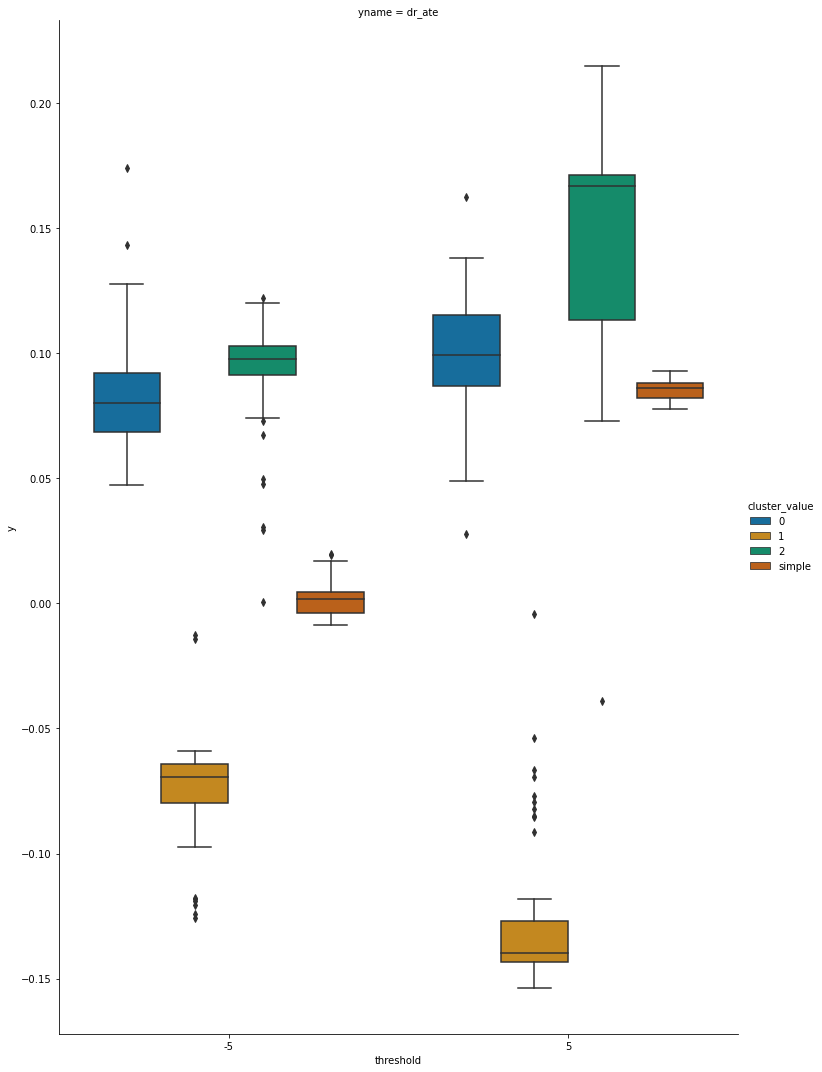

In [110]:
def ate_groups(ct,n_iters = 60, 
               categorical_confounders= None,
               use_limits=True,
               use_dose_confounders=False,
               include_mimic= True,
               min_pval=.25, **kwargs):
    if categorical_confounders is None:
        categorical_confounders=[
                't4','t3',
                'n2','n3',
                'hpv',
                'BOT','Tonsil',
                'IMRT','VMAT',
            ]
    if use_limits:
        limits = [
            'Parotid_Gland_limit',
            'SPC_limit','IPC_limit','MPC_limit',
            "Esophagus_limit",
            'Larynx_limit'
        ]
        for l in limits:
            if l not in categorical_confounders:
                categorical_confounders.append(l)
    
    dose_ate = ct.get_ate(n_iters=n_iters,
               confounder_pval_filter=min_pval,
               use_dose_confounders=use_dose_confounders,
               categorical_confounders=categorical_confounders,
#                clusters=[1,ct.n_clusters-1],
                skip_first=False,
               use_mimic=False,
                aggregate=False,
                **kwargs)
    if include_mimic:
        mimic_ate = ct.get_ate(n_iters=n_iters,
                   confounder_pval_filter=min_pval,
                   use_dose_confounders=use_dose_confounders,
                   categorical_confounders=categorical_confounders,
                   skip_first=True,
                   use_mimic=True,
                    aggregate=False,
                    **kwargs)
        mimic_ate.cluster_value = mimic_ate.cluster_value.apply(lambda x: 'simple' if x == 1 else x)
        dose_ate = pd.concat([dose_ate,mimic_ate],ignore_index = True)
    plot_ate(dose_ate)
    return dose_ate

def plot_ate(df,y = ['dr_ate'],kind='box',minval = -100,maxval =100,height=15):
    dfs =[]
    for ytemp in y:
        tempdf = df.copy()
        tempdf['y'] = tempdf[ytemp]
        tempdf['yname'] = ytemp
        tempdf = tempdf[tempdf['y'] >= minval]
        tempdf = tempdf[tempdf['y'] <= maxval]
        dfs.append(tempdf)
    df = pd.concat(dfs,axis=0,ignore_index=True)
    chart = sns.catplot(
        data = df,
        kind=kind,
        x = 'threshold',
        y = 'y',
        hue='cluster_value',
        palette='colorblind',
        col='yname',
        height=height,
        aspect=.7*len(y),
#         notch=True,
#         showfliers=False,
    )

# pd.options.mode.chained_assignment = None
d = ate_groups(ct,
                 n_iters=60,
               thresholds=[5,-5],
                 min_pval = 1,
               use_iptw=False,
               categorical_confounders=['t_severe','hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'],
               use_limits=False,
                )

threshold cluster_value  dr_ate_05  dr_ate_median  dr_ate_95
0         -5             0   0.054585       0.080029   0.109929
1         -5             1  -0.118991      -0.069248  -0.060969
2         -5             2   0.046969       0.097703   0.115778
3         -5        simple  -0.007726       0.001710   0.015179
4          5             0   0.065953       0.099110   0.125910
5          5             1  -0.149870      -0.139854  -0.069167
6          5             2   0.074658       0.166917   0.178219
7          5        simple   0.078921       0.086211   0.091052

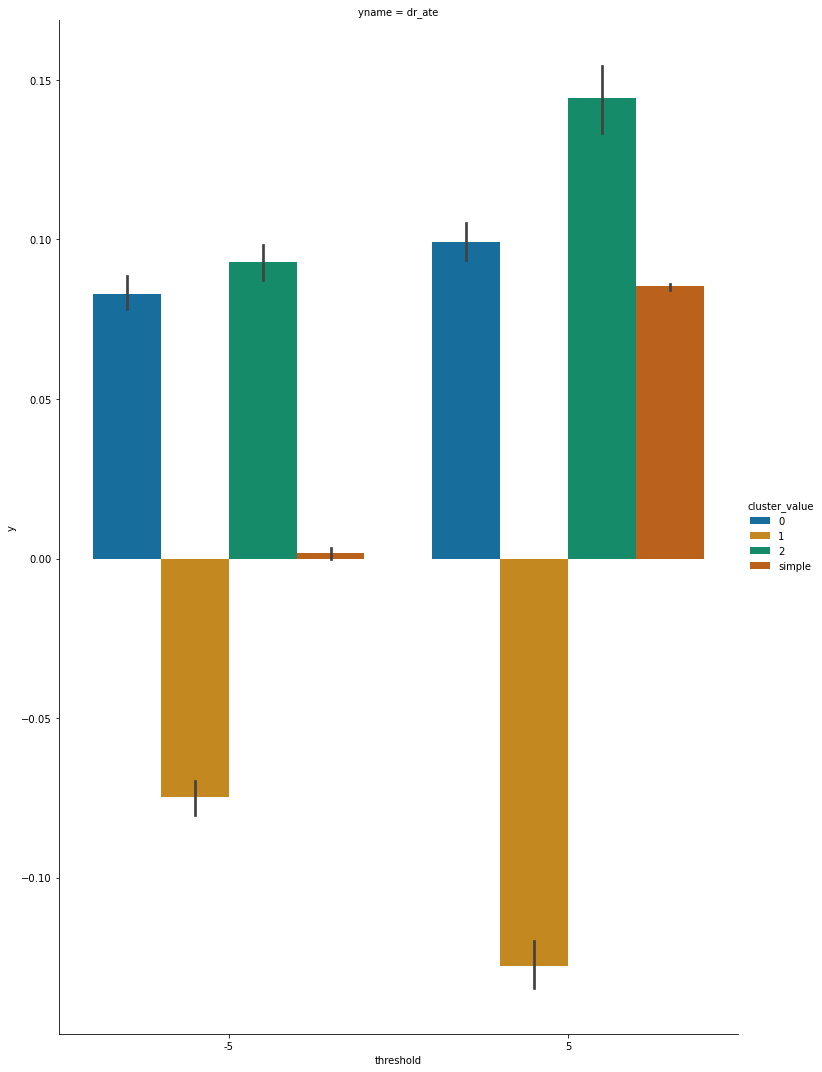

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

In [111]:
plot_ate(d,y=['dr_ate'],kind='bar')
aggregate_ate_results(d).drop(['dr_ate_sig','dr_ate_positive','confounders'],axis=1)

In [ ]:
prop_df = ct.all_propensity_scores(categorical_confounders= [
    't_severe','hpv','n_severe',
    'BOT', 'Tonsil', 
    'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'
])
prop_df = prop_df.set_index('cluster')
prop_df = prop_df.loc[[0,1,2,'simple'],:]
fig,axes = plt.subplots(1,prop_df.shape[0],figsize=(prop_df.shape[0]*7,5))
i = 0
for cluster,row in prop_df.iterrows():
    t = row['treated'].reshape(-1,1)
    ut = row['untreated'].reshape(-1,1)
    minval = np.min([t.min(),ut.min()])
    maxval= np.max([t.max(),ut.max()])
    axis = axes[i]
    axis.hist(t,color='blue',alpha=.3,bins=np.linspace(minval,maxval),density=True)
    axis.hist(ut,color='green',alpha=.3,bins=np.linspace(minval,maxval),density=True)
    axis.set_title('cluster ' + str(cluster))
    i += 1
prop_df[['treated_mean','untreated_mean','treated_0.25','untreated_0.25','treated_0.5','untreated_0.5','treated_0.75','untreated_0.75']]

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'threshold': 5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.09082744769636514}

{'threshold': -5, 'cluster_value': 1, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': -0.9518135659066496}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'threshold': -5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.869808996126332}

{'threshold': -5, 'cluster_value': 2, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 1.433146612581646}

{'threshold': 5, 'cluster_value': 0, 'confounders': ['t_severe', 'hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'], 'dr_ate': 0.01869669739157631}

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11
lb 15
lb 16
lb 5
lb 11


/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is tryin

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did 

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which mea

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

threshold cluster_value  dr_ate_05  dr_ate_median  dr_ate_95
0         -5             0  -2.207928      -2.162769  -0.445988
1         -5             1  -1.705601      -0.973576   0.097666
2         -5             2  -0.550087       0.818621   1.428916
3         -5        simple   0.444397       0.492240   0.544081
4          5             0  -0.025717      -0.009253   0.017391
5          5             1  -0.156713      -0.091291  -0.009069
6          5             2   0.014741       0.132944   0.154518
7          5        simple   0.100515       0.106984   0.112854

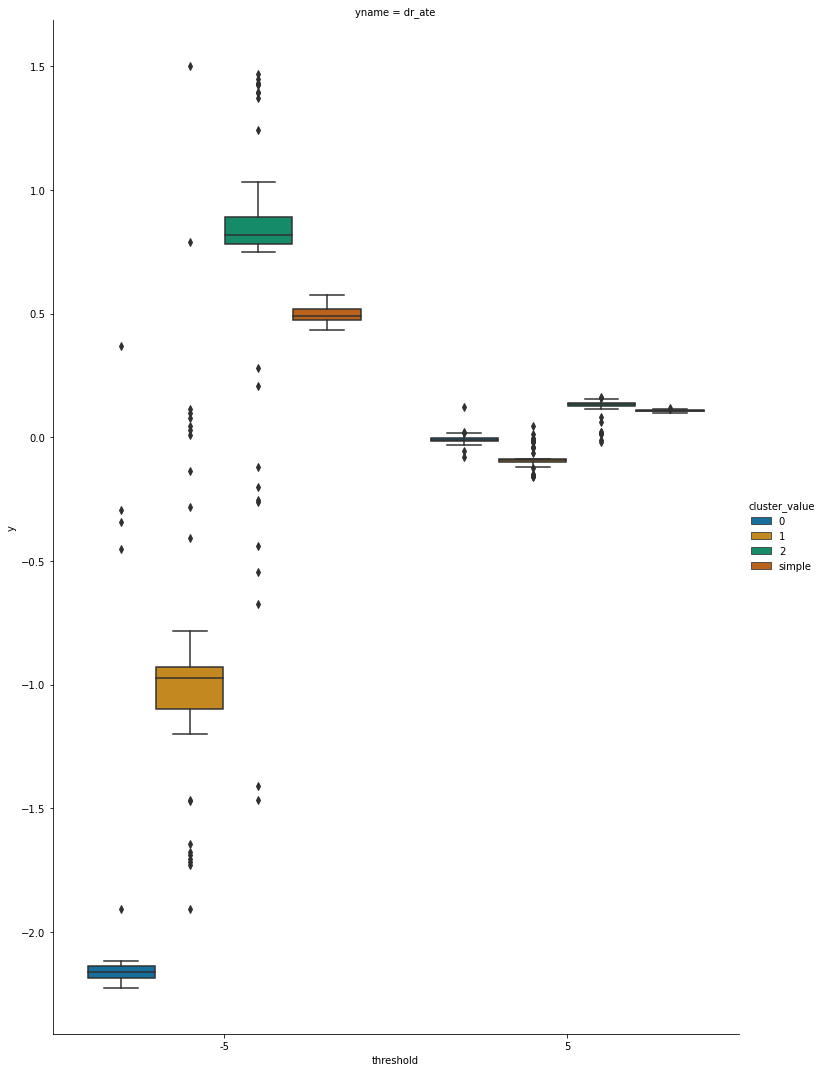

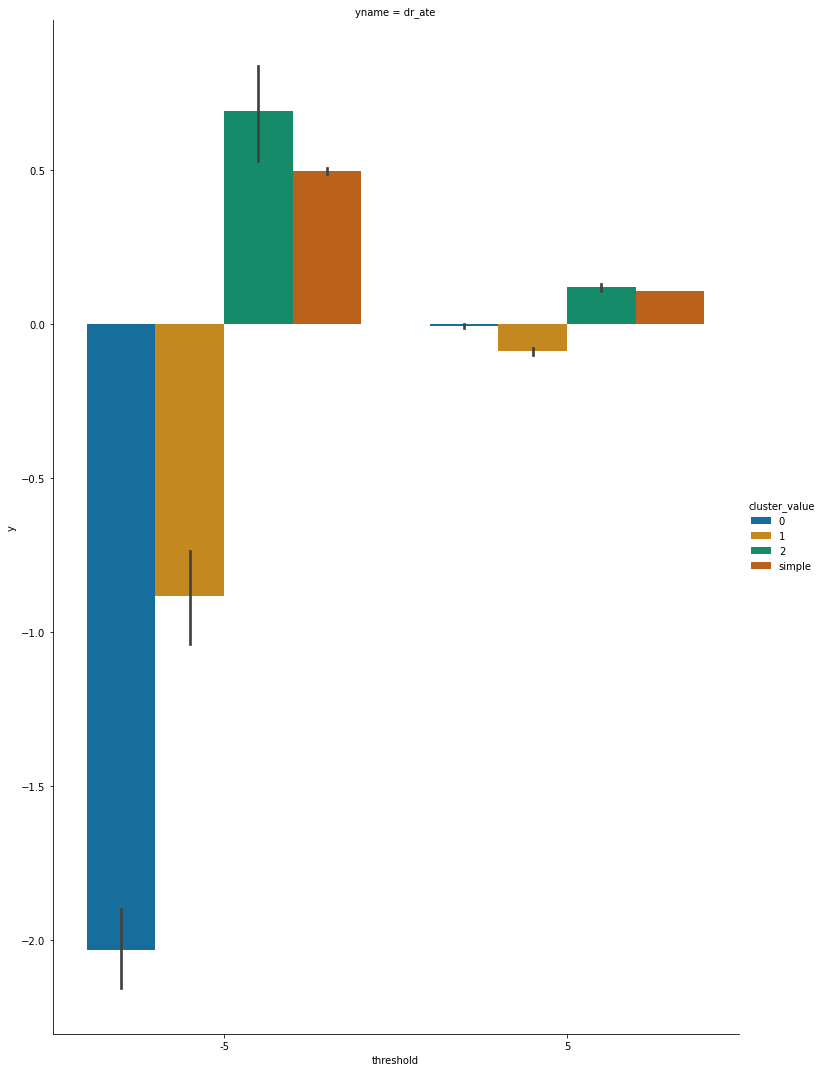

In [95]:
d_i = ate_groups(ct_i,
                 n_iters=60,
               thresholds=[5,-5],
                 min_pval = 1,
               use_iptw=False,
               categorical_confounders=['t_severe','hpv', 'n_severe', 'BOT', 'Tonsil', 'SPC_limit', 'MPC_limit', 'Esophagus_limit', 'Larynx_limit'],
               use_limits=False,
                )
plot_ate(d_i,y=['dr_ate'],kind='bar')
aggregate_ate_results(d_i).drop(['dr_ate_sig','dr_ate_positive','confounders'],axis=1)

In [29]:
from sklearn.preprocessing import quantile_transform

def fold_i_of_k(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

def stratify_cluster(traindf,testdf,as_rank=True,key='x'):
    res = []
    for c, subdf in traindf.groupby('x'):
        mean_y = subdf.outcome.mean()
        res.append((c,mean_y))
    res = sorted(res,key = lambda x: x[1])
#     print(res)
    maxR = np.max([x[1] for x in res])
    res = {k: v/(maxR+1) for (k,v) in res}
    ypred = testdf[key].apply(lambda x: res.get(x,0)).values
    if as_rank:
        ranks = sorted(np.unique(ypred))
        denom = max(1,len(ranks)-1)
        ypred = np.array([ranks.index(i)/denom for i in ypred])
    return ypred

def unsupervised_predictors(ct,mimic=False,as_probability=True,as_rank=True,cluster=None,threshold=-1,n_cvs=10):
    df = ct.get_cluster_df(use_mimic=mimic)
    df = df.copy()
    outcome = ct.get_outcome(threshold=threshold)
    df['outcome'] = outcome
    df['x'] = df.dose_clusters#.astype(str) + df.performance_high.astype('str')
    if cluster is not None and not mimic:
        df['x'] = df.dose_clusters.apply(lambda x: x == cluster)
    ypreds = []
    subdfs = np.array_split(df,n_cvs)
    for subdf in subdfs:
        traindf = df.drop(index=subdf.index)
        ypred = stratify_cluster(traindf,subdf,as_rank=as_rank)
        ypreds.append(ypred)
    ypred = np.concatenate(ypreds,axis=0)
    if as_probability:
        ypred = np.stack([1-ypred,ypred],axis=1)
    return ypred

unsupervised_predictors(ct,threshold=3,cluster=ct.n_clusters-1)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.

In [30]:
def predict_ntcp_cv(ct,clinical=None,model=None,threshold=5,organs = None):
    df = ct.df.copy()
    if organs is None:
        if ct.symptoms[0] in ['drymouth','salivary_mean','salivary_max']:
            #from https://www.sciencedirect.com/science/article/pii/S016781401200117X#s0060
            #suppelment stuff.  They also uses cheeks and sublingual glands which i use oral cavity  and mylogeniohyoid instead
            print('using drymtouh ntcp')
            organs = [
                'Lt_Parotid_Gland','Rt_Parotid_Gland',
                'Lt_Submandibular_Gland','Rt_Submandibular_Gland',
                'Soft_Palate',
                'Upper_Lip','Lower_Lip',
                'Extended_Oral_Cavity',
                'Mylogeniohyoid_M',
             ]
        elif ct.symptoms[0] in ['choke','swallow']:
            print('using choke ntcp')
            #https://pure.rug.nl/ws/portalfiles/portal/74422467/Chapter_4.pdf
            organs = [
                'SPC','IPC','Supraglottic_Larynx',
                'Rt_Parotid_Gland','Cricopharyngeal_Muscle'
            ]
        elif ct.symptoms[0] in ['mucus','mucositis']:
            #https://pure.rug.nl/ws/portalfiles/portal/74422467/Chapter_4.pdf
            organs = [
                'Soft_Palate','Hard_Palate',
                "Extended_Oral_Cavity",
                'Mandible','Tongue',
                'Lt_Parotid_Gland','Rt_Parotid_Gland',
            ]
        elif ct.symptoms[0] in ['voice']:
            #I don't have a baseline idk
            organs = [
                'Larynx',
                'Supraglottic_Larynx',
                'Tongue',
                'Genioglossus_M',
                'Mylogeniohyoid_M',
            ]
            print('using voice ntcp')
        else:
            organs = Const.organ_list[:]
            print('idk using all organs for ntcp model',ct.symptoms[0])
    #I don't use their clinical stuff tho
    if clinical is None:
        clinical = ct.default_confounders[:]
    opositions = [Const.organ_list.index(o) for o in organs if o in Const.organ_list]
    vals = df.mean_dose.apply(lambda x: [x[i] for i in opositions]).values
    vals = np.stack(vals)
    cvals = df[clinical]
    if len([c for c in cvals if c  != 'age']) > 0:
        cvals = Utils.onehotify(cvals,ignore=(['age'] if 'age' in clinical else []),drop_first=True).values
    else:
        cvals = cvals.values
    cvals = (cvals - cvals.min(axis=0))/(cvals.max(axis=0) - cvals.min(axis=0))
    x = np.hstack([vals,cvals])
    y = ct.get_outcome(threshold=threshold)
    if model is None:
        model = LogisticRegression(C=10000,random_state=0)
    ypred = predict_cv(model,x,y)
    return y,ypred

def ntcp_model(ct,clinical=None,model=None,md_organs=None,thresholds=None):
    if thresholds is None:
        thresholds = [3,5,7]
    res= []
    for threshold in thresholds:
        y,ypred = predict_ntcp_cv(ct,clinical=clinical,model=model,threshold=threshold,organs=md_organs)
        metrics = get_stratification_metrics(y,ypred)
        metrics['threshold'] = threshold
        res.append(metrics)
    return pd.DataFrame(res)

ntcp_model(ct)

using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp


roc       mcc        dor  accuracy  precision    recall        f1  \
0  0.534424  0.149340  24.026289  0.687679   0.717105  0.904564  0.800000   
1  0.558924  0.061847   0.523175  0.550143   0.482456  0.359477  0.411985   
2  0.508923  0.031763   0.032967  0.722063   0.315789  0.066667  0.110092   

     f_half        f2  threshold  
0  0.748113  0.859621          3  
1  0.451560  0.378788          5  
2  0.180723  0.079156          7

lb 5
lb 11
lb 15
lb 16
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp


roc       mcc        dor  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.476737 -0.081026   1.720661   
                              clusters    0.642327  0.233445   6.331598   
                              hd cluster  0.625538  0.233445   6.331598   
                              ntcp        0.534424  0.149340  24.026289   
                              simplified  0.621561  0.225355   4.757883   
                   True       base        0.537384  0.071092   1.730769   
                              clusters    0.619036  0.218934   3.844310   
                              hd cluster  0.610331  0.218934   3.844310   
                              ntcp        0.563635  0.159021  17.246261   
                              simplified  0.610517  0.218628   2.895465   
5         drymouth False      base        0.547636  0.085934   0.977349   
                              clusters    0.597539  0.142675   1.584066   
                              hd cluster  0.601190  0.201977   2.241758   
                              ntcp        0.558924  0.061847   0.523175   
                              simplified  0.569711  0.138716   1.245750   
                   True       base        0.530216  0.031463   0.637898   
                              clusters    0.577268  0.108874   0.920000   
                              hd cluster  0.584397  0.159222   1.299145   
                              ntcp        0.572266  0.075065   0.366792   
                              simplified  0.546137  0.086773   0.653595   
7         drymouth False      base        0.496396  0.023331   0.456204   
                              clusters    0.597898  0.161106   1.047983   
                              hd cluster  0.591549  0.161106   1.047983   
                              ntcp        0.508923  0.031763   0.032967   
                              simplified  0.569048  0.121136   0.600832   
                   True       base        0.404578 -0.090184   0.068566   
                              clusters    0.595587  0.143080   0.720128   
                              hd cluster  0.591913  0.143080   0.720128   
                              ntcp        0.511787  0.082101   0.047745   
                              simplified  0.569764  0.108267   0.405630   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.464183   0.653409  0.477178   
                              clusters    0.627507   0.787565  0.630705   
                              hd cluster  0.627507   0.787565  0.630705   
                              ntcp        0.687679   0.717105  0.904564   
                              simplified  0.590258   0.802469  0.539419   
                   True       base        0.532951   0.617647  0.517241   
                              clusters    0.616046   0.678756  0.645320   
                              hd cluster  0.616046   0.678756  0.645320   
                              ntcp        0.613181   0.611842  0.916256   
                              simplified  0.601719   0.697531  0.556650   
5         drymouth False      base        0.547278   0.484472  0.509804   
                              clusters    0.567335   0.505435  0.607843   
                              hd cluster  0.593123   0.528497  0.666667   
                              ntcp        0.550143   0.482456  0.359477   
                              simplified  0.573066   0.512346  0.542484   
                   True       base        0.504298   0.340541  0.552632   
                              clusters    0.541547   0.375000  0.605263   
                              hd cluster  0.555874   0.393782  0.666667   
                              ntcp        0.593123   0.377193  0.377193   
                              simplified  0.553009   0.370370  0.526316

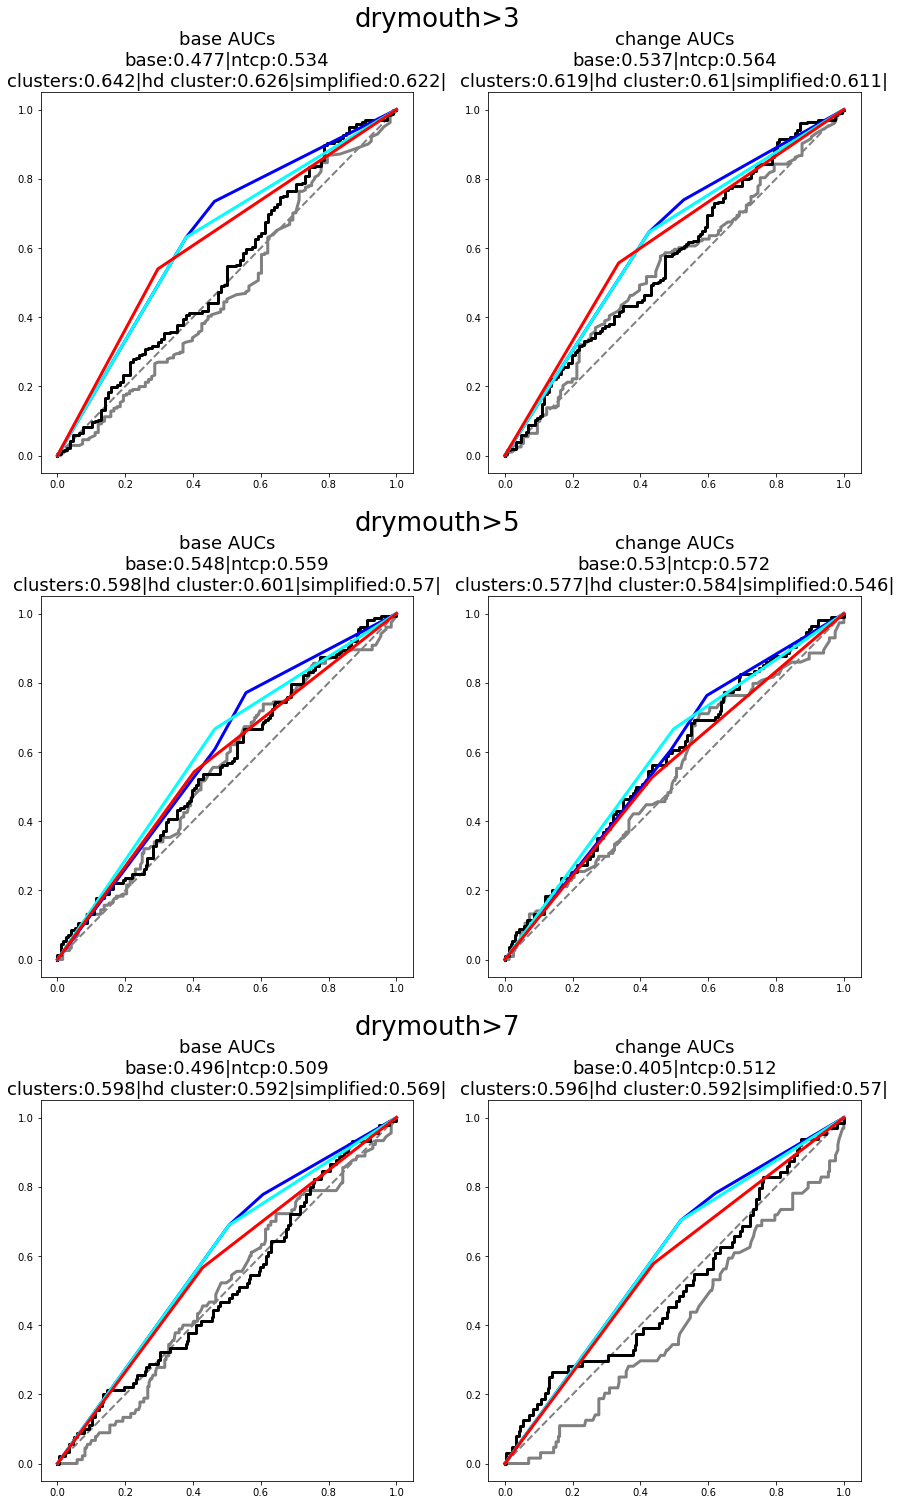

In [31]:
def plot_roc_curves(ct_list,thresholds=None,size=7,**kwargs):
    if thresholds is None:
        thresholds = [3,5,7]
    figsize=(2.1*size,size*len(thresholds))
    fig = plt.figure(constrained_layout=True,figsize=figsize)
    subfigures = fig.subfigures(len(thresholds),1)
    
    res = []
    for i, t in enumerate(thresholds):
        axes = subfigures[i].subplots(1,2)
        for row,use_change in enumerate([False,True]):
            axis= axes[row]
            for c in ct_list:
                y, y1, y0 = c.predict_cv(threshold=t,use_mimic=False,use_change=use_change,**kwargs)

#                 _, y2, y0_alt = c.predict_cv(threshold=t,use_mimic=True,use_change=use_change,**kwargs)
                
                #these are just static stratifications
                y3 = unsupervised_predictors(c, mimic=False,threshold=t)
                y4 = unsupervised_predictors(c, mimic=False,threshold=t,cluster=c.n_clusters-1)
                y5 = unsupervised_predictors(c, mimic=True,threshold=t)
                
                _, y6 = predict_ntcp_cv(c,threshold=t)
                axis.plot([0,1],[0,1],color='grey',linestyle='dashed',linewidth=2)
                colors = [
                    'grey','black',
                    'blue','cyan','red'
#                     'brown','green',
                ]
                names = [
                    'base','ntcp',
#                     'clust_lr','simple_lr',
                    'clusters','hd cluster','simplified',
                ]
                pstring = lambda p: str(np.round(p,2))
                title = ('change' if use_change else 'base') + ' AUCs\n'
                to_plot = [
                    y0,y6,
                    y3,y4,y5,
                ]
                for iii, ycurr in enumerate(to_plot):
                    (fpr, tpr, _threh) = roc_curve(y,ycurr[:,1])
                    axis.plot(fpr,tpr,color=colors[iii],linewidth=3)
                    performance = get_stratification_metrics(y,ycurr)
                    pval = np.round(delong(y.astype(int), ycurr[:,1], y0[:,1])[0][0],3)
                    entry = {
                        'threshold': t,
                        'use_change': use_change,
                        'outcome': ','.join(c.symptoms),
                        'name': names[iii],
                    }
                    for k,v in performance.items():
                        entry[k] = v
                    entry['delong_pval'] = pval
                    res.append(entry)
#                     print(names[iii],performance['roc'],pval)
                    title += names[iii] + ':' + str(np.round(performance['roc'],3))
                    if iii == 1:
                        title += '\n'
                    else:
                        title += '|'
                axis.set_title(title,fontdict={'fontsize': 18})
        suptitle = ''.join(ct_list[0].symptoms) + '>' + str(t) + '\n'
        subfigures[i].suptitle(suptitle,fontsize=26,y=1.05)
    plt.subplots_adjust(hspace=.4)
#     fig.tight_layout()
    return pd.DataFrame(res).groupby(['threshold','outcome','use_change','name']).first()

def plot_roc_sets(ct,df=None,organs=None,features=None, symptomlists = None, model=None,confounders=None,n_clusters=None,thresholds=None,**kwargs):
    if organs is None:
        organs = ct.cluster_organs[:]
    if df is None:
        df = ct.df.copy()
    if symptomlists is None:
        symptomlists = [
            ct.symptoms,
        ]
    if confounders is None:
        confounders = ct.default_confounders[:]
    if n_clusters is None:
        n_clusters = ct.n_clusters
    if features is None:
        features = ct.cluster_features[:]
    cts = []
    for symptoms in symptomlists:
        ctester = ClusterTester(df,
                       organs,
                       symptoms=symptoms, 
                       confounders=confounders,
                       n_clusters = n_clusters,
                        cluster_features=features,
                        outcome_dates = ct.outcome_dates[:],
                       **kwargs,
                      )
        cts.append(ctester)
    return plot_roc_curves(cts,model=model,thresholds=thresholds)

plot_roc_sets(ct)

lb 5
lb 11
lb 15
lb 16
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp
using drymtouh ntcp


roc       mcc        dor  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.562171  0.144619   3.394506   
                              clusters    0.574833  0.153667   3.580459   
                              hd cluster  0.579013  0.153667   3.580459   
                              ntcp        0.572076  0.133784  11.265786   
                              simplified  0.551142  0.099156   2.134792   
                   True       base        0.560927  0.104473   1.276203   
                              clusters    0.543477  0.115169   1.841335   
                              hd cluster  0.557279  0.115169   1.841335   
                              ntcp        0.596089  0.156998   7.831041   
                              simplified  0.534916  0.069989   1.103896   
5         drymouth False      base        0.549880  0.119177   0.954345   
                              clusters    0.579009  0.181950   1.645750   
                              hd cluster  0.593856  0.181950   1.645750   
                              ntcp        0.548536  0.112945   0.286990   
                              simplified  0.571461  0.138110   0.971853   
                   True       base        0.571371  0.111265   0.702509   
                              clusters    0.582812  0.171658   1.133998   
                              hd cluster  0.596853  0.171658   1.133998   
                              ntcp        0.562976  0.079224   0.151494   
                              simplified  0.561221  0.108171   0.571523   
7         drymouth False      base        0.559346  0.126482   0.394525   
                              clusters    0.619113  0.191695   1.008676   
                              hd cluster  0.624677  0.191695   1.008676   
                              ntcp        0.602057  0.173597   0.128571   
                              simplified  0.590424  0.138602   0.485215   
                   True       base        0.567525  0.070715   0.239464   
                              clusters    0.615291  0.161678   0.680625   
                              hd cluster  0.622283  0.161678   0.680625   
                              ntcp        0.618331  0.181860   0.109649   
                              simplified  0.566841  0.088103   0.253447   

                                          accuracy  precision    recall  \
threshold outcome  use_change name                                        
3         drymouth False      base        0.581662   0.691099  0.602740   
                              clusters    0.587393   0.694301  0.611872   
                              hd cluster  0.587393   0.694301  0.611872   
                              ntcp        0.630372   0.658451  0.853881   
                              simplified  0.538682   0.679012  0.502283   
                   True       base        0.553009   0.543210  0.517647   
                              clusters    0.555874   0.538860  0.611765   
                              hd cluster  0.555874   0.538860  0.611765   
                              ntcp        0.553009   0.524648  0.876471   
                              simplified  0.535817   0.524691  0.500000   
5         drymouth False      base        0.561605   0.426036  0.562500   
                              clusters    0.573066   0.445596  0.671875   
                              hd cluster  0.573066   0.445596  0.671875   
                              ntcp        0.627507   0.483871  0.234375   
                              simplified  0.575931   0.438272  0.554688   
                   True       base        0.541547   0.311111  0.608696   
                              clusters    0.550143   0.331606  0.695652   
                              hd cluster  0.550143   0.331606  0.695652   
                              ntcp        0.679083   0.338710  0.228261   
                              simplified  0.564470   0.314815  0.554348

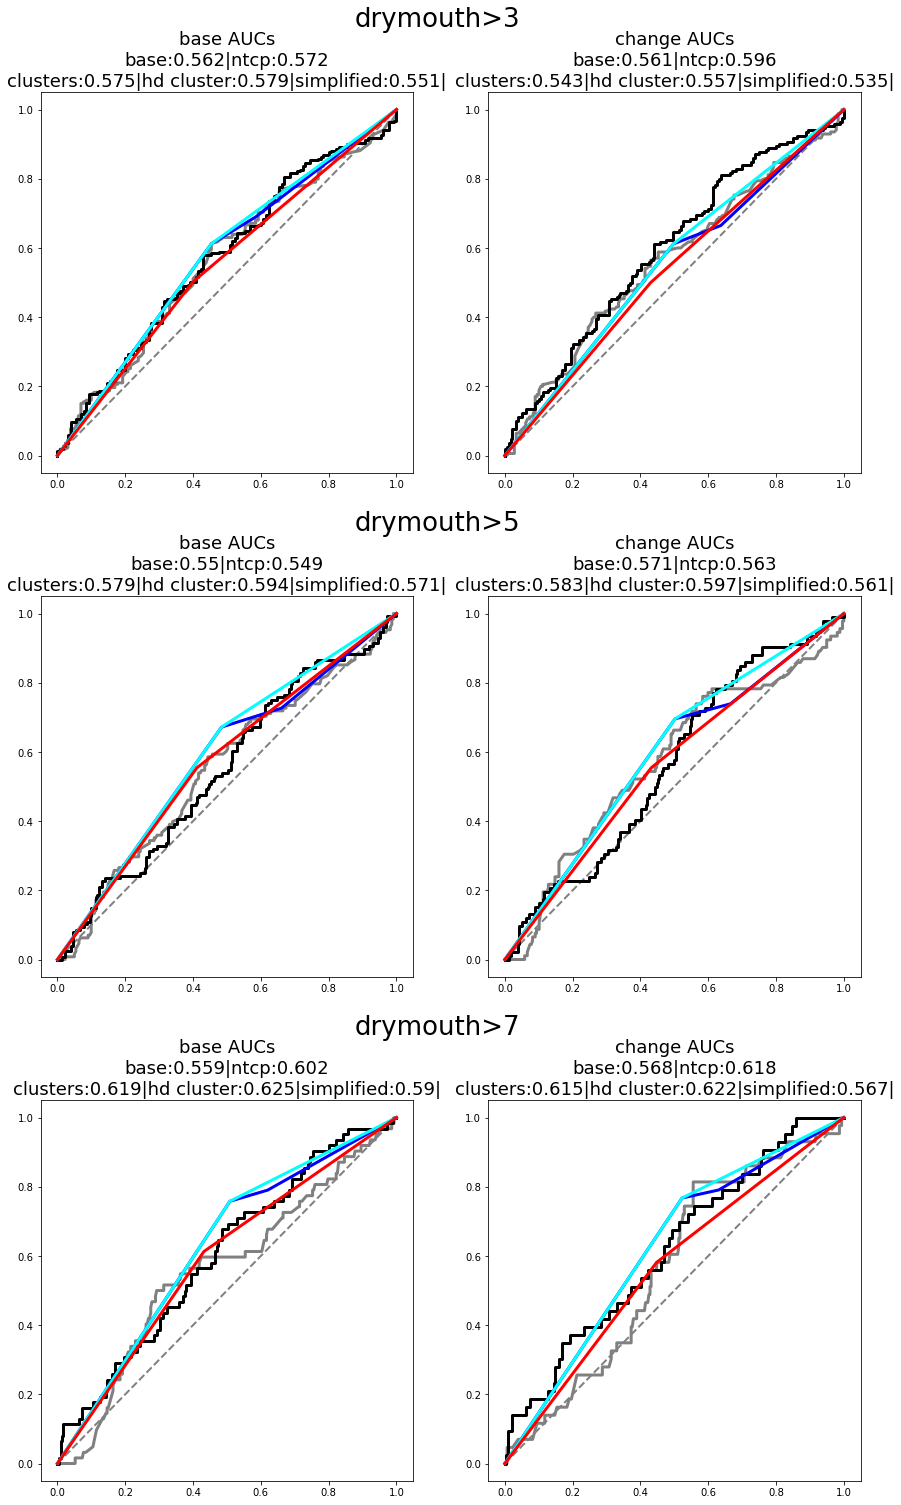

In [32]:
plot_roc_sets(ct_i)

In [ ]:
#results  for other stuff
#sddf is no filtering based of having an outcome currently idk

In [97]:
choke_organs = [
   'IPC',
    'MPC',
    'Supraglottic_Larynx',
    "Esophagus",
    'Mylogeniohyoid_M',
]
choke_ct = ClusterTester(sddf,
                       choke_organs,
                       symptoms=['choke'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Larynx_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V30','V35','V40','V45','V50','V55','V60','V65'],
                      )
eval_ct(choke_ct,thresholds=[5],delta_thresholds=[5])

lb 5
lb 11
lb 15
lb 16
mean_dose_MPC>59.0, V10_IPC>95.0, V30_Supraglottic_Larynx>79.0 
 roc_cluster:0.931 roc_outcome_3:0.675 roc_outcome_change_3:0.684 cluster_precision:[0.979 0.795] cluster_recall:[0.92  0.942] cluster_f1:[0.949 0.862] roc_outcome_5:0.745 roc_outcome_change_5:0.747 roc_outcome_7:0.73 roc_outcome_change_7:0.8 
 _________________ 
 mean_dose_MPC>59.0, V10_IPC>95.0 
 roc_cluster:0.926 roc_outcome_3:0.671 roc_outcome_change_3:0.68 cluster_precision:[0.979 0.776] cluster_recall:[0.91  0.942] cluster_f1:[0.943 0.851] roc_outcome_5:0.741 roc_outcome_change_5:0.743 roc_outcome_7:0.726 roc_outcome_change_7:0.8 
 _________________ 
 mean_dose_MPC>59.0, V25_Supraglottic_Larynx>91.0 
 roc_cluster:0.924 roc_outcome_3:0.675 roc_outcome_change_3:0.684 cluster_precision:[0.976 0.787] cluster_recall:[0.916 0.932] cluster_f1:[0.945 0.853] roc_outcome_5:0.745 roc_outcome_change_5:0.747 roc_outcome_7:0.73 roc_outcome_change_7:0.8 
 _________________ 
 mean_dose_MPC>59.0 
 roc_cluster:0

lrt_pval  \
threshold cluster    confounders                                                        
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  2.887871e-06   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  1.791244e-08   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  4.498182e-07   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  2.373995e-02   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  2.254905e-01   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  1.786045e-06   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  2.018949e-06   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  2.957654e-07   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  1.098055e-02   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  1.406644e-01   

                                                                           odds_ratio  \
threshold cluster    confounders                                                        
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...           NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  5.056516e-08   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  6.687454e-02   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  3.603160e+00   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  1.888672e+00   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...           NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  8.135314e-02   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  9.106668e-02   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  3.801738e+00   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  2.039858e+00   

                                                                          aic_diff  \
threshold cluster    confounders                                                     
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -21.509982   
          0          hpv,age_65,Larynx_limit,performance_1,performan... -29.708631   
          1          hpv,age_65,Larynx_limit,performance_1,performan... -23.467843   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  -3.113532   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...   0.530917   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -22.471014   
          0          hpv,age_65,Larynx_limit,performance_1,performan... -20.576926   
          1          hpv,age_65,Larynx_limit,performance_1,performan... -24.277163   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  -4.468463   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  -0.170676   

                                                                          bic_diff  
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -13.458250  
          0          hpv,age_65,Larynx_limit,performance_1,performan... -25.682765  
          1          hpv,age_65,Larynx_limit,performance_1,performan... -19.441977  
          2          hpv,age_65,Larynx_limit,performance_1,performan...   0.912334  
          simplified hpv,age_65,Larynx_limit,performance_1,performan...   4.556783  
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -14.419282  
          0          hpv,age_65,Larynx_limit,performance_1,performan... -16.551060  
          1          hpv,age_65,Larynx_limit,performance_1,performan... -20.251297  
          2          hpv,age_65,Larynx_limit,performance

lb 4
lb 7
lb 8
lb 8
using choke ntcp
using choke ntcp
using choke ntcp
using choke ntcp


roc       mcc       dor  \
threshold outcome use_change name                                       
3         choke   False      base        0.621804  0.106910  0.232000   
                             clusters    0.604877  0.234544  0.391892   
                             hd cluster  0.646067  0.234544  0.391892   
                             ntcp        0.630860 -0.006106  0.002506   
                             simplified  0.566738  0.093712  0.448934   
                  True       base        0.578666  0.093049  0.173160   
                             clusters    0.621598  0.206709  0.268601   
                             hd cluster  0.660611  0.206709  0.268601   
                             ntcp        0.584169 -0.042658  0.000000   
                             simplified  0.607350  0.120821  0.431872   
5         choke   False      base        0.441439 -0.038988  0.012847   
                             clusters    0.712525  0.247596  0.440449   
                             hd cluster  0.755763  0.247596  0.440449   
                             ntcp        0.565756 -0.018738  0.000000   
                             simplified  0.612458  0.095203  0.252242   
                  True       base        0.696912  0.171092  0.123737   
                             clusters    0.771533  0.248793  0.657609   
                             hd cluster  0.808364  0.248793  0.657609   
                             ntcp        0.630155 -0.015383  0.000000   
                             simplified  0.679743  0.126818  0.637168   

                                         accuracy  precision    recall  \
threshold outcome use_change name                                        
3         choke   False      base        0.628019   0.188312  0.500000   
                             clusters    0.751208   0.281553  0.500000   
                             hd cluster  0.751208   0.281553  0.500000   
                             ntcp        0.845411   0.125000  0.017241   
                             simplified  0.478261   0.168067  0.689655   
                  True       base        0.591787   0.114943  0.571429   
                             clusters    0.758454   0.184466  0.542857   
                             hd cluster  0.758454   0.184466  0.542857   
                             ntcp        0.896135   0.000000  0.000000   
                             simplified  0.471014   0.113445  0.771429   
5         choke   False      base        0.630435   0.034722  0.263158   
                             clusters    0.772947   0.135922  0.736842   
                             hd cluster  0.772947   0.135922  0.736842   
                             ntcp        0.946860   0.000000  0.000000   
                             simplified  0.451691   0.063025  0.789474   
                  True       base        0.826087   0.095890  0.538462   
                             clusters    0.772947   0.106796  0.846154   
                             hd cluster  0.772947   0.106796  0.846154   
                             ntcp        0.961353   0.000000  0.000000   
                             simplified  0.451691   0.050420  0.923077   

                                               f1    f_half        f2  \
threshold outcome use_change name                                       
3         choke   False      base        0.273585  0.215134  0.375648   
                             clusters    0.360248  0.308511  0.432836   
                             hd cluster  0.360248  0.308511  0.432836   
                             ntcp        0.030303  0.055556  0.020833   
                             simplified  0.270270  0.198020  0.425532   
                  True       base        0.191388  0.136799  0.318471   
                             clusters    0.275362  0.212528  0.390947   
                             hd cluster  0.275362  0.212528  0.390947   
                             ntcp        0.000000       NaN       NaN   
       

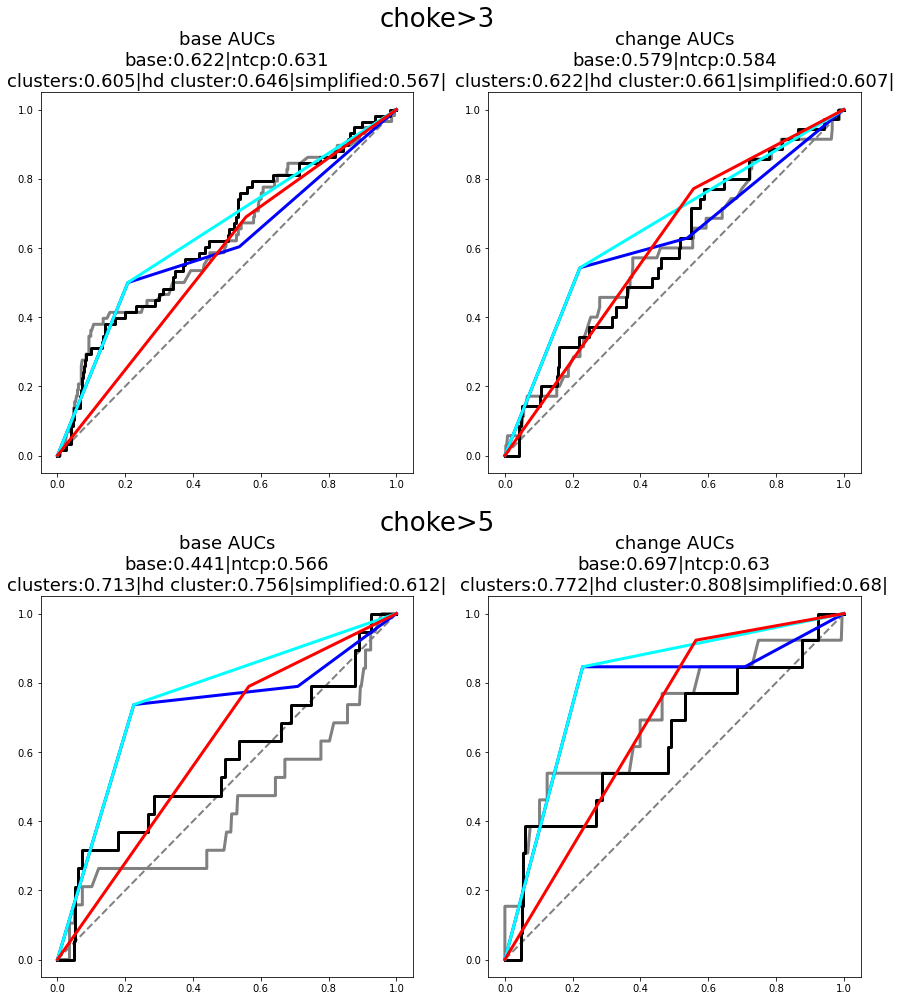

In [98]:
plot_roc_sets(choke_ct,thresholds=[3,5])

In [100]:
swallow_organs = [
   'IPC',
    'MPC',
    'Supraglottic_Larynx',
    'Esophagus',
]
swallow_ct = ClusterTester(sddf,
                       swallow_organs,
                       symptoms=['swallow'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Larynx_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V35','V40','V45','V50','V55','V60','V65'],
                      )
eval_ct(swallow_ct,thresholds=[5],delta_thresholds=[5])

lb 4
lb 7
lb 8
lb 8
V55_IPC>33.0, V55_MPC>58.0, V40_Supraglottic_Larynx>68.0 
 roc_cluster:0.936 roc_outcome_3:0.573 roc_outcome_change_3:0.572 cluster_precision:[0.978 0.982] cluster_recall:[0.997 0.875] cluster_f1:[0.987 0.926] roc_outcome_5:0.646 roc_outcome_change_5:0.544 roc_outcome_7:0.636 roc_outcome_change_7:0.5 
 _________________ 
 V55_IPC>33.0, V55_MPC>58.0 
 roc_cluster:0.935 roc_outcome_3:0.58 roc_outcome_change_3:0.583 cluster_precision:[0.978 0.966] cluster_recall:[0.994 0.875] cluster_f1:[0.986 0.918] roc_outcome_5:0.661 roc_outcome_change_5:0.572 roc_outcome_7:0.669 roc_outcome_change_7:0.5 
 _________________ 
 V55_IPC>33.0, V40_Supraglottic_Larynx>68.0 
 roc_cluster:0.94 roc_outcome_3:0.567 roc_outcome_change_3:0.567 cluster_precision:[0.98  0.934] cluster_recall:[0.989 0.891] cluster_f1:[0.984 0.912] roc_outcome_5:0.64 roc_outcome_change_5:0.539 roc_outcome_7:0.631 roc_outcome_change_7:0. 
 _________________ 
 V55_IPC>33.0 
 roc_cluster:0.938 roc_outcome_3:0.574 roc

lrt_pval  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  0.002076   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  0.000145   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  0.000954   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  0.011403   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  0.028182   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  0.000345   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  0.000075   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  0.000531   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  0.000868   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  0.001354   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...         NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...    0.224250   
          1          hpv,age_65,Larynx_limit,performance_1,performan...    0.336714   
          2          hpv,age_65,Larynx_limit,performance_1,performan...    4.353528   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...    3.729143   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...         NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...    0.277370   
          1          hpv,age_65,Larynx_limit,performance_1,performan...    0.385196   
          2          hpv,age_65,Larynx_limit,performance_1,performan...    5.150580   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...    5.160289   

                                                                          aic_diff  \
threshold cluster    confounders                                                     
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  -8.354894   
          0          hpv,age_65,Larynx_limit,performance_1,performan... -12.432616   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  -8.913896   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  -4.401431   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  -2.816877   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -11.945287   
          0          hpv,age_65,Larynx_limit,performance_1,performan... -13.688471   
          1          hpv,age_65,Larynx_limit,performance_1,performan... -10.004971   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  -9.090920   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  -8.267193   

                                                                         bic_diff  
threshold cluster    confounders                                                   
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -0.303162  
          0          hpv,age_65,Larynx_limit,performance_1,performan... -8.406750  
          1          hpv,age_65,Larynx_limit,performance_1,performan... -4.888030  
          2          hpv,age_65,Larynx_limit,performance_1,performan... -0.375565  
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  1.208989  
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -3.893555  
          0          hpv,age_65,Larynx_limit,performance_1,performan... -9.662605  
          1          hpv,age_65,Larynx_limit,performance_1,performan... -5.979105  
          2          hpv,age_65,Larynx_limit,performance_1,performan... -5.065054  
          simplified hpv,age_65,Larynx_limit,perfo

lb 3
lb 4
lb 4
using choke ntcp
using choke ntcp
using choke ntcp
using choke ntcp


roc       mcc       dor  \
threshold outcome use_change name                                       
3         swallow False      base        0.588252  0.129022  0.751267   
                             clusters    0.600240  0.138265  0.247717   
                             hd cluster  0.554315  0.138265  0.247717   
                             ntcp        0.560543  0.016639  0.038462   
                             simplified  0.554563  0.101571  0.979604   
                  True       base        0.592122  0.121265  0.441385   
                             clusters    0.593563  0.095320  0.113604   
                             hd cluster  0.543638  0.095320  0.113604   
                             ntcp        0.535853  0.019391  0.023166   
                             simplified  0.577545  0.123867  0.717949   
5         swallow False      base        0.619422  0.140776  0.222222   
                             clusters    0.635901  0.199925  0.198353   
                             hd cluster  0.612876  0.199925  0.198353   
                             ntcp        0.576218 -0.025232  0.000000   
                             simplified  0.528347  0.036716  0.240385   
                  True       base        0.491491 -0.019458  0.035804   
                             clusters    0.626511  0.144425  0.097466   
                             hd cluster  0.602284  0.144425  0.097466   
                             ntcp        0.526556 -0.019122  0.000000   
                             simplified  0.543171  0.044576  0.164840   

                                         accuracy  precision    recall  \
threshold outcome use_change name                                        
3         swallow False      base        0.572464   0.367876  0.563492   
                             clusters    0.681159   0.453125  0.230159   
                             hd cluster  0.681159   0.453125  0.230159   
                             ntcp        0.673913   0.333333  0.071429   
                             simplified  0.516908   0.344538  0.650794   
                  True       base        0.577295   0.245989  0.575000   
                             clusters    0.739130   0.281250  0.225000   
                             hd cluster  0.739130   0.281250  0.225000   
                             ntcp        0.770531   0.222222  0.075000   
                             simplified  0.502415   0.235294  0.700000   
5         swallow False      base        0.681159   0.181818  0.500000   
                             clusters    0.811594   0.265625  0.354167   
                             hd cluster  0.811594   0.265625  0.354167   
                             ntcp        0.879227   0.000000  0.000000   
                             simplified  0.454106   0.126050  0.625000   
                  True       base        0.599034   0.063694  0.344828   
                             clusters    0.823671   0.156250  0.344828   
                             hd cluster  0.823671   0.156250  0.344828   
                             ntcp        0.925121   0.000000  0.000000   
                             simplified  0.446860   0.079832  0.655172   

                                               f1    f_half        f2  \
threshold outcome use_change name                                       
3         swallow False      base        0.445141  0.395323  0.509326   
                             clusters    0.305263  0.379581  0.255282   
                             hd cluster  0.305263  0.379581  0.255282   
                             ntcp        0.117647  0.192308  0.084746   
                             simplified  0.450549  0.380334  0.552561   
                  True       base        0.344569  0.277778  0.453649   
                             clusters    0.250000  0.267857  0.234375   
                             hd cluster  0.250000  0.267857  0.234375   
                             ntcp        0.112150  0.159574  0.086455   
       

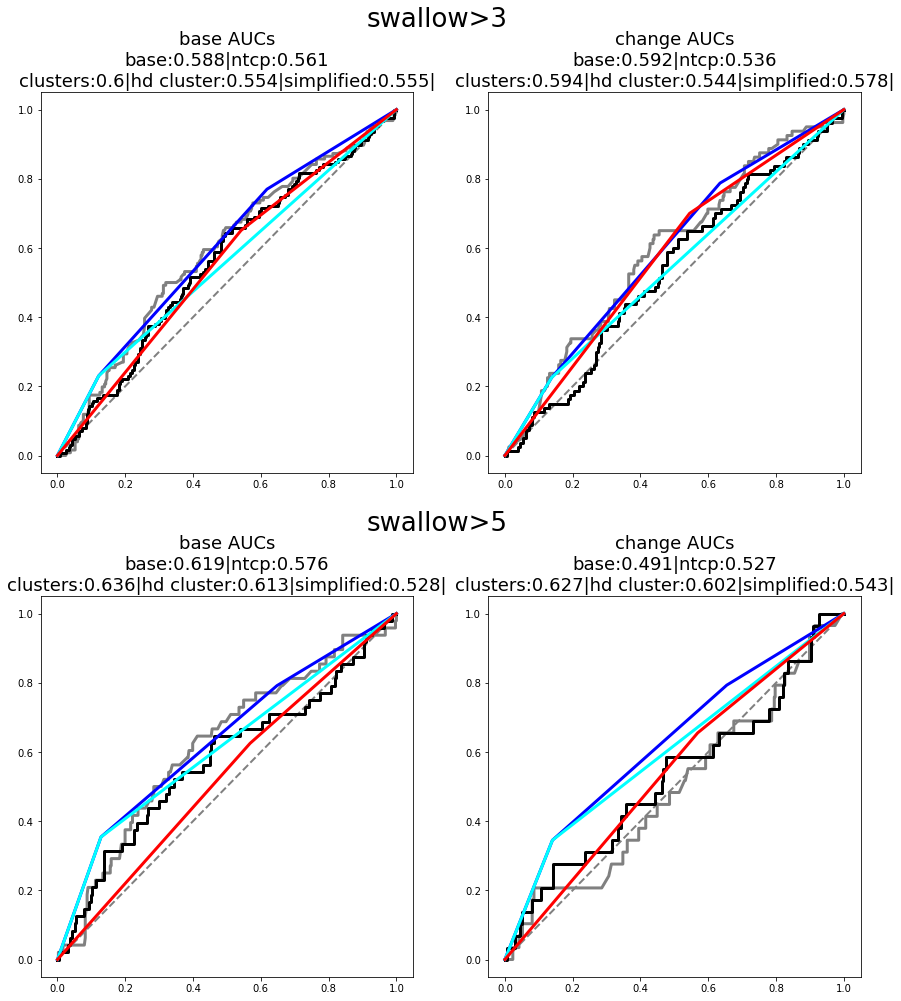

In [101]:
plot_roc_sets(swallow_ct,thresholds=[3,5])

In [102]:
mucus_organs = [
    'Rt_Parotid_Gland','Lt_Parotid_Gland',
    'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
]
mucus_ct = ClusterTester(sddf,
                       mucus_organs,
                       symptoms=['mucus'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Parotid_Gland_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V30','V35','V40','V45','V50','V55','V60'],
                      )
eval_ct(mucus_ct,thresholds=[5],delta_thresholds=[5])

lb 6
lb 18
lb 32
lb 39
V50_Rt_Submandibular_Gland>40.0, V60_Lt_Submandibular_Gland>11.0 
 roc_cluster:0.967 roc_outcome_3:0.61 roc_outcome_change_3:0.63 cluster_precision:[0.95  0.981] cluster_recall:[0.979 0.954] cluster_f1:[0.965 0.968] roc_outcome_5:0.63 roc_outcome_change_5:0.656 roc_outcome_7:0.617 roc_outcome_change_7:0.6 
 _________________ 
 V5_Rt_Submandibular_Gland>94.0, V50_Rt_Submandibular_Gland>40.0, V60_Lt_Submandibular_Gland>11.0 
 roc_cluster:0.967 roc_outcome_3:0.61 roc_outcome_change_3:0.63 cluster_precision:[0.95  0.981] cluster_recall:[0.979 0.954] cluster_f1:[0.965 0.968] roc_outcome_5:0.63 roc_outcome_change_5:0.656 roc_outcome_7:0.617 roc_outcome_change_7:0.6 
 _________________ 
 V50_Rt_Submandibular_Gland>40.0 
 roc_cluster:0.964 roc_outcome_3:0.605 roc_outcome_change_3:0.626 cluster_precision:[0.955 0.972] cluster_recall:[0.969 0.959] cluster_f1:[0.962 0.966] roc_outcome_5:0.626 roc_outcome_change_5:0.653 roc_outcome_7:0.613 roc_outcome_change_7:0.6 
 ________

lrt_pval  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.001859   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.001295   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.000401   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.008826   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.002797   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.000884   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.002083   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.000203   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.003007   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.001855   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.218583   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.233511   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.408564   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.733860   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.292468   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.254082   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.493323   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.599597   

                                                                          aic_diff  \
threshold cluster    confounders                                                     
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -8.575549   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -8.350154   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -10.528718   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -4.857681   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -6.935616   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe... -10.062793   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -7.474974   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -11.803768   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -6.803220   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -7.688069   

                                                                         bic_diff  
threshold cluster    confounders                                                   
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe... -0.523817  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -4.324288  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -6.502852  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -0.831815  
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe... -2.909750  
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe... -2.011061  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -3.449108  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -7.777902  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -2.777354  
          simplified hpv,age_65,Parotid_Gland_limi

lb 3
lb 4
lb 4


roc       mcc       dor  \
threshold outcome use_change name                                       
3         mucus   False      base        0.499868 -0.008159  0.367543   
                             clusters    0.598696  0.175750  1.296399   
                             hd cluster  0.593393  0.175750  1.296399   
                             ntcp        0.522535  0.020923  0.064262   
                             simplified  0.568319  0.146147  2.876549   
                  True       base        0.521907  0.028071  0.304198   
                             clusters    0.613171  0.183250  0.979824   
                             hd cluster  0.609587  0.183250  0.979824   
                             ntcp        0.535323  0.004738  0.032143   
                             simplified  0.564215  0.122063  1.778947   
5         mucus   False      base        0.514675  0.034895  0.139260   
                             clusters    0.634032  0.171748  0.700379   
                             hd cluster  0.623499  0.171748  0.700379   
                             ntcp        0.438396 -0.028123  0.000000   
                             simplified  0.551434  0.081310  0.893023   
                  True       base        0.509398 -0.004456  0.080919   
                             clusters    0.641278  0.168390  0.624865   
                             hd cluster  0.636364  0.168390  0.624865   
                             ntcp        0.476044 -0.024027  0.000000   
                             simplified  0.569656  0.097778  0.898010   

                                         accuracy  precision    recall  \
threshold outcome use_change name                                        
3         mucus   False      base        0.516908   0.324176  0.433824   
                             clusters    0.572464   0.406393  0.654412   
                             hd cluster  0.572464   0.406393  0.654412   
                             ntcp        0.644928   0.358974  0.102941   
                             simplified  0.478261   0.369281  0.830882   
                  True       base        0.528986   0.237113  0.494624   
                             clusters    0.560386   0.296804  0.698925   
                             hd cluster  0.560386   0.296804  0.698925   
                             ntcp        0.724638   0.230769  0.096774   
                             simplified  0.413043   0.254902  0.838710   
5         mucus   False      base        0.591787   0.155280  0.431034   
                             clusters    0.538647   0.196347  0.741379   
                             hd cluster  0.538647   0.196347  0.741379   
                             ntcp        0.855072   0.000000  0.000000   
                             simplified  0.352657   0.156863  0.827586   
                  True       base        0.565217   0.104651  0.409091   
                             clusters    0.528986   0.155251  0.772727   
                             hd cluster  0.528986   0.155251  0.772727   
                             ntcp        0.888889   0.000000  0.000000   
                             simplified  0.338164   0.124183  0.863636   

                                               f1    f_half        f2  \
threshold outcome use_change name                                       
3         mucus   False      base        0.371069  0.341435  0.406336   
                             clusters    0.501408  0.439723  0.583224   
                             hd cluster  0.501408  0.439723  0.583224   
                             ntcp        0.160000  0.239726  0.120069   
                             simplified  0.511312  0.415441  0.664706   
                  True       base        0.320557  0.264672  0.406360   
                             clusters    0.416667  0.335397  0.549915   
                             hd cluster  0.416667  0.335397  0.549915   
                             ntcp        0.136364  0.180723  0.109489   
       

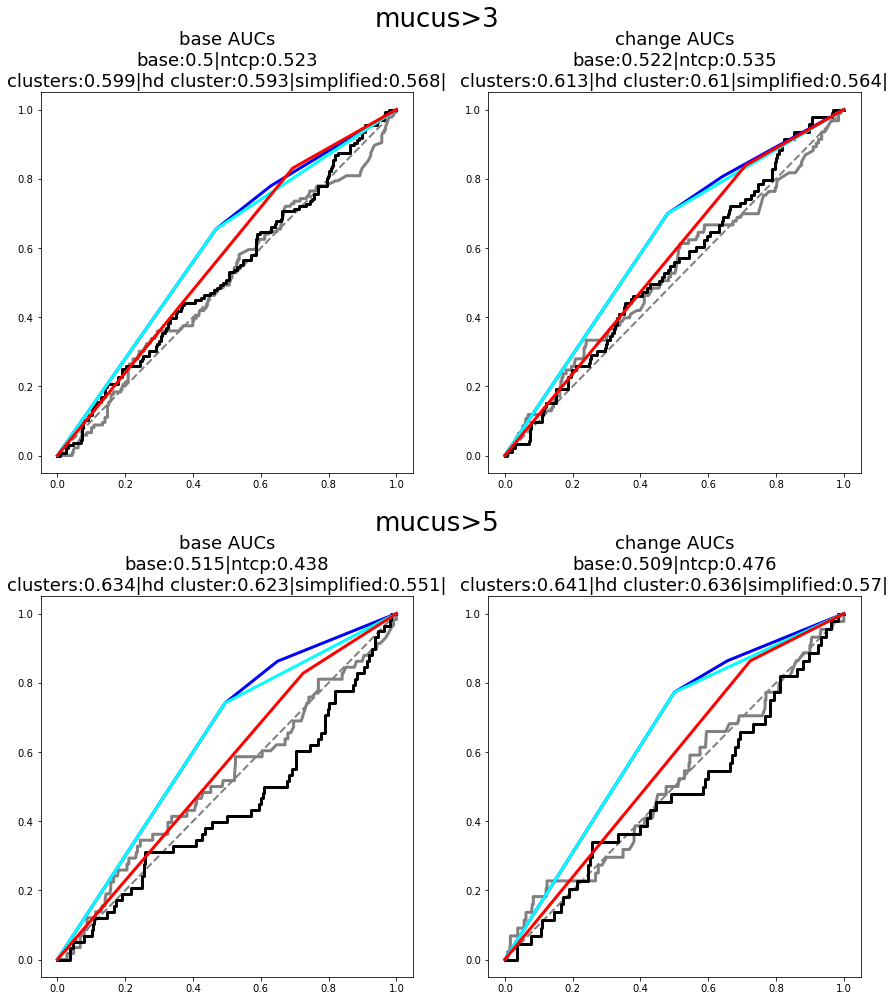

In [103]:
plot_roc_sets(mucus_ct,thresholds=[3,5])

In [116]:
mucus_ct2 = ClusterTester(sddf3,
                       mucus_organs + ['Hard_Palate'],
                       symptoms=['mucus'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Parotid_Gland_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V25','V30','V35','V40','V45','V50','V55','V60'],
                      )
eval_ct(mucus_ct2,thresholds=[5],delta_thresholds=[5])

lb 6
lb 16
lb 26
lb 31
V50_Rt_Submandibular_Gland>46.0, V5_Rt_Parotid_Gland>41.0, V55_Lt_Submandibular_Gland>29.0 
 roc_cluster:0.934 roc_outcome_3:0.605 roc_outcome_change_3:0.602 cluster_precision:[0.898 0.962] cluster_recall:[0.955 0.912] cluster_f1:[0.925 0.936] roc_outcome_5:0.571 roc_outcome_change_5:0.603 roc_outcome_7:0.585 roc_outcome_change_7:0.6 
 _________________ 
 V50_Rt_Submandibular_Gland>46.0, V55_Lt_Submandibular_Gland>29.0, V10_Rt_Parotid_Gland>18.0 
 roc_cluster:0.934 roc_outcome_3:0.605 roc_outcome_change_3:0.602 cluster_precision:[0.898 0.962] cluster_recall:[0.955 0.912] cluster_f1:[0.925 0.936] roc_outcome_5:0.571 roc_outcome_change_5:0.603 roc_outcome_7:0.585 roc_outcome_change_7:0.6 
 _________________ 
 V5_Rt_Submandibular_Gland>100.0, V50_Rt_Submandibular_Gland>46.0, V5_Rt_Parotid_Gland>41.0, V55_Lt_Submandibular_Gland>29.0 
 roc_cluster:0.934 roc_outcome_3:0.605 roc_outcome_change_3:0.602 cluster_precision:[0.898 0.962] cluster_recall:[0.955 0.912] cluster_

lrt_pval  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.022568   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.001098   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.011132   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.008614   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.010613   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.007026   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.019372   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.004162   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.002465   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.003630   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.088105   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.385735   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.639417   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.512846   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.291415   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.372780   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.828412   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.646169   

                                                                         aic_diff  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe... -3.582486   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -8.654185   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -4.444081   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -4.901131   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe... -4.528922   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe... -5.916175   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -3.467634   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -6.211613   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -7.166664   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe... -6.460407   

                                                                         bic_diff  
threshold cluster    confounders                                                   
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  4.127658  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -4.799114  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -0.589009  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -1.046059  
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe... -0.673850  
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  1.793969  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.387438  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -2.356541  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -3.311592  
          simplified hpv,age_65,Parotid_Gland_limit,performanc

lb 5
lb 11
lb 15
lb 16


roc       mcc       dor  \
threshold outcome use_change name                                       
3         mucus   False      base        0.546525  0.077717  0.607081   
                             clusters    0.584443  0.177618  1.502060   
                             hd cluster  0.592959  0.177618  1.502060   
                             ntcp        0.556623  0.067696  0.170425   
                             simplified  0.597143  0.185043  1.130523   
                  True       base        0.564086  0.040747  0.302446   
                             clusters    0.612742  0.193136  1.222646   
                             hd cluster  0.611416  0.193136  1.222646   
                             ntcp        0.592139  0.099403  0.149668   
                             simplified  0.616345  0.201061  0.911969   
5         mucus   False      base        0.574202  0.109782  0.269231   
                             clusters    0.593521  0.157516  0.737281   
                             hd cluster  0.606686  0.157516  0.737281   
                             ntcp        0.491955 -0.040708  0.000000   
                             simplified  0.617047  0.172281  0.576421   
                  True       base        0.525050  0.024687  0.102301   
                             clusters    0.601520  0.155407  0.636025   
                             hd cluster  0.618737  0.155407  0.636025   
                             ntcp        0.491934 -0.034441  0.000000   
                             simplified  0.628626  0.167831  0.486408   

                                         accuracy  precision    recall  \
threshold outcome use_change name                                        
3         mucus   False      base        0.555874   0.385621  0.491667   
                             clusters    0.567335   0.419689  0.675000   
                             hd cluster  0.567335   0.419689  0.675000   
                             ntcp        0.630372   0.418182  0.191667   
                             simplified  0.598854   0.438272  0.591667   
                  True       base        0.558739   0.267123  0.453488   
                             clusters    0.555874   0.321244  0.720930   
                             hd cluster  0.555874   0.321244  0.720930   
                             ntcp        0.704871   0.345455  0.220930   
                             simplified  0.604585   0.339506  0.639535   
5         mucus   False      base        0.621777   0.212121  0.500000   
                             clusters    0.521490   0.212435  0.732143   
                             hd cluster  0.521490   0.212435  0.732143   
                             ntcp        0.830946   0.000000  0.000000   
                             simplified  0.587393   0.228395  0.660714   
                  True       base        0.604585   0.130769  0.404762   
                             clusters    0.510029   0.165803  0.761905   
                             hd cluster  0.510029   0.165803  0.761905   
                             ntcp        0.871060   0.000000  0.000000   
                             simplified  0.581662   0.179012  0.690476   

                                               f1    f_half        f2  \
threshold outcome use_change name                                       
3         mucus   False      base        0.432234  0.403005  0.466035   
                             clusters    0.517572  0.454036  0.601783   
                             hd cluster  0.517572  0.454036  0.601783   
                             ntcp        0.262857  0.338235  0.214953   
                             simplified  0.503546  0.462240  0.552960   
                  True       base        0.336207  0.291045  0.397959   
                             clusters    0.444444  0.361305  0.577281   
                             hd cluster  0.444444  0.361305  0.577281   
                             ntcp        0.269504  0.310458  0.238095   
       

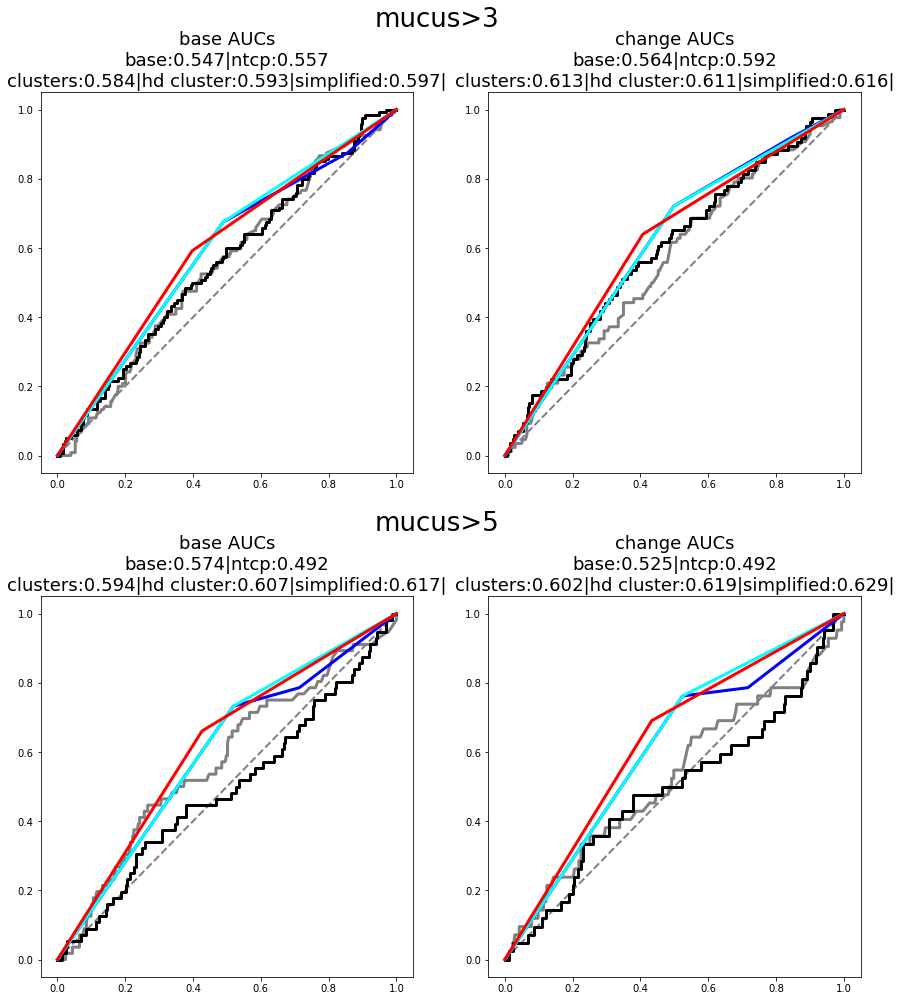

In [117]:
plot_roc_sets(mucus_ct2,thresholds=[3,5])

In [104]:
mucusitis_ct = ClusterTester(sddf,
                       [
                           'Extended_Oral_Cavity',
                            'Tongue',
                           'Rt_Submandibular_Gland',
                           'Mylogeniohyoid_M',
                       ],
                       symptoms=['mucositis'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Parotid_Gland_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V40','V45','V50','V55','V60'],
                      )
eval_ct(mucusitis_ct,thresholds=[5],delta_thresholds=[5])

lb 6
lb 16
lb 26
lb 31
max_dose_Rt_Submandibular_Gland>57.0, max_dose_Tongue>66.0, max_dose_Extended_Oral_Cavity>69.0 
 roc_cluster:0.947 roc_outcome_3:0.618 roc_outcome_change_3:0.614 cluster_precision:[0.935 0.957] cluster_recall:[0.945 0.948] cluster_f1:[0.94  0.952] roc_outcome_5:0.584 roc_outcome_change_5:0.634 roc_outcome_7:0.614 roc_outcome_change_7:0.5 
 _________________ 
 V5_Rt_Submandibular_Gland>94.0, max_dose_Rt_Submandibular_Gland>57.0, max_dose_Tongue>66.0, max_dose_Extended_Oral_Cavity>69.0 
 roc_cluster:0.945 roc_outcome_3:0.619 roc_outcome_change_3:0.615 cluster_precision:[0.93  0.956] cluster_recall:[0.945 0.944] cluster_f1:[0.937 0.95 ] roc_outcome_5:0.585 roc_outcome_change_5:0.635 roc_outcome_7:0.615 roc_outcome_change_7:0.5 
 _________________ 
 max_dose_Rt_Submandibular_Gland>57.0, V65_Extended_Oral_Cavity>10.0 
 roc_cluster:0.944 roc_outcome_3:0.602 roc_outcome_change_3:0.595 cluster_precision:[0.934 0.952] cluster_recall:[0.94  0.948] cluster_f1:[0.937 0.95 ] 

lrt_pval  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.048999   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.000002   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.020868   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.088179   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.143872   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.276659   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.000114   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.140882   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.215782   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  0.137129   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.067995   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.157051   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    2.164044   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    1.941510   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...         NaN   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.183018   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    0.423359   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...    1.649472   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...    1.836596   

                                                                          aic_diff  \
threshold cluster    confounders                                                     
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -2.031907   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -20.884197   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -3.337758   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -0.907312   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -0.136048   
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...   1.430062   
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -12.891705   
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -0.168299   
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...   0.467793   
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -0.209884   

                                                                          bic_diff  
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...   6.019825  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe... -16.858331  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...   0.688108  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...   3.118554  
          simplified hpv,age_65,Parotid_Gland_limit,performance_1,pe...   3.889818  
 5        -1         hpv,age_65,Parotid_Gland_limit,performance_1,pe...   9.481794  
          0          hpv,age_65,Parotid_Gland_limit,performance_1,pe...  -8.865839  
          1          hpv,age_65,Parotid_Gland_limit,performance_1,pe...   3.857567  
          2          hpv,age_65,Parotid_Gland_limit,performance_1,pe...   4.493659  
          simplified hpv,age_65,Parotid

lb 3
lb 4
lb 4


roc       mcc       dor  \
threshold outcome   use_change name                                       
3         mucositis False      base        0.655281  0.138705  0.263529   
                               clusters    0.599775  0.120888  0.496220   
                               hd cluster  0.589793  0.120888  0.496220   
                               ntcp        0.658496  0.080460  0.029685   
                               simplified  0.527988  0.038746  0.338824   
                    True       base        0.591174  0.066530  0.121672   
                               clusters    0.596582  0.104186  0.371287   
                               hd cluster  0.585637  0.104186  0.371287   
                               ntcp        0.599718  0.063288  0.019231   
                               simplified  0.533410  0.041796  0.278846   
5         mucositis False      base        0.652742  0.104901  0.212653   
                               clusters    0.575128  0.104063  0.316388   
                               hd cluster  0.598122  0.104063  0.316388   
                               ntcp        0.593110 -0.024306  0.000000   
                               simplified  0.577697  0.084733  0.347197   
                    True       base        0.515770  0.003039  0.032653   
                               clusters    0.644307  0.144740  0.564945   
                               hd cluster  0.660135  0.144740  0.564945   
                               ntcp        0.562732 -0.020240  0.000000   
                               simplified  0.599142  0.092146  0.333333   

                                           accuracy  precision    recall  \
threshold outcome   use_change name                                        
3         mucositis False      base        0.652174   0.190476  0.528302   
                               clusters    0.495169   0.163793  0.716981   
                               hd cluster  0.495169   0.163793  0.716981   
                               ntcp        0.855072   0.266667  0.075472   
                               simplified  0.415459   0.137931  0.679245   
                    True       base        0.632850   0.128378  0.452381   
                               clusters    0.483092   0.129310  0.714286   
                               hd cluster  0.483092   0.129310  0.714286   
                               ntcp        0.876812   0.200000  0.071429   
                               simplified  0.408213   0.111111  0.690476   
5         mucositis False      base        0.560386   0.104712  0.645161   
                               clusters    0.475845   0.099138  0.741935   
                               hd cluster  0.475845   0.099138  0.741935   
                               ntcp        0.917874   0.000000  0.000000   
                               simplified  0.410628   0.091954  0.774194   
                    True       base        0.628019   0.054054  0.363636   
                               clusters    0.478261   0.081897  0.863636   
                               hd cluster  0.478261   0.081897  0.863636   
                               ntcp        0.939614   0.000000  0.000000   
                               simplified  0.403382   0.068966  0.818182   

                                                 f1    f_half        f2  \
threshold outcome   use_change name                                       
3         mucositis False      base        0.280000  0.218409  0.389972   
                               clusters    0.266667  0.193680  0.427928   
                               hd cluster  0.266667  0.193680  0.427928   
                               ntcp        0.117647  0.176991  0.088106   
                               simplified  0.229299  0.164084  0.380550   
                    True       base        0.200000  0.149842  0.300633   
                               clusters    0.218978  0.154639  0.375000   
                               hd cluster  0.2189

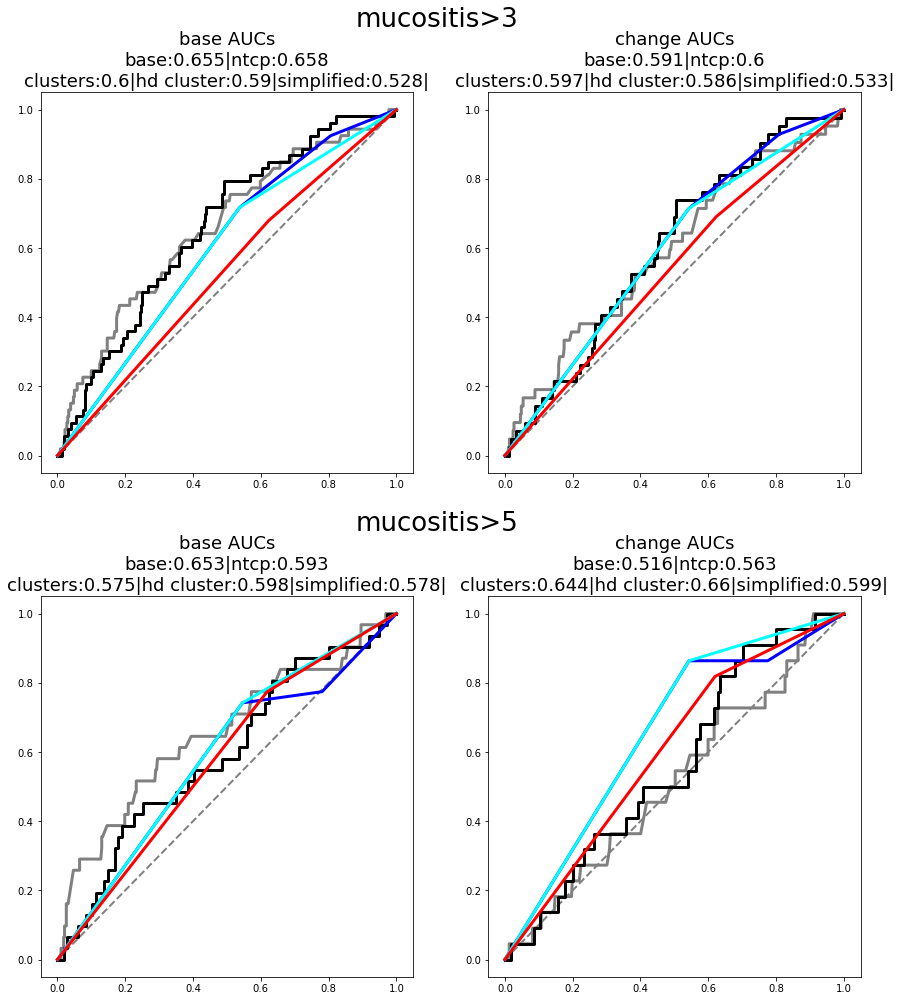

In [105]:
plot_roc_sets(mucusitis_ct,thresholds=[3,5])

In [108]:
voice_ct = ClusterTester(sddf,
                       [
                           'Tongue',
                           'IPC',
#                            'Larynx',
#                            'Supraglottic_Larynx'
                       ],
                       symptoms=['voice'],
                       n_clusters=3,
                       outcome_dates=[33],
                       default_confounders=[
                           'hpv',
                           'age_65',
                           'Larynx_limit',
                           'performance_1','performance_2',
                           't_severe','n_severe'
                       ],
                       cluster_features=['V40','V45','V50','V55','V60','V65'], 
#                        cluster_features=['V30','V35','V40','V45','V50','V55','V60','V65'],
                      )
eval_ct(voice_ct,thresholds=[5],delta_thresholds=[5])

lb 2
lb 2
V55_IPC>34.0 
 roc_cluster:0.927 roc_outcome_3:0.691 roc_outcome_change_3:0.609 cluster_precision:[0.972 0.984] cluster_recall:[0.997 0.857] cluster_f1:[0.984 0.916] roc_outcome_5:0.725 roc_outcome_change_5:0.678 roc_outcome_7:0.928 roc_outcome_change_7:0.9 
 _________________ 
 V55_IPC>34.0 
 roc_cluster:0.927 roc_outcome_3:0.691 roc_outcome_change_3:0.609 cluster_precision:[0.972 0.984] cluster_recall:[0.997 0.857] cluster_f1:[0.984 0.916] roc_outcome_5:0.725 roc_outcome_change_5:0.678 roc_outcome_7:0.928 roc_outcome_change_7:0.9 
 _________________ 
 


lrt_pval  \
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  0.000235   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  0.001176   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  0.000145   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  0.862982   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  0.889100   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  0.000037   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  0.000113   
          1          hpv,age_65,Larynx_limit,performance_1,performan...  0.000008   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  0.017916   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  0.011968   

                                                                         odds_ratio  \
threshold cluster    confounders                                                      
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...         NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...    0.134602   
          1          hpv,age_65,Larynx_limit,performance_1,performan...    0.097287   
          2          hpv,age_65,Larynx_limit,performance_1,performan...    0.846766   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...    0.874584   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...         NaN   
          0          hpv,age_65,Larynx_limit,performance_1,performan...    0.141931   
          1          hpv,age_65,Larynx_limit,performance_1,performan...    0.129314   
          2          hpv,age_65,Larynx_limit,performance_1,performan...    4.864649   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...    5.485065   

                                                                          aic_diff  \
threshold cluster    confounders                                                     
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -12.711028   
          0          hpv,age_65,Larynx_limit,performance_1,performan...  -8.527570   
          1          hpv,age_65,Larynx_limit,performance_1,performan... -12.430869   
          2          hpv,age_65,Larynx_limit,performance_1,performan...   1.970216   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...   1.980556   
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan... -16.426525   
          0          hpv,age_65,Larynx_limit,performance_1,performan... -12.911921   
          1          hpv,age_65,Larynx_limit,performance_1,performan... -18.006024   
          2          hpv,age_65,Larynx_limit,performance_1,performan...  -3.604379   
          simplified hpv,age_65,Larynx_limit,performance_1,performan...  -4.315649   

                                                                          bic_diff  
threshold cluster    confounders                                                    
-5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  -4.659296  
          0          hpv,age_65,Larynx_limit,performance_1,performan...  -4.501704  
          1          hpv,age_65,Larynx_limit,performance_1,performan...  -8.405003  
          2          hpv,age_65,Larynx_limit,performance_1,performan...   5.996082  
          simplified hpv,age_65,Larynx_limit,performance_1,performan...   6.006422  
 5        -1         hpv,age_65,Larynx_limit,performance_1,performan...  -8.374794  
          0          hpv,age_65,Larynx_limit,performance_1,performan...  -8.886055  
          1          hpv,age_65,Larynx_limit,performance_1,performan... -13.980158  
          2          hpv,age_65,Larynx_limit,performance_1,performan...   0.421487  
          simplified hpv,age_65,Larynx_

lb 4
lb 6
lb 7
lb 7
using voice ntcp
using voice ntcp
using voice ntcp
using voice ntcp


roc       mcc       dor  \
threshold outcome use_change name                                       
3         voice   False      base        0.584197  0.083163  0.272250   
                             clusters    0.582236  0.226387  0.280093   
                             hd cluster  0.622239  0.226387  0.280093   
                             ntcp        0.636333 -0.006106  0.002506   
                             simplified  0.552015  0.088626  1.346273   
                  True       base        0.469981 -0.011958  0.072727   
                             clusters    0.532628  0.135234  0.103448   
                             hd cluster  0.589947  0.135234  0.103448   
                             ntcp        0.573119 -0.043320  0.000000   
                             simplified  0.569444  0.096057  1.234694   
5         voice   False      base        0.636935  0.033812  0.061224   
                             clusters    0.600738  0.210448  0.189696   
                             hd cluster  0.704617  0.210448  0.189696   
                             ntcp        0.645729 -0.013970  0.000000   
                             simplified  0.544284  0.041903  0.313099   
                  True       base        0.161356 -0.076788  0.001005   
                             clusters    0.428922  0.053141  0.014706   
                             hd cluster  0.583333  0.053141  0.014706   
                             ntcp        0.583333 -0.008449  0.000000   
                             simplified  0.522059  0.012941  0.077640   

                                         accuracy  precision    recall  \
threshold outcome use_change name                                        
3         voice   False      base        0.553140   0.170984  0.568966   
                             clusters    0.797101   0.314286  0.379310   
                             hd cluster  0.797101   0.314286  0.379310   
                             ntcp        0.845411   0.125000  0.017241   
                             simplified  0.316425   0.155963  0.879310   
                  True       base        0.526570   0.083333  0.444444   
                             clusters    0.801932   0.171429  0.333333   
                             hd cluster  0.801932   0.171429  0.333333   
                             ntcp        0.893720   0.000000  0.000000   
                             simplified  0.282609   0.100917  0.916667   
5         voice   False      base        0.526570   0.045455  0.562500   
                             clusters    0.835749   0.128571  0.562500   
                             hd cluster  0.835749   0.128571  0.562500   
                             ntcp        0.956522   0.000000  0.000000   
                             simplified  0.239130   0.042813  0.875000   
                  True       base        0.507246   0.005000  0.166667   
                             clusters    0.826087   0.028571  0.333333   
                             hd cluster  0.826087   0.028571  0.333333   
                             ntcp        0.980676   0.000000  0.000000   
                             simplified  0.219807   0.015291  0.833333   

                                               f1    f_half        f2  \
threshold outcome use_change name                                       
3         voice   False      base        0.262948  0.198795  0.388235   
                             clusters    0.343750  0.325444  0.364238   
                             hd cluster  0.343750  0.325444  0.364238   
                             ntcp        0.030303  0.055556  0.020833   
                             simplified  0.264935  0.186676  0.456172   
                  True       base        0.140351  0.099502  0.238095   
                             clusters    0.226415  0.189873  0.280374   
                             hd cluster  0.226415  0.189873  0.280374   
                             ntcp        0.000000       NaN       NaN   
       

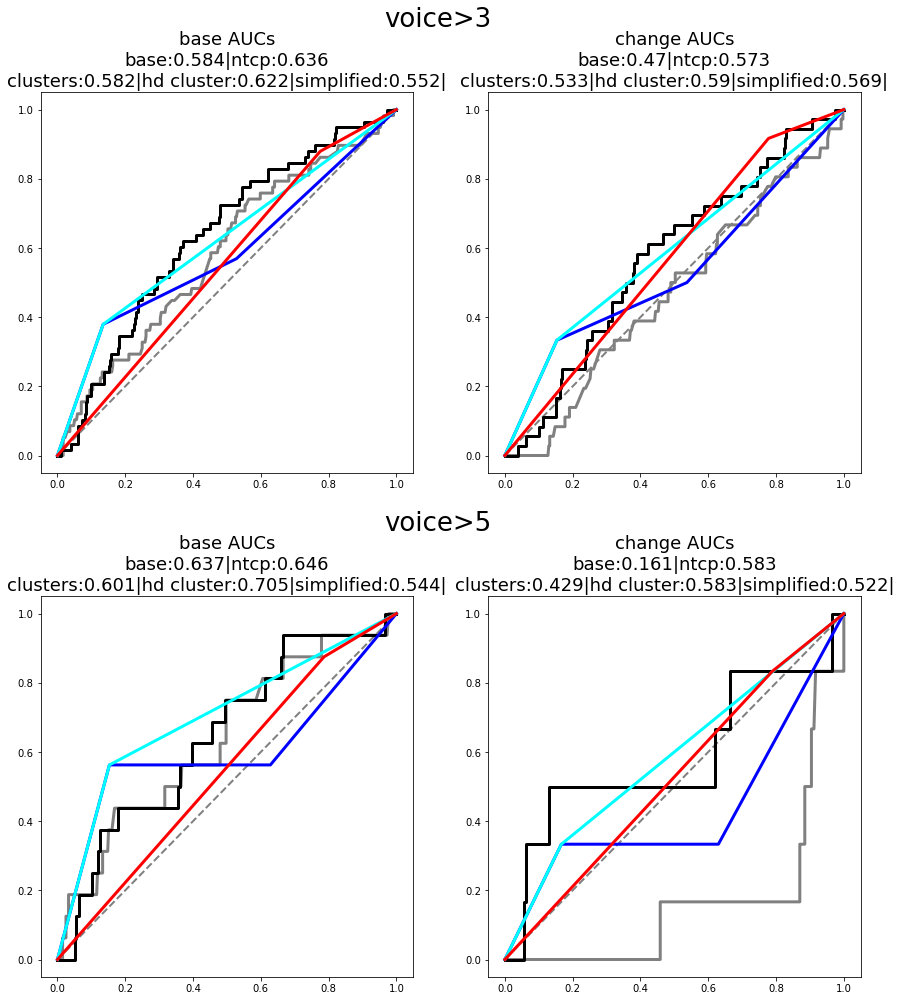

In [109]:
plot_roc_sets(voice_ct,thresholds=[3,5])

In [ ]:
# mucus_organs = [
#     'Hard_Palate',
#     "Soft_Palate",
#     'Tongue',
#     'Lt_Submandibular_Gland',
#     'Rt_Submandibular_Gland',
#     'Lt_Parotid_Gland',
#     'Rt_Parotid_Gland'
# ]
# mucus_ct = ClusterTester(sddf2,
#                        mucus_organs,
#                        symptoms=['mucositis'],
#                        n_clusters=3,
#                        default_confounders= [
#                            'hpv',
#                            'age_65',
#                            'performance_1','performance_2',
#                            't_severe','n_severe'],
#                        cluster_features=['V40','V45','V50','V55','V60'],
#                       )
# eval_ct(mucus_ct,thresholds=[0,2,3,4,5],delta_thresholds=[0,2,3,4,5])

# voice_organs = [
# #     'IPC',
# #     'Supraglottic_Larynx',
#     "Larynx",
#     'Tongue',
# #     'Genioglossus_M',
# #     'Hard_Palate',
# ]
# voice_ct = ClusterTester(sddf2,
#                        voice_organs,
#                        symptoms=['voice'],
#                        n_clusters=3,
#                        default_confounders= [
#                            'hpv',
#                            'age_65',
#                            'performance_1','performance_2',
#                            't_severe','n_severe'],
#                        cluster_features=['V50','V55','V60','V65','V70'],
#                       )
# eval_ct(voice_ct,thresholds=[0,2,3,4,5],delta_thresholds=[0,2,3,4,5])

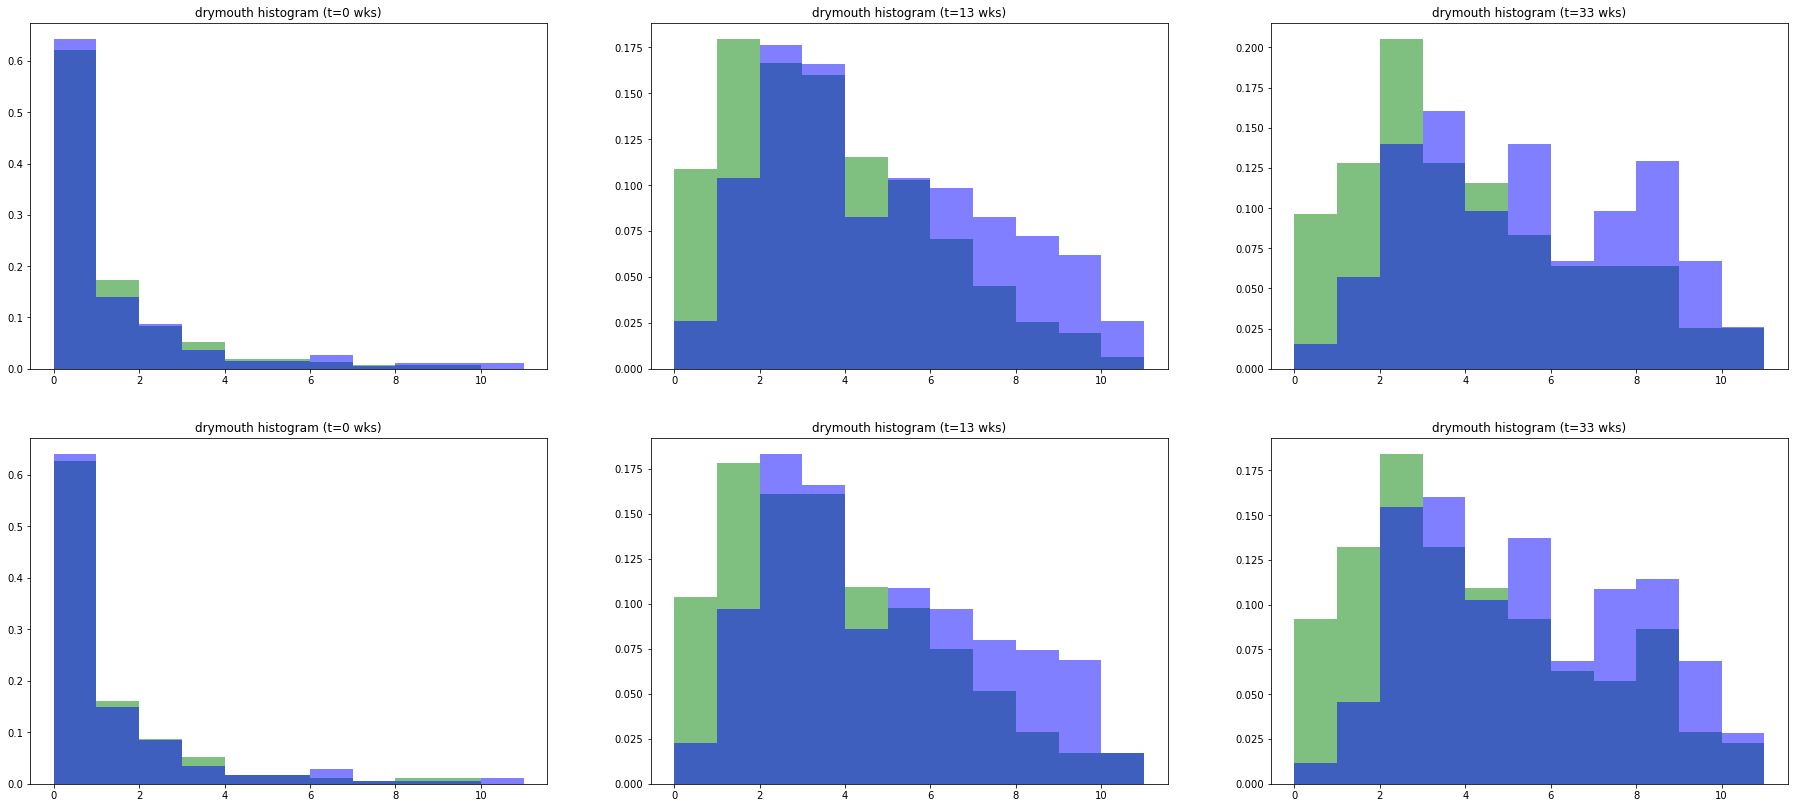

In [25]:
def symptom_histogram(ct,symptom=None,simplify=True,dates=[0,13,33],size=7,**kwargs):
    df = ct.get_cluster_df(**kwargs).copy()
    mimic_df = ct.get_cluster_df(use_mimic=True)
    if simplify:
        df['dose_clusters'] = df.dose_clusters == df.dose_clusters.max()
    df_dates =df.dates.iloc[0]
    dlocs = [df_dates.index(d) for d in dates if d in df_dates]
    if symptom is None:
        symptom = ct.symptoms[0]
    colors = ['green','blue']
    
    fig, axes = plt.subplots(2,len(dlocs),figsize = (1.5*len(dlocs)*size,2*size))
    for row, d in enumerate([df, mimic_df]):
        d['s'] = d['symptoms_'+symptom].apply(lambda x: [x[d] for d in dlocs])
        for cluster, subdf in d.groupby('dose_clusters'):
            color = colors[cluster]
            vals = np.stack(subdf.s.values)
            for i in range(len(dlocs)):
                axis = axes[row,i]
                hvals = vals[:,i]
                axis.hist(hvals,bins=[i for i in range(12)],color=color,alpha=.5,linewidth=4,histtype='stepfilled',density=True)
                axis.set_title(symptom + ' histogram (t=' + str(dates[i]) + ' wks)')
    return 
symptom_histogram(ct)

cluster 1 symptom at [0] [0.8529411764705882, 1.5, 2.264705882352941]
cluster 2 symptom at [0] [0.5491803278688525, 0.7295081967213115, 0.9262295081967213]
cluster 3 symptom at [0] [0.8497409326424871, 1.0362694300518134, 1.2849740932642486]
cluster 3 (simplified) symptom at [0] [0.7828571428571428, 1.0, 1.2514285714285713]
cluster 1 symptom at [13] [2.7941176470588234, 3.411764705882353, 4.0588235294117645]
cluster 2 symptom at [13] [2.6639344262295084, 3.0737704918032787, 3.418032786885246]
cluster 3 symptom at [13] [4.036269430051814, 4.373056994818653, 4.730569948186528]
cluster 3 (simplified) symptom at [13] [4.137142857142857, 4.371428571428571, 4.731428571428571]
cluster 1 symptom at [33] [3.735294117647059, 4.5, 5.352941176470588]
cluster 2 symptom at [33] [2.9754098360655736, 3.3934426229508197, 3.7950819672131146]
cluster 3 symptom at [33] [4.632124352331606, 4.9067357512953365, 5.212435233160622]
cluster 3 (simplified) symptom at [33] [4.64, 4.92, 5.217142857142857]


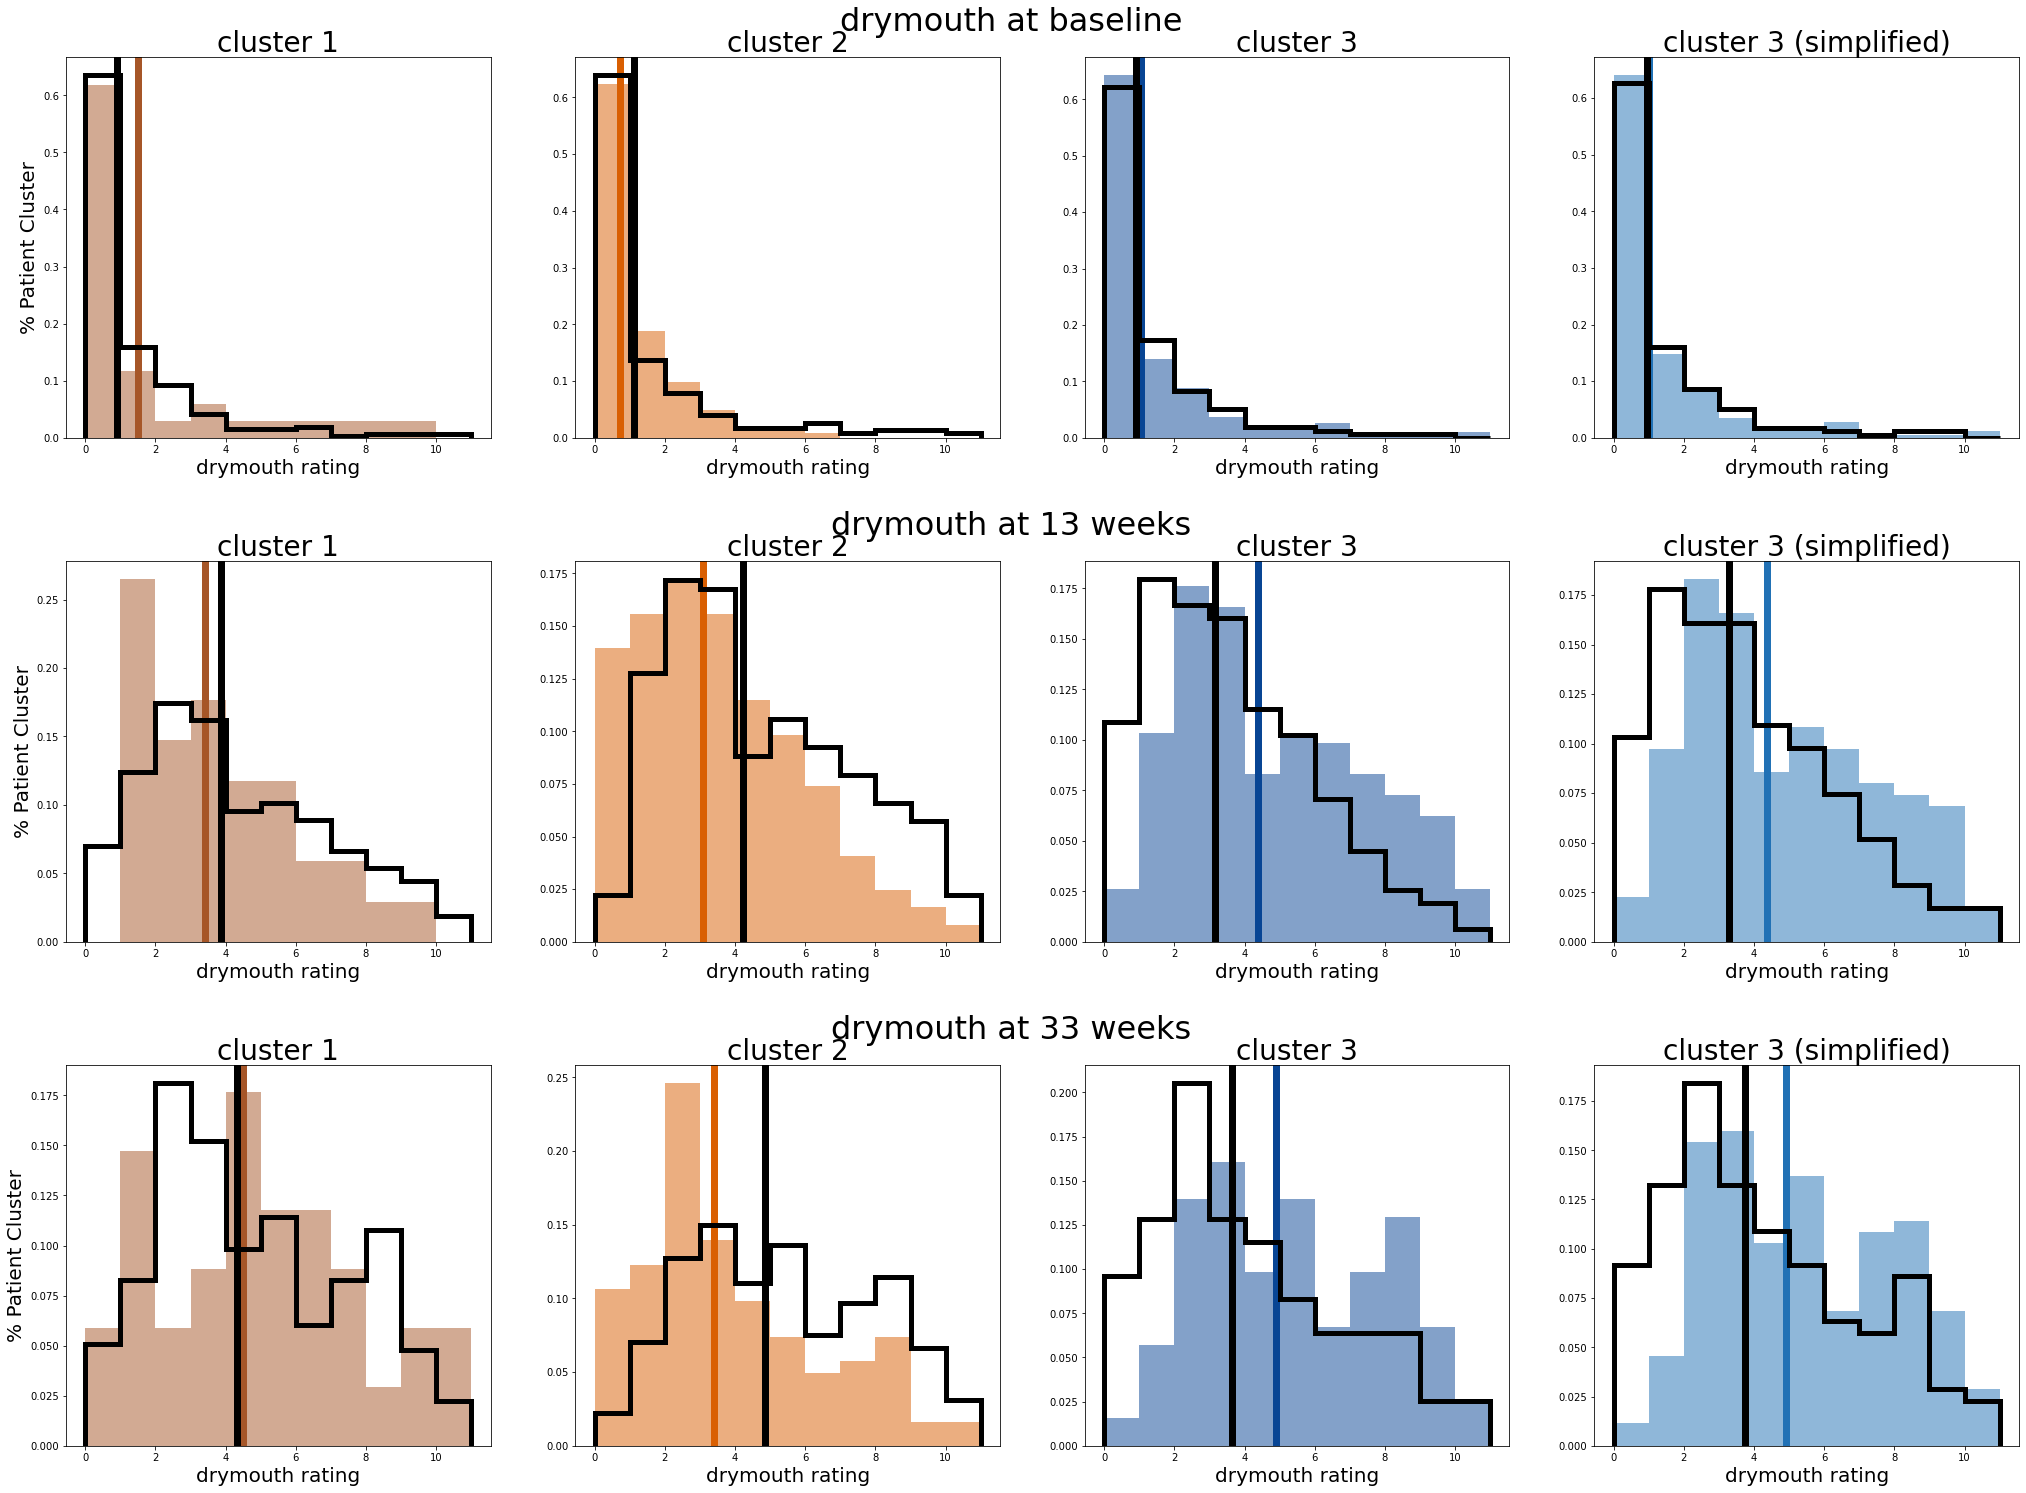

In [26]:
def bootstrap_conf_interval(vals, n = 200):
    results = []
    for i in range(n):
        tempvals = np.random.choice(vals,size=len(vals),replace=True)
        results.append(tempvals.mean())
    results = sorted(results)
    minval = results[int(len(results)*.05)]
    maxval =results[int(len(results)*.95)]
    return [minval, vals.mean(), maxval] 

def symptom_histogram_alt(ct,symptom=None,datelist=[[0],[13],[33]],size=7,**kwargs):
    df = ct.get_cluster_df(**kwargs).copy()
    mimic_df = ct.get_cluster_df(use_mimic=True)
    
    cnames = []
    
    for cluster in sorted(df.dose_clusters.unique()):

        name = 'cluster ' + str(cluster+1)
        df[name] = df['dose_clusters'] == cluster
        cnames.append(name)
    cnames.append('cluster 3 (simplified)')
    df[cnames[-1]] = mimic_df.dose_clusters
    (figwidth,figheight) = ((ct.n_clusters+2)*size,len(datelist)*size)
    fig = plt.figure(figsize=(figwidth,figheight))
    subfigs = fig.subfigures(len(datelist),1,wspace=1)
    df_dates =df.dates.iloc[0]
    
    if symptom is None:
        symptom = ct.symptoms[0]
        
    for row, dates in enumerate(datelist):
        subfig = subfigs[row]
        weekstring = '-'.join([str(d) for d in dates]) if len(dates) > 1 else str(dates[0])  
        if weekstring == '0':
            weekstring = 'baseline'
        else:
            weekstring += ' weeks'
        subfig.suptitle(symptom + ' at ' + weekstring ,fontsize=32)
        axes = subfig.subplots(1,len(cnames))
        dlocs = [df_dates.index(d) for d in dates if d in df_dates]
        df['s'] = df['symptoms_'+symptom].apply(lambda x: np.max([x[d] for d in dlocs]))
        colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']

        for col, name in enumerate(cnames):
            axis = axes[col]
            for thing in [True,False]:
                color = colors[col]
                if thing is False:
                    color = 'black'
                subdf = df[df[name].astype(bool) == thing]
                hvals = subdf.s.values
                htype = 'stepfilled' if thing else 'step'
                alpha = 1 if (htype == 'step') else .5
                axis.hist(hvals,bins=[i for i in range(12)],color=color,alpha=alpha,linewidth=5,histtype=htype,density=True)
                if thing:
                    print(name, 'symptom at', dates, bootstrap_conf_interval(hvals))
                axis.axvline(hvals.mean(),color=color,linewidth=7) 
            axis.set_title(name,fontsize=28)
            axis.set_xlabel(symptom + ' rating',fontsize=20)
            if col <= 0:
                axis.set_ylabel('% Patient Cluster',fontsize=20)
    return 
symptom_histogram_alt(ct)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB

def test_cv_models(ct,key=None,confounders=None,models=None,include_mimic=True,include_delong=True):
    if models is None:
        models = [
            ComplementNB(),
            LogisticRegression(class_weight='balanced',random_state=0),
            LogisticRegression(penalty='l1',solver='saga',class_weight='balanced',random_state=0),
            LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0),
            RandomForestClassifier(n_estimators=500,class_weight='balanced',random_state=0),
            RandomForestClassifier(n_estimators=500,max_depth=3,random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=3,class_weight='balanced',random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=10,random_state = 0),
            RandomForestClassifier(n_estimators=500,max_depth=10,class_weight='balanced',random_state = 0),
        ]
    thresholds = [3,5,7]
    results = []
    if confounders is None:
        confounders = ct.default_confounders[:]
    for model in models:
        for t in thresholds:
            res = ct.get_cv_auc(threshold=t,model=model,confounders=confounders)
            if include_delong:
                res['delong_pval'] = ct.delong_roc(threshold=t,model=model,confounders=confounders)
            if include_mimic:
                res2 = ct.get_cv_auc(threshold=t,model=model,confounders=confounders,use_mimic=True)
                for k,v in res2.items():
                    res[k+'_mimic'] = v
                if include_delong:
                    res['delong_pval_mimic'] = ct.delong_roc(threshold=t,model=model,confounders=confounders,use_mimic=True)
            if key is not None:
                res['key'] = key
            res['threshold'] = t
            res['model'] = str(model)
            res['base_roc'] = res['roc'] - res['roc_change']
            results.append(res)
    return results

def best_model_df(c, metric='base_roc',**kwargs):
    return pd.DataFrame(test_cv_models(c,**kwargs)).sort_values([metric,'threshold'],kind='mergesort',ascending=False).groupby(['threshold',metric,'model']).first()

# best_model_df(ct)

In [36]:
def plot_best_models(results,basetitle='drymouth cv'):
    dfs = [pd.DataFrame(res) for res in results]
    #I assume these all have the same set of models
    n_models = len(dfs[0].model.unique())
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','grey','navy','#e6ab02']
    n_rows = len(dfs)
    fig,axes = plt.subplots(n_rows,n_models,figsize=(8*n_rows,6*n_models))
    ymin = 0
    ymax = 0
    def format_model(m):
        m = str(m).replace('Regression','').replace("Classifier",'')
        m = re.sub(r'[a-zA-z]+\=', '', m)
        return m
    for row, df in enumerate(dfs):
        col=0
        for model, subdf in df.groupby('model'):
            axis = axes[row,col]
            subdf.plot(kind='barh',x='threshold',y=['roc_change','roc_change_mimic','f1_change','f1_change_mimic'],ax=axis,color=colors)
            col+=1
            (min_y, max_y) = axis.get_xlim()
            ymin = min(min_y,ymin)
            ymax = max(max_y,ymax)
            axis.set_title(format_model(model) + ' | ' + basetitle)
    [[ax.set_xlim((ymin,ymax)) for ax in row] for row in axes]
            
# models=[
#     LogisticRegression(class_weight='balanced',random_state=0),
#     RandomForestClassifier(n_estimators = 500, max_depth=5,class_weight='balanced',random_state=0),
#     LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0),
# ]

# test = test_cv_models(ct,
#                       models=models,
#                      )
# test2 = test_cv_models(ClusterTester(sddf,ct.cluster_organs,n_clusters=2,cluster_features=ct.cluster_features),
#                       models=models,
#                      )
# plot_best_models([test,test2])

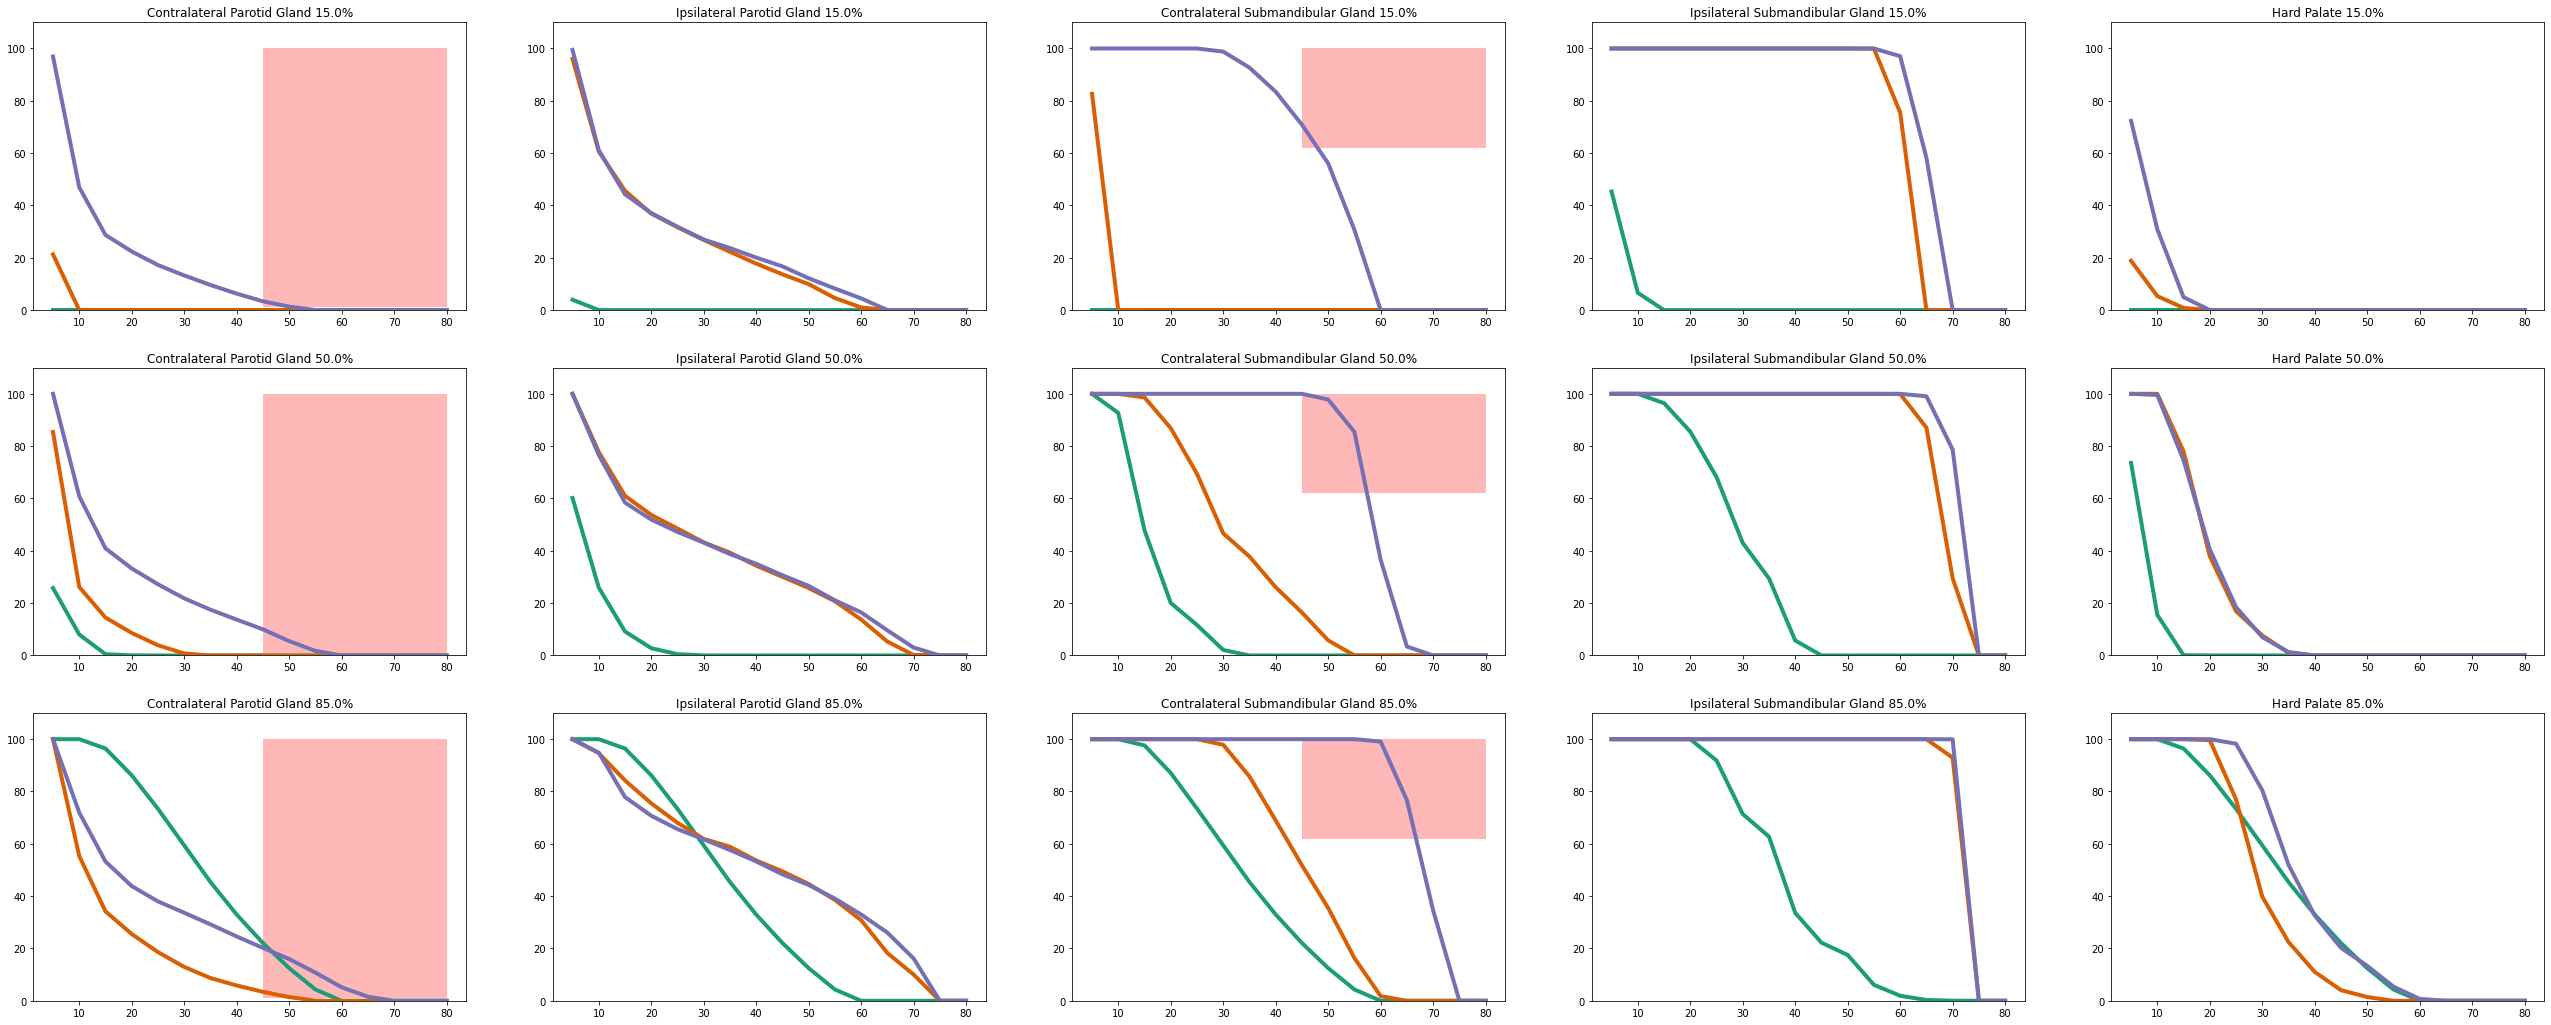

In [37]:
def get_cluster_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    cluster_vals = {}
    for cluster, subdf in df.groupby('dose_clusters'):
        vals = []
        for feature in features:
            farray = np.stack(subdf[feature].apply(filter_organs).values)
            vals.append(farray.T)
        vals = np.stack(vals,axis=-1) #organs x patients x features
        vals = np.swapaxes(vals,1,-1) #organs x features x patients
        cluster_vals[cluster] = vals
    return cluster_vals

def get_rule_points(ct):
    rule = list(ct.current_rules.values())[0][0]
    features = rule['features']
    thresholds = rule['thresholds']
    get_val = lambda x: re.match('V(\d+)_([a-zA-Z_]+)',x).groups()
    fzip = [get_val(f) for f in features]
    odict = {}
    for i,(num, organ) in enumerate(fzip):
        num = int(num)
        thold = thresholds[i]
        odict[organ] = {'value': num,'threshold': thold}
    return odict

def plot_cluster_dvhs(ctester,quantiles=[.15,.5,.85],features=None,organs=None,include_mimic=False,size=6,**kwargs):
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    (n_rows, n_cols) = (len(quantiles),len(organs))
    fig,axes = plt.subplots(n_rows,n_cols,figsize=(1.5*size*n_cols,size*n_rows))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#1b9e77','#d95f02','#7570b3','#e7298a','grey','navy','#e6ab02']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    for clustkey, carray in data.items():
        for col, organ in enumerate(organs):
            rule = rules.get(organ)
            qtiles = np.nanquantile(carray[col],quantiles,axis=-1)
            for row,quant in enumerate(qtiles):
                axis = axes[row,col]
                axis.plot(xlabels,quant,linewidth=4,color=colors[clustkey])
                axis.set_ylim((0,ylim*1.1))
                axis.set_title(format_title(organ) + ' ' + str(100*quantiles[row]) + '%')
                if rule is not None:
                    corner = [rule['value'],rule['threshold']]
                    rheight = ylim - corner[1]
                    rwidth = xlabels[-1] - corner[0]
                    rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='red')
                    axis.add_patch(rect)
    return
    

from matplotlib.patches import Rectangle
plot_cluster_dvhs(ct)

['Rt_Parotid_Gland', 'Lt_Parotid_Gland', 'Rt_Submandibular_Gland', 'Lt_Submandibular_Gland', 'Hard_Palate']


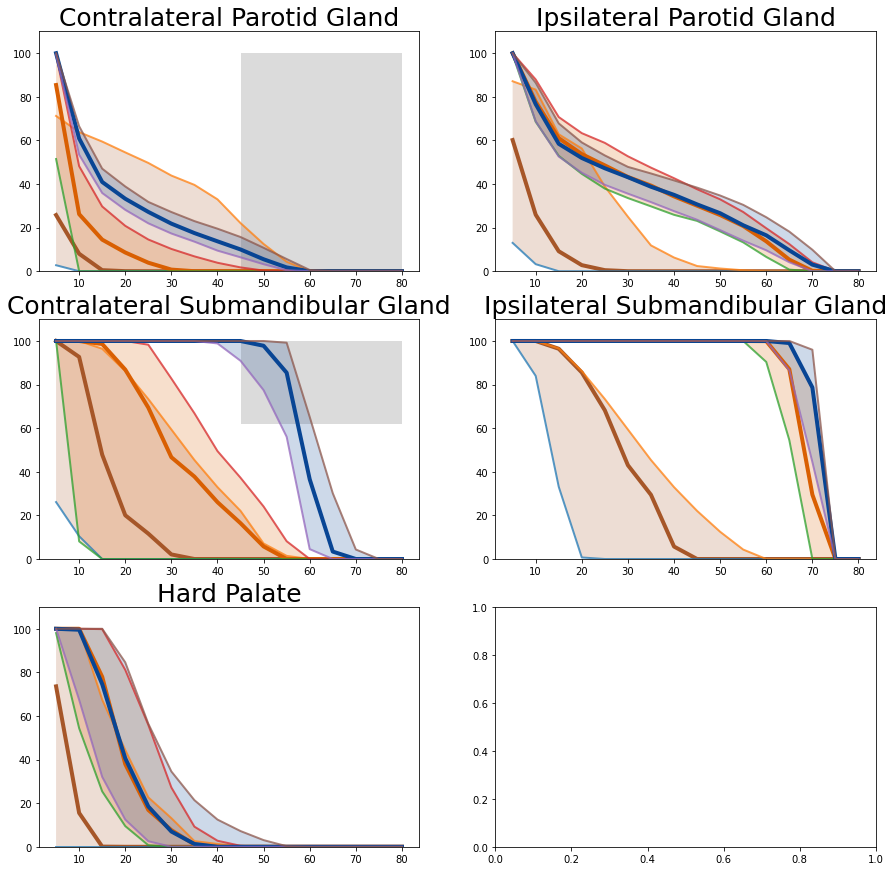

In [38]:
def plot_cluster_dvhs_alt(ctester,quantile_levels=[[.3,.70]],features=None,organs=None,include_mimic=False,size=5,**kwargs):
    #variant where it's all one column
    #assume quantiles is 3 values (lower bound, mean, upper bound)
    if features is None:
        features= get_all_dvh(ct)#ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
    print(organs)
    data = get_cluster_dvhs(ctester,features=features,organs=organs,**kwargs)
    if include_mimic and not kwargs.get('use_mimic',False):
        data2 = get_cluster_dvhs(ctester,features=features,organs=organs,use_mimic=True,**kwargs)
        data[ctester.n_clusters] = data2[1]
    n_rows = (len(organs)//2) + 1
    fig,axes = plt.subplots(n_rows,2,figsize=(3*size,size*n_rows))
    xlabels = [int(f[1:]) for f in features]
    ylim = np.max([v.max() for k,v in data.items()])
    colors = ['#a65628','#d95f02','#084594','#2171b5','#9ecae1']
    rules = get_rule_points(ctester)
    format_title = lambda x: x.replace('Lt','Ipsilateral').replace('Rt','Contralateral').replace('_',' ')
    
    for clustkey, carray in data.items():
        color = colors[clustkey]
        row = 0
        col = 0
        for pos, organ in enumerate(organs):
            axis=axes[row,col]
            col += 1
            if col > 1:
                col = 0
                row += 1
            rule = rules.get(organ)
            avg = np.nanmedian(carray[pos],axis=-1)
            axis.plot(xlabels,avg,linewidth=4,color=color)
            for quantiles in quantile_levels:
                qtiles = np.nanquantile(carray[pos],quantiles,axis=-1)
                axis.fill_between(xlabels,qtiles[0],qtiles[-1],facecolor=color,alpha=.2)
                for q in qtiles:
                    axis.plot(xlabels,q,linewidth=2,alpha=.75)
                
            axis.set_ylim((0,ylim*1.1))
            axis.set_title(format_title(organ),fontsize=25)
            if rule is not None:
                corner = [rule['value'],rule['threshold']]
                rheight = ylim - corner[1]
                rwidth = xlabels[-1] - corner[0]
                rect = Rectangle(corner,rwidth,rheight,alpha=.1,facecolor='grey')
                axis.add_patch(rect)
                
    return

from matplotlib.patches import Rectangle
plot_cluster_dvhs_alt(ct)

(89,)
(89,)


(<Figure size 2160x720 with 12 Axes>,
 array([<matplotlib.figure.SubFigure object at 0x7f2b3a52b090>,
       dtype=object))

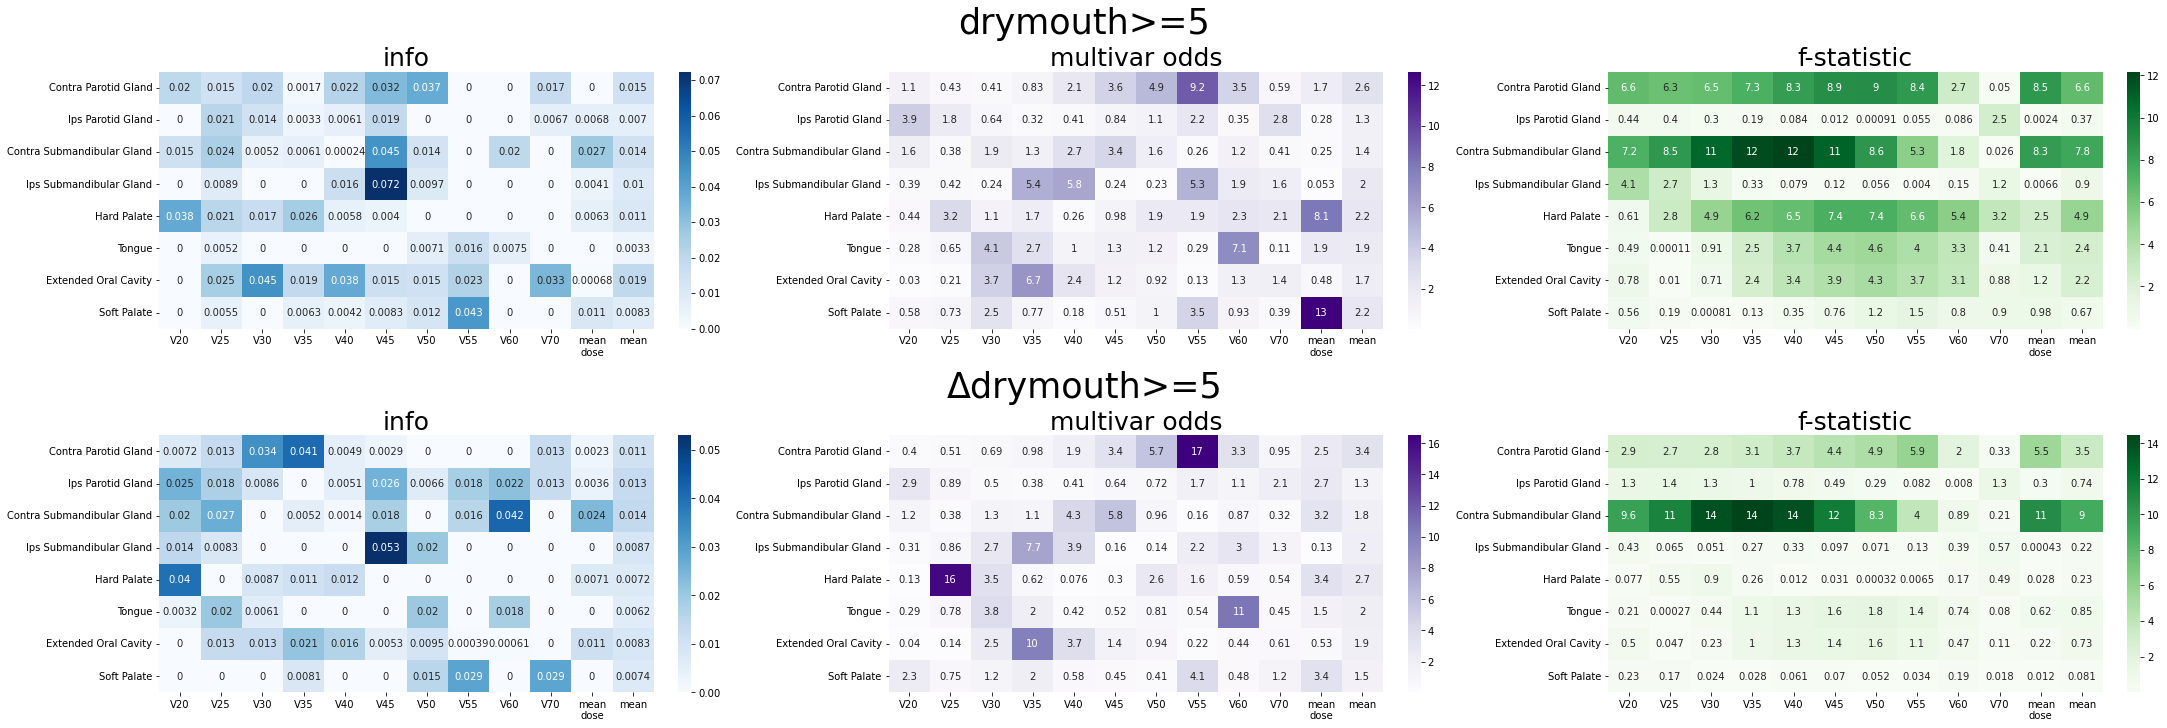

In [44]:
def get_dvhs(ctester,features=None,organs=None,**kwargs):
    if features is None:
        features= ctester.cluster_features[:]
    if organs is None:
        organs = ctester.cluster_organs[:]
        
    df = ctester.get_cluster_df(**kwargs)
    opositions = [Const.organ_list.index(i) for i in organs if i in Const.organ_list]
    filter_organs = lambda x: np.array([x[o] for o in opositions])
    vals = []
    for feature in features:
        farray = np.stack(df[feature].apply(filter_organs).values)
        vals.append(farray.T)
    vals = np.stack(vals,axis=-1) #organs x patients x features
    vals = np.swapaxes(vals,1,-1) #organs x features x patients
    return vals

def fix_oname(name):
    return name.replace('Lt_','Ips_').replace('Rt_','Contra_').replace('_',' ')

def multivar_odds(x,y,
                  regularize = True,
                  scale=True,
                  max_odds = 100,
                  alpha=None,
                   ):
    #this version uses sklearn because it doesn't work without it's good regularization
    if y.max() > 1:
        y = y/y.max()
        
    valid = [(x[:,i].std() > .001) for i in range(x.shape[1])]
    good_indices = [i for i,v in enumerate(valid) if v]
    good_x = np.stack([x[:,idx] for idx in good_indices],axis=1).astype(float)
    if regularize:
        good_x = (good_x - good_x.mean(axis=0))/(np.nanstd(good_x,axis=0))
    if scale:
        good_x = (good_x - good_x.min(axis=0))/(good_x.max(axis=0) - good_x.min(axis=0))
    good_x = np.nan_to_num(good_x,0)
    boolean = (len(np.unique(y)) <= 2)
    if boolean:
        if alpha is None:
            alpha = .1
        model = LogisticRegression(penalty='l2',C=1/alpha)
    else:
        if alpha is None:
            alpha = .0000001
        model = Ridge(alpha=alpha,positive=True)
    odds_vals = []
    
    m = model.fit(x,y)
    good_odds = m.coef_.ravel()
    print(good_odds.shape)
    if boolean:
        good_odds = np.exp(good_odds)
    odds = []
    pos = 0
    for is_valid in valid:
        if is_valid: 
            o = good_odds[pos]
            pos += 1
        else:
            o = 0
        if max_odds is not None:
            o = np.min([max_odds,o])
            if not boolean:
                o = np.max([-max_odds,o])
        odds.append(o)
    return np.array(odds)

def test_dvh_info(ctester,threshold=-1,metric='info',confounders=None,use_change=False,features=None,organs=None):
    if features is None:
        features= get_all_dvh(ctester)
    if confounders is None:
        confounders = ctester.default_confounders[:]
    confounder_df = ctester.df[confounders]
#     organs =  Const.organ_list[:] 
    if organs is None:
        organs = ctester.cluster_organs[:]
    darray = get_dvhs(ctester,features=features,organs=organs) #
    darray = np.swapaxes(darray,-1,0) #patients x features x organs
    darray = darray.reshape((darray.shape[0],-1)) #patients x features - organs
    darray = (darray - darray.mean(axis=1).reshape(-1,1))/(.0001 + darray.std(axis=1).reshape(-1,1))
    darray = (darray - darray.min(axis=1).reshape(-1,1))/(darray.max(axis=1).reshape(-1,1) - darray.min(axis=1).reshape(-1,1))
    darray = np.nan_to_num(darray)
    outcome = ctester.get_outcome(threshold=threshold,use_change=use_change)
    if confounders is not None and len(confounders) > 0:
        merged = np.concatenate([darray,confounder_df.values],axis=-1)
    else:
        merged = darray
    if 'odds' in metric and 'multi' in metric:
        info = multivar_odds(merged,outcome)
    else:
        if threshold > 0:
            if metric == 'info':
                info = mutual_info_classif(merged,outcome,n_neighbors=6,random_state=0)
            elif metric == 'pvalue':
                info = 1 - f_classif(merged,outcome)[1]
            else:
                info = f_classif(merged,outcome)[0]
        else:
            if metric=='info':
                info = mutual_info_regression(merged,outcome,n_neighbors=6,random_state=0)
            elif metric== 'pvalue':
                info = 1 - f_regression(merged,outcome)[1]
            else:
                info = f_regression(merged,outcome)[0]
    info = np.nan_to_num(info,1)
    res = {}
    pos = 0
    for f in features:
        values = []
        entry = {}
        for o in organs:
            curr_info = info[pos]
            values.append(curr_info)
            entry[fix_oname(o)] = curr_info
            pos += 1
        res[f] = entry
    df = pd.DataFrame(res)
    df['max'] = df.apply(lambda x: np.mean(x),axis=1)
    df = df.sort_values('max',ascending=False)
#     df[ = df.apply(lambda x: np.max(x),axis=1)
    return df.drop('max',axis=1)

def plot_dvh_correlations(ct,
                          metrics=None,
                          features = None,
                          thresholds=[-1],
                          organs = None,
                          **kwargs):
    if metrics is None:
        metrics = ['info','f-statistic']
    fig = plt.figure(constrained_layout=True,figsize=(10*len(metrics),len(thresholds)*5))
    axes = fig.subfigures(len(thresholds),1)
    if organs is None:
        organs = sorted(ct.cluster_organs[:])
    order = [fix_oname(o) for o in organs]
    color_dict = {
        'info': 'Blues',
        'f-statistic': "Greens",
        'multivar_odds': 'Purples'
    }
    for row, threshold in enumerate(thresholds):
        use_change = False
        thold = np.abs(threshold)
        if threshold < 0:
            use_change = True
        if thold == 1:
            thold = 0
                
        subfig = axes[row]
        title = ct.symptoms[0] 
        if use_change:
            title = 'Δ' + title
        if thold > 1:
            title += '>=' +str(thold)
        else:
            title += ' (linear)'
        subfig.suptitle(title,fontsize=35)
        subplots = subfig.subplots(1,len(metrics))
        for col, metric in enumerate(metrics):
            
            ax = subplots[col]
            temp = test_dvh_info(ct,
                                 metric=metric,
                                 use_change=use_change,
                                 threshold=thold,
                                 features=features,
                                 organs=organs,
                                 **kwargs)
            temp['mean'] = temp.values.mean(axis=1)
            d = temp.loc[order]
            d.columns = [c.replace('_','\n') for c in d.columns]
            sns.heatmap(d,ax=ax,cmap=color_dict.get(metric,'Reds'),annot=True)  
            
            title =  metric.replace('_',' ')
            ax.set_title(title,fontdict={'fontsize': 25})
    return fig,axes

plot_dvh_correlations(ct,
                      metrics=['info','multivar_odds','f-statistic'],
                      features = ['V20','V25','V30','V35','V40','V45','V50','V55','V60','V70','mean_dose'],
                      thresholds = [5,-5],
                      confounders=['hpv'],
                      organs = ct.cluster_organs + ['Tongue','Extended_Oral_Cavity','Soft_Palate'],
                     )

(89,)
(89,)


(<Figure size 2160x720 with 12 Axes>,
 array([<matplotlib.figure.SubFigure object at 0x7f2ab0833e50>,
       dtype=object))

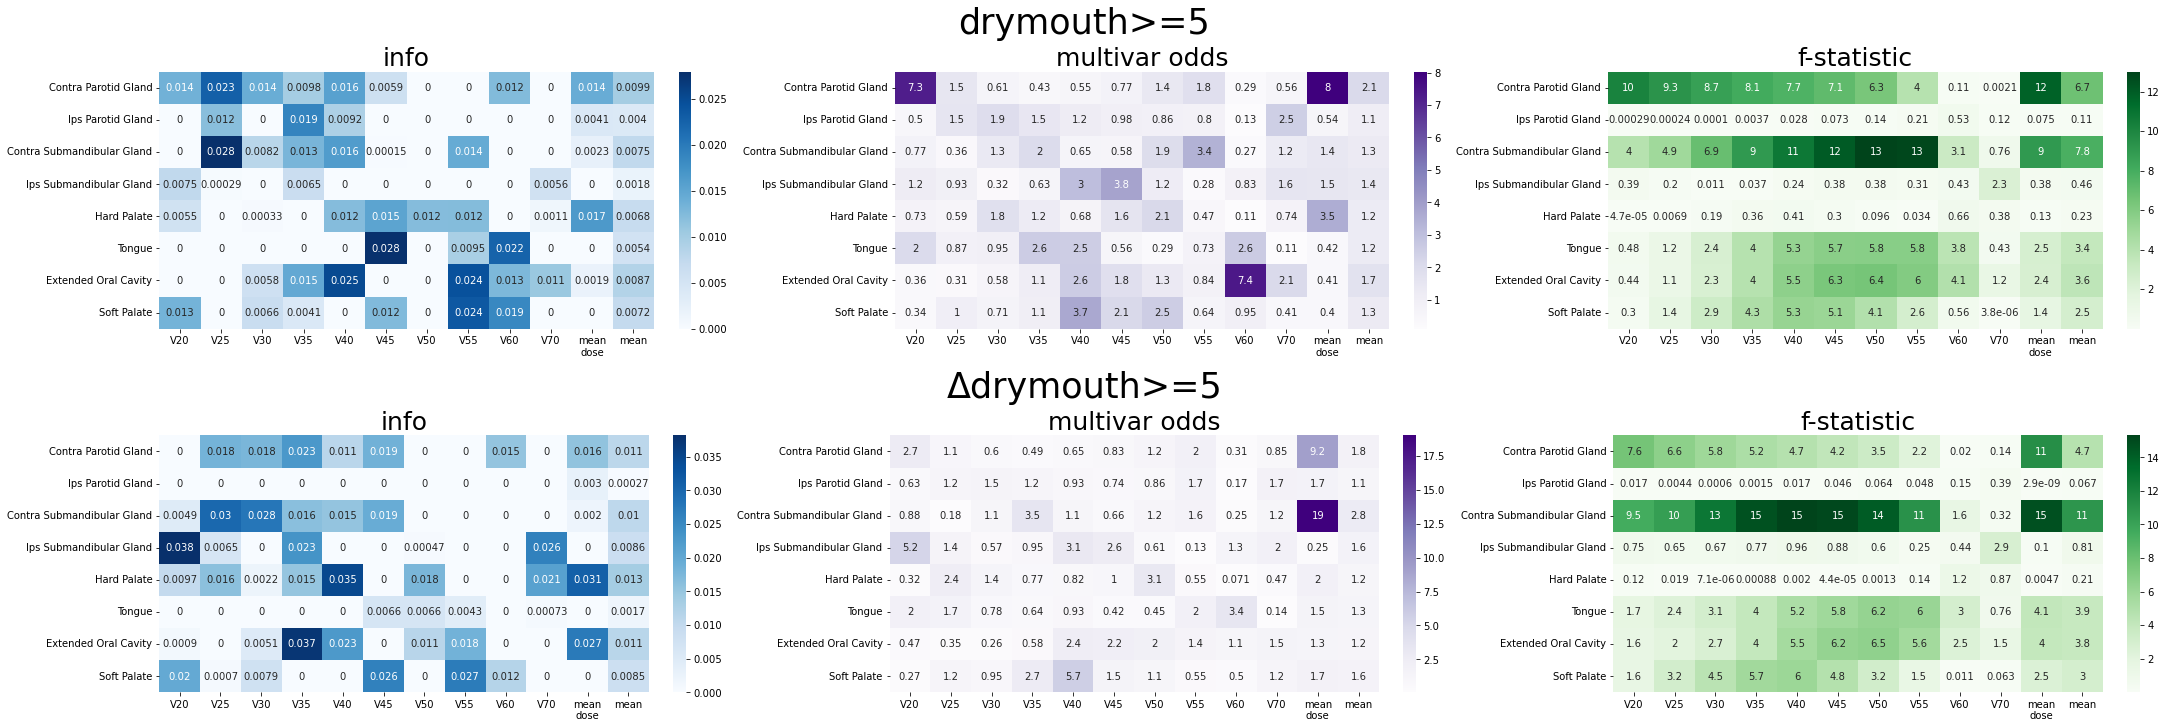

In [43]:
plot_dvh_correlations(ct_i,
                      metrics=['info','multivar_odds','f-statistic'],
                      features = ['V20','V25','V30','V35','V40','V45','V50','V55','V60','V70','mean_dose'],
                      thresholds = [5,-5],
                      confounders=['hpv'],
                      organs = ct_i.cluster_organs + ['Tongue','Extended_Oral_Cavity','Soft_Palate']
                     )

In [ ]:
def get_rule_points(ct):
    rule = list(ct.current_rules.values())[0][0]
    features = rule['features']
    thresholds = rule['thresholds']
    get_val = lambda x: re.match('V(\d+)_([a-zA-Z_]+)',x).groups()
    fzip = [get_val(f) for f in features]
    odict = {}
    for i,(num, organ) in enumerate(fzip):
        num = int(num)
        thold = thresholds[i]
        odict[organ] = {'value': num,'threshold': thold}
    return odict
get_rule_points(ct)

0.5476357209550486 0.5487577643236782 0.5498798076923077
0.5476357209550486 0.5487577643236782 0.5498798076923077
0.5476357209550486 0.5487577643236782 0.5498798076923077


organs  symptoms  \
0  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   
1  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   
2  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   
3  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   
4  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   
5  Hard_Palate,Rt_Parotid_Gland,Lt_Parotid_Gland,...  drymouth   

                          features  n_clusters confounders  \
0  V25,V30,V35,V40,V45,V50,V55,V60           2        None   
1  V25,V30,V35,V40,V45,V50,V55,V60           2        None   
2  V25,V30,V35,V40,V45,V50,V55,V60           3        None   
3  V25,V30,V35,V40,V45,V50,V55,V60           3        None   
4  V25,V30,V35,V40,V45,V50,V55,V60           4        None   
5  V25,V30,V35,V40,V45,V50,V55,V60           4        None   

                                               model  threshold dates  \
0  LogisticRegression(class_weight='balanced', l1...          5    13   
1  LogisticRegression(class_weight='balanced', l1...          5    33   
2  LogisticRegression(class_weight='balanced', l1...          5    13   
3  LogisticRegression(class_weight='balanced', l1...          5    33   
4  LogisticRegression(class_weight='balanced', l1...          5    13   
5  LogisticRegression(class_weight='balanced', l1...          5    33   

   roc_base  roc_mimic  ...  precision_3  precision_change_3  recall_3  \
0  0.546415   0.574855  ...          NaN                 NaN       NaN   
1  0.545318   0.569378  ...          NaN                 NaN       NaN   
2  0.581289   0.556331  ...          NaN                 NaN       NaN   
3  0.592087   0.572379  ...          NaN                 NaN       NaN   
4  0.561811   0.552885  ...     0.416667           -0.009369  0.546875   
5  0.546435   0.567160  ...     0.478528           -0.005944  0.509804   

   recall_change_3      f1_3  f1_change_3  f_half_3  f_half_change_3  \
0              NaN       NaN          NaN       NaN              NaN   
1              NaN       NaN          NaN       NaN              NaN   
2              NaN       NaN          NaN       NaN              NaN   
3              NaN       NaN          NaN       NaN              NaN   
4        -0.015625  0.472973    -0.011876  0.437500        -0.010261   
5         0.000000  0.493671    -0.003144  0.484472        -0.004863   

       f2_3  f2_change_3  
0       NaN          NaN  
1       NaN          NaN  
2       NaN          NaN  
3       NaN          NaN  
4  0.514706    -0.013928  
5  0.503226    -0.001302  

[6 rows x 116 columns]

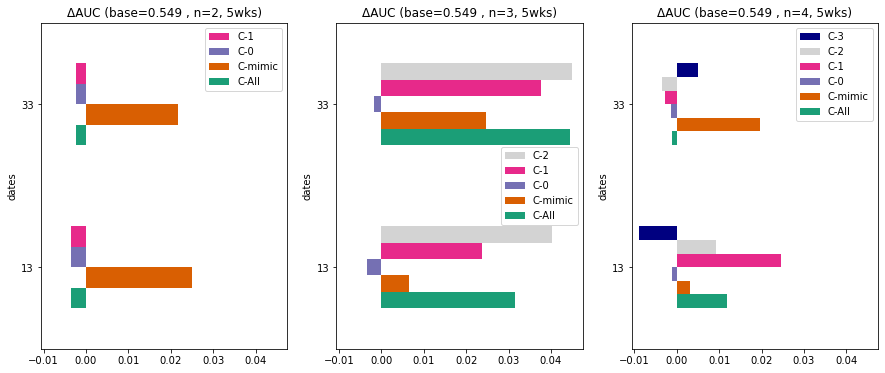

In [82]:
def get_mimic_cv_results(df):
    organ_lists = [
#         [
#             'Genioglossus_M',
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
                [
#             'Tongue',
                    'Hard_Palate',
            'Rt_Parotid_Gland','Lt_Parotid_Gland',
            'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
        ],
#         [
#             'Mylogeniohyoid_M',
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
#         [
#             'Rt_Parotid_Gland','Lt_Parotid_Gland',
#             'Rt_Submandibular_Gland','Lt_Submandibular_Gland',
#         ],
    ]
    confounder_lists = [
        None,
#         ['t4','t3','n_severe','hpv'],
#         ['t4','t3','n_severe','hpv','Parotid_Gland_limit'],
#         ['t4','t3','n2','n3','hpv','BOT','Tonsil','Parotid_Gland_limit'],
#         ['t4','t3','n_severe','hpv','BOT','Tonsil','Parotid_Gland_limit','Esophagus_limit'],
    ]
    symptom_lists = [
        ['drymouth'],
#         ['swallow'],
#         ['taste'],
#         ['teeth'],
#         ['choke'],
#         ['sob'],
#         ['voice'],
#         ['nausea','vomit'],
#         ['drymouth','swallow'],
#         ['mucus','mucositis'],
    ]
    outcome_date_list = [
        [13],
        [33]
    ]
    feature_lists = [
#         ['V40','V45','V50','V55','V60'],
#         ['V40','V45','V50','V55','V60','V65'],
        ['V25','V30','V35','V40','V45','V50','V55','V60'],
#         ['V40','V50','V60'],
    ]
    
    thresholds = [5]
    cluster_sizes = [
        2,
        3,
        4,
    ]
    
    models = [
#         LogisticRegression(class_weight='balanced',random_state=0),
        LogisticRegression(penalty='elasticnet',l1_ratio=.5,solver='saga',class_weight='balanced',random_state=0)
#         RandomForestClassifier(max_depth=3,class_weight='balanced'),
    ]
    n_runs = np.prod([len(l) for l in [outcome_date_list,organ_lists,confounder_lists,symptom_lists,feature_lists,thresholds,cluster_sizes,models]])
    i = 1
    result_list = []
    for organs in organ_lists:
        for symptoms in symptom_lists:
            for features in feature_lists:
                for n in cluster_sizes:
                    for outcome_dates in outcome_date_list:
                        ct = ClusterTester(df,
                                           organs,
                                           n_clusters=n,
                                           cluster_features = features,
                                           symptoms=symptoms,
                                           outcome_dates=outcome_dates,
                                          )
                        #pre-compute mimic model results
                        ct.get_cluster_df(use_mimic=True)
                        for confounders in confounder_lists:
                            for model in models:
                                for threshold in thresholds:
                                    base_results = ct.get_cv_auc(threshold=threshold,
                                                                 model=model,
                                                                 use_mimic = False,
                                                                 confounders=confounders)
                                    mimic_results = ct.get_cv_auc(threshold=threshold,
                                                                 model=model,
                                                                 use_mimic = True,
                                                                 confounders=confounders)
                                    clust_resultlist = [(c,ct.get_cv_auc(threshold=threshold,confounders=confounders,cluster=c)) for c in range(ct.n_clusters)]
                                    entry = {
                                        'organs': organs,
                                        'symptoms': symptoms,
                                        'features': features,
                                        'n_clusters': n,
                                        'confounders': confounders,
                                        'model': model,
                                        'threshold': threshold,
                                        'dates': ''.join([str(i) for i in outcome_dates]) if len(outcome_dates) > 0 else outcome_dates[0],
                                    }
                                    print('_____',np.round(100*i/n_runs,2),'%_______')
                                    print(entry)
                                    for k,v in base_results.items():
                                        mr = mimic_results.get(k)
                                        entry[k+'_base'] = v
                                        entry[k+'_mimic'] = mr
                                        if k.replace('_change','') in ['roc','mcc','f1']:
                                            print('base '+k,v,'mimic '+k,mr)
                                    for (c,res) in clust_resultlist:
                                        for k,v in res.items():
                                            entry[k+'_'+str(c)] = v
                                            if k.replace('_change','') in ['roc','mcc','f1']:
                                                print(str(c) + k,v)
                                    result_list.append(entry)
                                    print('___________')
                                    print()
                                    i += 1
    return result_list


def format_cv_results(results):
    laucdf = pd.DataFrame(results).sort_values('roc_change_mimic')
    groups = ['symptoms','threshold','n_clusters','organs','features','confounders']
    for col in ['organs','symptoms','features','confounders']:
        laucdf[col] = laucdf[col].apply(lambda x: ','.join(x))
    for c in groups:
        if len(laucdf[c].unique()) < 2:
            groups.remove(c)
    return laucdf.groupby(groups).first()

def plot_cvtest(cvtest,y=[],ykey='roc_change',colcol='dates',rowcol='n_clusters',x='threshold',**kwargs):
    #I reveresed rows and cols on accidents but it's too complicated to fix 
    df = pd.DataFrame(cvtest)
    colors =['#1b9e77','#d95f02','#7570b3','#e7298a','lightgrey','navy','#e6ab02']
    for col in ['organs','symptoms','features','confounders']:
        try:
            df[col] = df[col].apply(lambda x: ','.join(x) if x is not None else 'None')
        except Exception as e:
            print(col,e)
    for key, value in kwargs.items():
        if key in df.columns:
            df = df[df[key] == value]
    nrows = len(df[rowcol].unique())
    ncols = len(df[colcol].unique())
    fig,axes = plt.subplots(ncols,nrows,figsize=(5*nrows,6*ncols))
    
    colpos = 0
    ymin = 0
    ymax = 0
    for col, coldf in df.groupby(colcol):
        rowpos = 0
        for row,subdf in coldf.groupby(rowcol):
            subdf= subdf.dropna(axis=1,how='all')
            ytemp =  [c for c in subdf.columns if ykey in c] +y
            if ncols > 1:
                axis = axes[colpos,rowpos]
            else:
                axis = axes[rowpos]
            original_roc = subdf.roc_base - subdf.roc_change_base
            print(original_roc.min(),original_roc.mean(),original_roc.max())
            axis.set_title('ΔAUC (base=' + str(np.round(original_roc.mean(),3)) +' , n='+str(row)+', '+ str(col) + 'wks' +')')
            subdf[ytemp+[x]].fillna(0).plot(kind='barh',y=ytemp,x=x,ax=axis,color=colors)
            h, l = axis.get_legend_handles_labels()
            l = ['C-' + text.replace(ykey,'').replace('_','').replace('base','All') for text in l]
            axis.legend(h[::-1], l[::-1])
            rowpos += 1
            (min_y, max_y) = axis.get_xlim()
            ymin = min(min_y,ymin)
            ymax = max(max_y,ymax)
        
        colpos+=1
    for row in axes:
        if ncols > 1:
            for ax in row:
                ax.set_xlim((ymin,ymax))
        else:
            row.set_xlim((ymin,ymax))
    return df


# cvtest = get_mimic_cv_results(sddf3)
plot_cvtest(cvtest,colcol='threshold',x='dates')
# format_cv_results(cvtest).to_csv(Const.data_dir+'base_organ_cv_test_results_'+timestamp()+'.csv')
# format_cv_results(cvtest).plot(kind='barh',y=['roc_change_base','roc_change_mimic'],figsize=(10,30))

In [46]:
def get_limit_performance(ct,
                          other_cols = [
                              't4','t3','t_severe',
                              'n3','n_severe',
                              'IMRT','VMAT',
                              'age_65','old',
                              'performance_1','performance_2','performance_high'
                          ]
                         ):
    df = ct.df.copy()
    limits = [c for c in df.columns if '_limit' in c]
    y = ct.get_outcome()
    results = []
    for limit in limits + other_cols:
        subdf = df[~df[limit].isnull()]
        ypred = np.zeros((len(y),2))
        ypred[:,1] = subdf[limit].values
        ypred[:,0] = ~subdf[limit].values
        res = get_stratification_metrics(y,ypred)
        res['name'] = limit
        results.append(res)
    return pd.DataFrame(results).sort_values('mcc',ascending=False)

get_limit_performance(ct)

roc       mcc       dor  accuracy  precision    recall        f1  \
11  0.558173  0.141942  0.512642  0.593123   0.575342  0.274510  0.371681   
8   0.552071  0.121881  4.170213  0.518625   0.471910  0.823529  0.600000   
6   0.553438  0.108888  1.911532  0.538682   0.481308  0.673203  0.561308   
4   0.538565  0.097172  0.357320  0.575931   0.537313  0.235294  0.327273   
9   0.543801  0.086963  1.186968  0.541547   0.480447  0.562092  0.518072   
10  0.542200  0.085249  1.602002  0.530086   0.473430  0.640523  0.544444   
13  0.518007  0.060264  0.150000  0.567335   0.529412  0.117647  0.192513   
3   0.514089  0.032197  0.319339  0.544413   0.465909  0.267974  0.340249   
7   0.513922  0.029087  0.474882  0.532951   0.458333  0.359477  0.402930   
5   0.506052  0.023291  0.078560  0.558739   0.480000  0.078431  0.134831   
19  0.509070  0.022021  0.242857  0.544413   0.459459  0.222222  0.299559   
12  0.506086  0.012690  1.544670  0.487106   0.442982  0.660131  0.530184   
18  0.466153  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
24  0.513789  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
23  0.499667  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
22  0.514623  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
21  0.502768  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
25  0.513455  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
17  0.482293  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
16  0.523576  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
15  0.511388  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
14  0.512188  0.000000       inf  0.438395   0.438395  1.000000  0.609562   
20  0.493264 -0.013370  0.750130  0.492837   0.431818  0.496732  0.462006   
0   0.497449 -0.047362  0.000000  0.558739   0.000000  0.000000  0.000000   
1   0.487562 -0.062904  0.010738  0.544413   0.285714  0.026144  0.047904   
2   0.470038 -0.090465  3.917373  0.424069   0.421569  0.843137  0.562092   

      f_half        f2                   name  
11  0.471910  0.306569           Larynx_limit  
8   0.515971  0.716724              SPC_limit  
6   0.510406  0.623487              MPC_limit  
4   0.427553  0.265096              IPC_limit  
9   0.494822  0.543616             SPC_limit2  
10  0.499490  0.598291         Mandible_limit  
13  0.311419  0.139319        Esophagus_limit  
3   0.405941  0.292857   Parotid_Gland_limit2  
7   0.434439  0.375683             MPC_limit2  
5   0.237154  0.094192             IPC_limit2  
19  0.378619  0.247813                   IMRT  
12  0.474178  0.601190  Brachial_Plexus_limit  
18  0.493867  0.796046               n_severe  
24  0.493867  0.796046          performance_2  
23  0.493867  0.796046          performance_1  
22  0.493867  0.796046                    old  
21  0.493867  0.796046                 age_65  
25  0.493867  0.796046       performance_high  
17  0.493867  0.796046                     n3  
16  0.493867  0.796046               t_severe  
15  0.493867  0.796046                     t3  
14  0.493867  0.796046                     t4  
20  0.443407  0.482234                   VMAT  
0        NaN       NaN        Brainstem_limit  
1   0.095694  0.031949      Spinal_Cord_limit  
2   0.468410  0.702614    Parotid_Gland_limit

threshold        covariate    effect    pvalue       outcome
12          5  perf. score = 2  6.587838  0.090371  absolute >=5
25         -5  perf. score = 2  2.090090  0.396696    change >=5
21         -5              BOT  1.696970  0.022525    change >=5
14         -5        T-stage 3  1.572948  0.184565    change >=5
8           5              BOT  1.453435  0.104584  absolute >=5
0           5        T-stage 4  1.316176  0.471117  absolute >=5
20         -5             IMPT  1.295655  0.496065    change >=5
18         -5             IMRT  1.241379  0.485331    change >=5
23         -5          age\n65  1.236219  0.444943    change >=5
1           5        T-stage 3  1.210154  0.638805  absolute >=5
7           5             IMPT  1.140152  0.748254  absolute >=5
5           5             IMRT  1.114286  0.694039  absolute >=5
17         -5             HPV+  1.077853  0.885100    change >=5
15         -5        N-stage 2  1.041380  0.909165    change >=5
10          5          age\n65  1.027946  0.904885  absolute >=5
11          5  perf. score = 1  0.995556  1.000000  absolute >=5
6           5             VMAT  0.947532  0.829667  absolute >=5
19         -5             VMAT  0.925287  0.819491    change >=5
24         -5  perf. score = 1  0.923598  0.883048    change >=5
4           5             HPV+  0.885484  0.682651  absolute >=5
2           5        N-stage 2  0.878514  0.589695  absolute >=5
3           5        N-stage 3  0.737778  0.353052  absolute >=5
13         -5        T-stage 4  0.720000  0.563916    change >=5
16         -5        N-stage 3  0.650327  0.249530    change >=5
9           5           Tonsil  0.570212  0.012053  absolute >=5
22         -5           Tonsil  0.503452  0.005331    change >=5

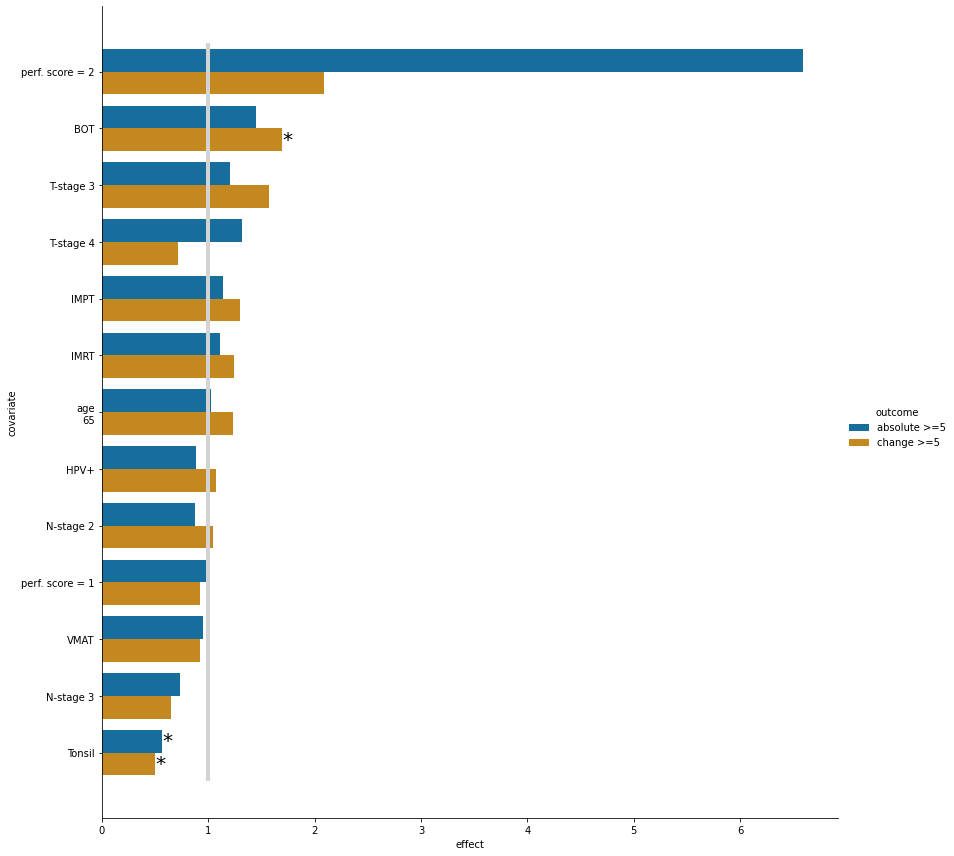

In [49]:
def get_confounder_correlations(ct,
                                use_cluster=True,
                                use_mimic=True,
                                cols = [
                                      't4','t3',
                                      'n2','n3',
                                      'HPV+',
                                      'IMRT','VMAT','IMPT',
                                      'BOT','Tonsil',
                                      'age_65',
                                      'performance_1','performance_2',
                                  ],
                                use_limits = False):
    df = ct.df.copy()
    name_map = {
        't4': 'T-stage 4',
        't3': 'T-stage 3',
        'n2': 'N-stage 2',
        'n3': 'N-stage 3',
        'hpv_pos': 'HPV+',
        't_severe': 'T-stage > 2',
        'n_severe': 'N-stage > 1',
        'age_65': 'age > 65',
        'performance_1_1': 'perf. score = 1',
        'performance_2_1': 'perf. score = 2',
        'performance_high': 'perf. score > 0',
    }
    df['HPV+'] = df.hpv.apply(lambda x: x==1)
    to_keep = cols[:]
    if use_cluster:
        cluster_df = ct.get_cluster_df()
        
        cluster_df = Utils.onehotify(df[['dose_clusters']])
        for col in cluster_df.columns:
            to_keep.append(col)
            df[col] = cluster_df[col]
            
    if use_mimic:
        mimic_df = ct.get_cluster_df(use_mimic=True)
        df['simple_cluster'] = mimic_df['dose_clusters'].astype(bool)
        to_keep.append('simple_cluster')
    if use_limits:
        to_keep = to_keep + [c for c in df.columns if '_limit' in c and 'Brainstem' not in c and c not in cols]
    df = Utils.onehotify(df[to_keep],drop_first=True)
    thresholds = [5]
    results = []
    for use_change in [False,True]:
        for threshold in thresholds:
            y = ct.get_outcome(threshold = threshold,use_change=use_change)
            for col in df.columns:
                ypred = df[col].fillna(0).values
                if threshold > 0:
                    [effect,pval] = Metrics.boolean_fisher_exact(y,ypred)
                else:
                    [effect,pval] = Metrics.vector_chi2(y,ypred)
                if use_change:
                    t = -threshold
                else:
                    t = threshold
                cname = name_map.get(col,col)
                cname = cname.replace('_1','').replace('.0','').replace('_True','').replace('_','\n')
                cname = name_map.get(cname,cname)
                entry = {
#                     'outcome_change':use_change,
                    'threshold':t,
                    'covariate': cname,
                    'effect': effect,
                    'pvalue': pval,
                }
                results.append(entry)
    return pd.DataFrame(results)#.groupby(['outcome_change','threshold','covariate']).first()

def plot_confounder_correlations(ct,**kwargs):
    ccors = get_confounder_correlations(ct,**kwargs)
    ccors['outcome'] = ccors.threshold.apply(lambda x: 'absolute >=' + str(x) if x >= 0 else 'change >=' + str(np.abs(x)) )
    ccors = ccors.sort_values('effect',ascending=False)
    chart = sns.catplot(
        data=ccors,
        height=12,
        aspect=1,
        x='effect',
        y='covariate',
        hue='outcome',
        kind='bar',
        orient='h',
        palette='colorblind',
    )
    ax = chart.facet_axis(0,0)
    for c in ax.containers:
        threshold = c.get_label()
        pvals = ccors[ccors.outcome==threshold].pvalue.values
        labels = [('' if p > .05 else '*') for p in pvals]
        ax.bar_label(c,labels=labels,label_type='edge',fontsize=20)
        ax.vlines(1,-.5,len(ccors.covariate.unique())-.5,color='lightgrey',linewidth=4)
    return ccors
plot_confounder_correlations(ct,use_limits=False,use_mimic=False,use_cluster=False)

threshold                covariate    effect    pvalue       outcome
10          5            Larynx\nlimit  2.013949  0.011405  absolute >=5
20         -5               SPC\nlimit  1.996101  0.021749    change >=5
23         -5            Larynx\nlimit  1.846520  0.025168    change >=5
7           5               SPC\nlimit  1.820331  0.030168  absolute >=5
18         -5               MPC\nlimit  1.671958  0.035392    change >=5
3           5               IPC\nlimit  1.637717  0.076005  absolute >=5
16         -5               IPC\nlimit  1.636255  0.083255    change >=5
5           5               MPC\nlimit  1.577477  0.046522  absolute >=5
12          5         Esophagus\nlimit  1.500000  0.279323  absolute >=5
9           5          Mandible\nlimit  1.422185  0.124664  absolute >=5
8           5              SPC\nlimit2  1.421602  0.107180  absolute >=5
19         -5              MPC\nlimit2  1.315038  0.279862    change >=5
21         -5              SPC\nlimit2  1.267241  0.306955    change >=5
22         -5          Mandible\nlimit  1.201949  0.486119    change >=5
4           5              IPC\nlimit2  1.198036  0.680796  absolute >=5
17         -5              IPC\nlimit2  1.173214  0.825150    change >=5
2           5   Parotid\nGland\nlimit2  1.160524  0.619463  absolute >=5
24         -5  Brachial\nPlexus\nlimit  1.157687  0.631592    change >=5
25         -5         Esophagus\nlimit  1.139037  0.705182    change >=5
6           5              MPC\nlimit2  1.131083  0.649816  absolute >=5
15         -5   Parotid\nGland\nlimit2  1.089901  0.792952    change >=5
11          5  Brachial\nPlexus\nlimit  1.055270  0.821741  absolute >=5
13         -5      Spinal\nCord\nlimit  0.818182  1.000000    change >=5
1           5    Parotid\nGland\nlimit  0.576977  0.102076  absolute >=5
14         -5    Parotid\nGland\nlimit  0.509906  0.054868    change >=5
0           5      Spinal\nCord\nlimit  0.499329  0.282427  absolute >=5

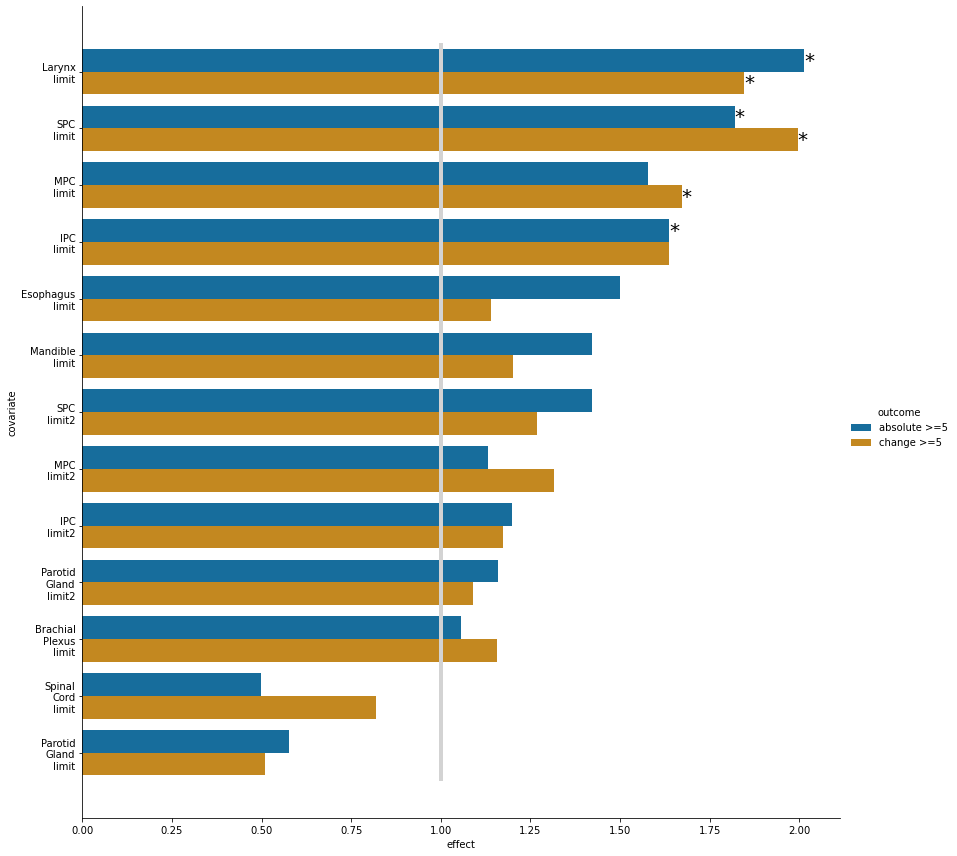

In [50]:
plot_confounder_correlations(ct,use_limits=True,use_mimic=False,use_cluster=False,cols=[])